In [1]:
#===================================================================
# Imports y espacio de búsqueda
#===================================================================

import numpy as np
import json
from ultralytics import YOLO

# Definir espacio de hiperparámetros
param_space = {
    "lr0": (1e-4, 1e-2),
    "momentum": (0.85, 0.98),
    "weight_decay": (1e-6, 1e-3),
    "hsv_s": (0.0, 0.7),
    "scale": (0.0, 1.0),
    "translate": (0.0, 0.2)
}
param_keys = list(param_space.keys())
dim = len(param_keys)

def sample_particle():
    return np.array([np.random.uniform(low, high) for low, high in param_space.values()])

In [2]:
#===================================================================
# Baseline (con Hiperparámetros por defecto)
#===================================================================

def run_baseline_training(epochs=5, imgsz=640):
    """
    Entrena un modelo YOLOv8 con hiperparámetros por defecto
    para establecer una línea de base (baseline) de rendimiento.

    Retorna:
        float: El score mAP50-95 del modelo baseline.
    """
    print("--- Iniciando Entrenamiento Baseline ---")
    print(f"Entrenando con {epochs} épocas y tamaño de imagen {imgsz}...")
    
    model = YOLO("yolov8n.pt")

    # Entrena con los valores por defecto, guardando en una carpeta específica
    model.train(
        data="data.yaml",
        epochs=epochs,
        imgsz=imgsz,
        verbose=True, # Mantenlo en True para ver el progreso claramente
        name='baseline_training' # Nombra la carpeta de resultados para claridad
    ) 

    # Valida y obtén las métricas
    metrics = model.val()
    baseline_map = metrics.box.map

    print("\n--- Entrenamiento Baseline Finalizado ---")
    print(f"Baseline mAP50-95: {baseline_map:.4f}")
    
    return baseline_map

In [3]:
#====================================================================
# Función de evaluación (fitness)
#====================================================================

def evaluate_particle(position, epochs=5, imgsz=640):
    """Entrena YOLO con hiperparámetros de una partícula y devuelve fitness."""
    cfg = {k: float(v) for k, v in zip(param_keys, position)}

    overrides = dict(
        data="data.yaml",
        epochs=epochs,
        imgsz=imgsz,
        batch=16,
        optimizer="AdamW",
        lr0=cfg["lr0"],
        momentum=cfg["momentum"],
        weight_decay=cfg["weight_decay"],
        hsv_s=cfg["hsv_s"],
        scale=cfg["scale"],
        translate=cfg["translate"],
        #device=0,
        verbose=False
    )

    model = YOLO("yolov8n.pt")
    model.train(**overrides)
    metrics = model.val()

    fitness = metrics.box.map  # mAP50-95
    return fitness, cfg, metrics


In [4]:
#===================================================================
# Metaheurísticas
#===================================================================

# PSO
def iterarPSO(maxIter, iter, dim, population, best, pBest, vel, ub0):
    Vmax = ub0 * 0.1
    wMax, wMin = 0.9, 0.1
    c1, c2 = 2, 2

    w = wMax - iter * ((wMax - wMin) / maxIter)
    r1 = np.random.rand(population.shape[0], dim)
    r2 = np.random.rand(population.shape[0], dim)

    vel = (
        w * vel
        + c1 * r1 * (pBest - population)
        + c2 * r2 * (best - population)
    )
    vel = np.clip(vel, -Vmax, Vmax)
    population = population + vel
    return population, vel

# WOA
import math, random
def iterarWOA(maxIter, iter, dim, population, best):
    a = 2 - (2 * iter / maxIter)
    b = 1
    new_population = []

    for individual in population:
        p = random.uniform(0, 1)
        r = random.uniform(0, 1)
        l = random.uniform(-1, 1)
        A = 2 * a * r - a
        C = 2 * random.uniform(0, 1)

        if p < 0.5:
            if abs(A) < 1:  # encircle best
                D = [abs(C * best[j] - individual[j]) for j in range(dim)]
                new_individual = [best[j] - A * D[j] for j in range(dim)]
            else:  # random search
                rand_idx = random.randint(0, len(population) - 1)
                rand_ind = population[rand_idx]
                D = [abs(C * rand_ind[j] - individual[j]) for j in range(dim)]
                new_individual = [rand_ind[j] - A * D[j] for j in range(dim)]
        else:  # spiral update
            D_prime = [best[j] - individual[j] for j in range(dim)]
            spiral_component = math.exp(b * l) * math.cos(2 * math.pi * l)
            new_individual = [D_prime[j] * spiral_component + best[j] for j in range(dim)]

        new_population.append(new_individual)
    return np.array(new_population)

# GWO
def iterarGWO(maxIter, iter, dim, population, fitness):
    population = np.array(population)
    fitness = np.array(fitness)

    # Parámetro 'a' decrece linealmente de 2 a 0
    a = 2 - iter * (2 / maxIter)

    # Ordenar posiciones según fitness (descendente para maximizar)
    sorted_indices = np.argsort(fitness)[::-1]

    # Alpha, Beta, Delta wolves
    Xalfa = population[sorted_indices[0]]
    Xbeta = population[sorted_indices[1]]
    Xdelta = population[sorted_indices[2]]

    # Random values para todos los cálculos
    r1 = np.random.uniform(0.0, 1.0, (population.shape[0], dim, 3))
    r2 = np.random.uniform(0.0, 1.0, (population.shape[0], dim, 3))

    # Calcular A y C
    A = 2 * a * r1 - a
    C = 2 * r2

    # Distancias a los 3 lobos líderes
    d_alfa = np.abs(C[:, :, 0] * Xalfa - population)
    d_beta = np.abs(C[:, :, 1] * Xbeta - population)
    d_delta = np.abs(C[:, :, 2] * Xdelta - population)

    # Actualización de posiciones
    X1 = Xalfa - A[:, :, 0] * d_alfa
    X2 = Xbeta - A[:, :, 1] * d_beta
    X3 = Xdelta - A[:, :, 2] * d_delta

    # Promedio de las 3 guías
    population = (X1 + X2 + X3) / 3

    return population

#FA
def iterarFA(maxIter, iter, dim, population, fitness, alpha=0.5, beta0=1.0, gamma=1.0):
    """
    Implementación simple del Firefly Algorithm para tu marco de optimización.
    - population: matriz (n_individuos, dim)
    - fitness: lista o array con el valor de cada individuo
    - alpha: factor de aleatoriedad
    - beta0: atractividad base
    - gamma: coeficiente de absorción de luz
    """
    n_fireflies = population.shape[0]
    new_population = np.copy(population)
    fitness = np.array(fitness)

    # Ordenar luciérnagas por brillo (fitness)
    sorted_indices = np.argsort(fitness)[::-1]  # descendente (mayor fitness = más brillo)
    population = population[sorted_indices]
    fitness = fitness[sorted_indices]

    # Actualizar cada luciérnaga según las más brillantes
    for i in range(n_fireflies):
        for j in range(n_fireflies):
            if fitness[j] > fitness[i]:  # luciérnaga j más brillante
                r = np.linalg.norm(population[i] - population[j])
                beta = beta0 * np.exp(-gamma * (r ** 2))
                e = np.random.randn(dim)
                # Movimiento
                new_population[i] += beta * (population[j] - population[i]) + alpha * e

    # Retornar nueva población
    return new_population

In [10]:
#===================================================================
# Loop general de optimización (ACTUALIZADO para Robustez)
#===================================================================

def run_metaheuristic(name="PSO", n_particles=4, max_iter=3, epochs=5, run_id=None):
    population = np.array([sample_particle() for _ in range(n_particles)])
    vel = np.zeros_like(population)
    pBest, pBest_scores = np.copy(population), np.full(n_particles, -np.inf)
    gBest, gBest_score = None, -np.inf

    history = []

    for it in range(max_iter):
        print(f"\\nIteración {it+1}/{max_iter}")
        for i, particle in enumerate(population):
            fitness, cfg, metrics = evaluate_particle(particle, epochs=epochs)

            if fitness > pBest_scores[i]:
                pBest[i] = particle
                pBest_scores[i] = fitness
            if fitness > gBest_score:
                gBest, gBest_score = particle, fitness

            history.append({"iter": it, "particle": i, "fitness": fitness, "cfg": cfg})

        # Elegir algoritmo
        if name == "PSO":
            ub0 = np.array([high for _, high in param_space.values()])
            population, vel = iterarPSO(max_iter, it, dim, population, gBest, pBest, vel, ub0)
        elif name == "WOA":
            population = iterarWOA(max_iter, it, dim, population, gBest)
        elif name == "GWO":
            current_fitness = [h["fitness"] for h in history if h["iter"] == it]
            population = iterarGWO(max_iter, it, dim, population, current_fitness)
        elif name == "FA":
            current_fitness = [h["fitness"] for h in history if h["iter"] == it]
            population = iterarFA(max_iter, it, dim, population, current_fitness)
            
        # Clipping a los rangos definidos
        for i in range(population.shape[0]):
            for j, (low, high) in enumerate(param_space.values()):
                population[i, j] = np.clip(population[i, j], low, high)

        print(f"  Mejor global hasta ahora: {gBest_score:.4f}")

    if run_id is not None:
        filename = f"{name}_run{run_id}_results.json"
    else:
        filename = f"{name}_results.json" # Nombre por defecto si no es un estudio de robustez

    with open(filename, "w") as f:
        json.dump(history, f, indent=4)
    
    print(f"  Historial guardado en: {filename}")

    return gBest, gBest_score, history

In [ ]:
#===================================================================
# Ejecución Maestra del Experimento
#===================================================================

# --- CONFIGURACIÓN DEL EXPERIMENTO ---
# Define aquí todos los algoritmos que quieres probar
algorithms_to_test = ["PSO", "WOA", "GWO", "FA"]
num_particles = 10
num_iterations = 10
num_epochs = 5

# Diccionario para guardar todos los resultados
all_results = {}


# --- PASO 1: Establecer la línea de base (baseline) UNA SOLA VEZ ---
print("INICIANDO EXPERIMENTO: OBTENIENDO BASELINE\n" + "="*50)
baseline_score = run_baseline_training(epochs=num_epochs)
print(f"\nEl score a superar es: {baseline_score:.4f}\n")


# --- PASO 2: Bucle para ejecutar cada metaheurística ---
for algo_name in algorithms_to_test:
    print(f"\nINICIANDO OPTIMIZACIÓN CON '{algo_name}'\n" + "="*50)
    
    best_cfg, best_score, hist = run_metaheuristic(
        name=algo_name, 
        n_particles=num_particles, 
        max_iter=num_iterations,
        epochs=num_epochs
    )
    
    # Guarda los resultados de este algoritmo
    all_results[algo_name] = {
        'score': best_score,
        'config': dict(zip(param_keys, best_cfg)) # Guardamos como dict para más claridad
    }
    print(f"--- Optimización con '{algo_name}' finalizada. Mejor score: {best_score:.4f} ---")


# --- PASO 3: Mostrar un resumen final comparativo ---
print("\n\n" + "="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO ---")
print("="*60)

print(f"\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 30)

# Imprimir los resultados de cada algoritmo y su mejora
for algo_name, result in all_results.items():
    score = result['score']
    improvement = ((score - baseline_score) / baseline_score) * 100
    
    print(f"\nAlgoritmo: {algo_name}")
    print(f"  - Mejor mAP50-95: {score:.4f}")
    print(f"  - Mejora sobre Baseline: {improvement:.2f}%")
    print("  - Mejor Configuración:")
    for k, v in result['config'].items():
        print(f"    {k}: {v:.6f}")

print("\n" + "="*60)
print("--- FIN DEL EXPERIMENTO ---")
print("="*60)

In [7]:
# --- PASO 3: Mostrar un resumen final comparativo ---
print("\n\n" + "="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO ---")
print("="*60)

print(f"\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 30)

# Imprimir los resultados de cada algoritmo y su mejora
for algo_name, result in all_results.items():
    score = result['score']
    improvement = ((score - baseline_score) / baseline_score) * 100
    
    print(f"\nAlgoritmo: {algo_name}")
    print(f"  - Mejor mAP50-95: {score:.4f}")
    print(f"  - Mejora sobre Baseline: {improvement:.2f}%")
    print("  - Mejor Configuración:")
    for k, v in result['config'].items():
        print(f"    {k}: {v:.6f}")

print("\n" + "="*60)
print("--- FIN DEL EXPERIMENTO ---")
print("="*60)



--- RESUMEN FINAL DEL EXPERIMENTO ---

Baseline mAP50-95 (Default): 0.1611
------------------------------

Algoritmo: PSO
  - Mejor mAP50-95: 0.1929
  - Mejora sobre Baseline: 19.78%
  - Mejor Configuración:
    lr0: 0.003062
    momentum: 0.925514
    weight_decay: 0.000575
    hsv_s: 0.245831
    scale: 0.488374
    translate: 0.066696

Algoritmo: WOA
  - Mejor mAP50-95: 0.2022
  - Mejora sobre Baseline: 25.54%
  - Mejor Configuración:
    lr0: 0.001987
    momentum: 0.850000
    weight_decay: 0.000286
    hsv_s: 0.298415
    scale: 0.385286
    translate: 0.093659

Algoritmo: GWO
  - Mejor mAP50-95: 0.1949
  - Mejora sobre Baseline: 20.97%
  - Mejor Configuración:
    lr0: 0.001360
    momentum: 0.850000
    weight_decay: 0.000914
    hsv_s: 0.357341
    scale: 0.122418
    translate: 0.200000

Algoritmo: FA
  - Mejor mAP50-95: 0.1651
  - Mejora sobre Baseline: 2.50%
  - Mejor Configuración:
    lr0: 0.000721
    momentum: 0.905124
    weight_decay: 0.000259
    hsv_s: 0.594327
  

In [10]:
#===================================================================
# Función para Análisis y Visualización de la Convergencia
#===================================================================
import json
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

def analyze_and_plot_results(algorithm_names, baseline_score=None):
    """
    Carga los resultados de la ejecución larga desde los archivos JSON 
    y crea gráficas de convergencia.

    Args:
        algorithm_names (list): Lista de nombres de los algoritmos a analizar (ej. ["PSO", "WOA"]).
        baseline_score (float, optional): El score del baseline para dibujarlo como referencia.
    """
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    all_data = []

    # Cargar los datos de cada archivo JSON
    for algo_name in algorithm_names:
        filename = f"{algo_name}_results.json"
        try:
            with open(filename, 'r') as f:
                data = json.load(f)
                
                # Convertir a DataFrame para un manejo más fácil
                df = pd.DataFrame(data)
                
                # Calcular el mejor fitness acumulado a lo largo de las evaluaciones
                df['best_fitness_so_far'] = df['fitness'].cummax()
                
                # Añadir nombre del algoritmo para la leyenda
                df['algorithm'] = algo_name
                
                all_data.append(df)
        except FileNotFoundError:
            print(f"Advertencia: No se encontró el archivo '{filename}'. Se omitirá del gráfico.")

    if not all_data:
        print("No se encontraron datos para graficar. Asegúrate de que los archivos JSON estén en la misma carpeta.")
        return

    # Unir todos los datos
    full_df = pd.concat(all_data)
    
    # Graficar la curva de convergencia para cada algoritmo
    for algo_name in algorithm_names:
        subset = full_df[full_df['algorithm'] == algo_name].reset_index()
        ax.plot(
            subset.index,  # Número de evaluación
            subset['best_fitness_so_far'], 
            label=f'{algo_name} Convergence',
            linewidth=2.5,
            alpha=0.8
        )
        
    # Dibujar la línea del baseline si se proporciona
    if baseline_score is not None:
        ax.axhline(baseline_score, color='r', linestyle='--', label=f'Baseline ({baseline_score:.4f})')

    # Mejorar la estética del gráfico
    ax.set_title('Curvas de Convergencia de Metaheurísticas (Mejor Fitness vs. Evaluaciones)', fontsize=16)
    ax.set_xlabel('Número de Evaluaciones', fontsize=12)
    ax.set_ylabel('Mejor mAP@50-95 Encontrado', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

--- RESUMEN FINAL DEL EXPERIMENTO (10x10x5) ---
\nBaseline mAP50-95 (Default): 0.1611
-----------------------------------
Algoritmo  Mejor mAP@50-95 Mejora vs. Baseline
      PSO           0.1929              19.74%
      WOA           0.2022              25.51%
      GWO           0.1949              20.98%
       FA           0.1651               2.48%
\n============================================================
--- MEJOR CONFIGURACIÓN ENCONTRADA (GANADOR: WOA) ---
  lr0: 0.001987
  momentum: 0.850000
  weight_decay: 0.000286
  hsv_s: 0.298415
  scale: 0.385286
  translate: 0.093659
\n\n============================================================
--- GRÁFICOS DE CONVERGENCIA ---


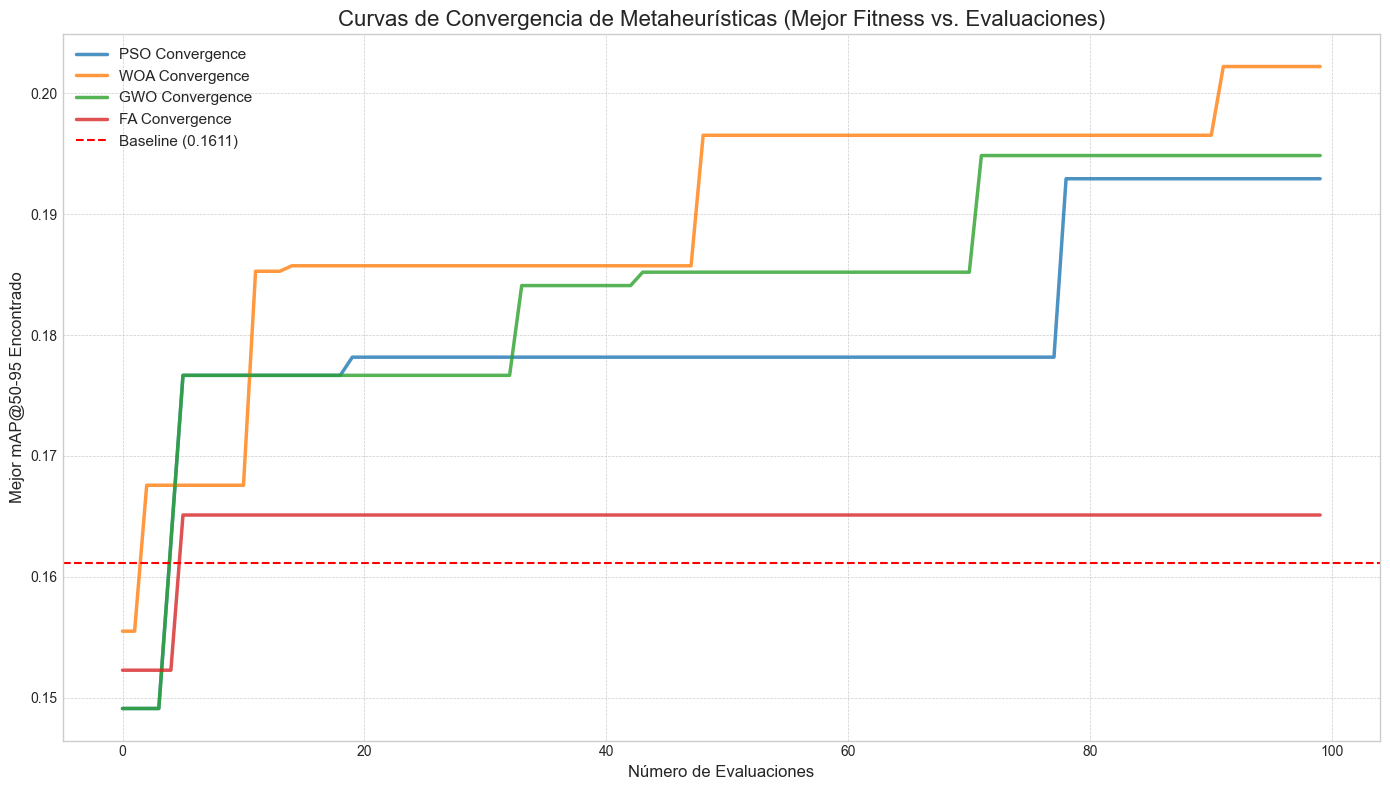

In [11]:
#===================================================================
# Análisis de Resultados de la Ejecución Principal (10x10x5)
#===================================================================

# --- CONFIGURACIÓN ---
algorithms_to_test = ["PSO", "WOA", "GWO", "FA"]
baseline_score = 0.1611 # Reemplaza con el valor exacto de tu ejecución

# Diccionario para guardar los resultados finales (copiados de tu resumen)
final_results = {
    "PSO": {"score": 0.1929, "config": {"lr0": 0.003062, "momentum": 0.925514, "weight_decay": 0.000575, "hsv_s": 0.245831, "scale": 0.488374, "translate": 0.066696}},
    "WOA": {"score": 0.2022, "config": {"lr0": 0.001987, "momentum": 0.850000, "weight_decay": 0.000286, "hsv_s": 0.298415, "scale": 0.385286, "translate": 0.093659}},
    "GWO": {"score": 0.1949, "config": {"lr0": 0.001360, "momentum": 0.850000, "weight_decay": 0.000914, "hsv_s": 0.357341, "scale": 0.122418, "translate": 0.200000}},
    "FA":  {"score": 0.1651, "config": {"lr0": 0.000721, "momentum": 0.905124, "weight_decay": 0.000259, "hsv_s": 0.594327, "scale": 0.033305, "translate": 0.191797}}
}


# --- 1. Mostrar Tabla Comparativa Final ---
print("="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO (10x10x5) ---")
print("="*60)

print(f"\\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 35)

# Crear un DataFrame para una visualización más bonita
summary_data = []
for algo, result in final_results.items():
    improvement = ((result['score'] - baseline_score) / baseline_score) * 100
    summary_data.append([algo, result['score'], f"{improvement:.2f}%"])

summary_df = pd.DataFrame(summary_data, columns=['Algoritmo', 'Mejor mAP@50-95', 'Mejora vs. Baseline'])
print(summary_df.to_string(index=False))


# --- 2. Mostrar la Mejor Configuración General ---
best_overall_algo = max(final_results, key=lambda k: final_results[k]['score'])
best_overall_result = final_results[best_overall_algo]

print("\\n" + "="*60)
print(f"--- MEJOR CONFIGURACIÓN ENCONTRADA (GANADOR: {best_overall_algo}) ---")
print("="*60)
for key, value in best_overall_result['config'].items():
    print(f"  {key}: {value:.6f}")


# --- 3. Generar Gráficos de Convergencia ---
print("\\n\\n" + "="*60)
print("--- GRÁFICOS DE CONVERGENCIA ---")
print("="*60)
analyze_and_plot_results(algorithms_to_test, baseline_score)

In [11]:
#===================================================================
# Ejecución del Estudio de Robustez (Multiples Corridas)
#===================================================================
import pandas as pd
import time
import numpy as np

# --- CONFIGURACIÓN DEL EXPERIMENTO DE ROBUSTEZ ---
algorithms_to_test = ["PSO", "WOA", "GWO", "FA"]
num_runs = 5            # Número de veces que se repetirá todo el experimento
num_particles = 5      # Población para cada algoritmo (mínimo 3 para GWO)
num_iterations = 3      # Iteraciones (más corto que la ejecución principal)
num_epochs = 5          # Épocas por evaluación

# Lista para guardar los resultados de todas las corridas
robustness_results = []

print("INICIANDO ESTUDIO DE ROBUSTEZ\n" + "="*70)

# --- PASO 1: Ejecutar el baseline UNA SOLA VEZ ---
print("Ejecutando Baseline una vez como referencia...")
baseline_score = run_baseline_training(epochs=num_epochs)
print(f"Baseline de Referencia establecido: {baseline_score:.4f}")


# --- BUCLE PRINCIPAL PARA LAS MÚLTIPLES CORRIDAS ---
for run_id in range(num_runs):
    # Genera una semilla diferente para cada corrida para asegurar la independencia
    seed = int(time.time()) + run_id
    np.random.seed(seed)
    print(f"\n\nINICIANDO CORRIDA DE ROBUSTEZ {run_id + 1}/{num_runs} (Semilla: {seed})\n" + "="*70)
    
    # --- Bucle para ejecutar cada metaheurística ---
    for algo_name in algorithms_to_test:
        print(f"\nINICIANDO OPTIMIZACIÓN CON '{algo_name}' (Corrida {run_id + 1})\\n" + "="*50)
        
        current_run_id = run_id + 1  # Para nombrar archivos de resultados únicos
        
        # Ejecuta la optimización para un algoritmo
        best_cfg, best_score, hist = run_metaheuristic(
            name=algo_name, 
            n_particles=num_particles, 
            max_iter=num_iterations,
            epochs=num_epochs,
            run_id=current_run_id
        )
        
        # Guarda el resultado agregado de esta corrida
        robustness_results.append({
            'run_id': run_id + 1,
            'seed': seed,
            'algorithm': algo_name,
            'best_score': best_score,
            'baseline_reference': baseline_score # Usamos el baseline fijo
        })
        print(f"--- Fin de '{algo_name}' (Corrida {run_id + 1}). Mejor score: {best_score:.4f} ---")

# --- GUARDADO FINAL DE LOS DATOS DE ROBUSTEZ ---
# Convertir la lista de resultados a un DataFrame de Pandas
results_df = pd.DataFrame(robustness_results)

# Guardar el DataFrame completo en un archivo CSV para análisis futuro
output_filename = "robustness_study_results.csv"
results_df.to_csv(output_filename, index=False)

INICIANDO ESTUDIO DE ROBUSTEZ
Ejecutando Baseline una vez como referencia...
--- Iniciando Entrenamiento Baseline ---
Entrenando con 5 épocas y tamaño de imagen 640...
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_r

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 158.3109.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\baseline_training\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\baseline_training
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.85G      1.529      3.384      1.174        265        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


                   all        300       2568      0.518      0.162      0.129     0.0758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.436      2.202      1.155        269        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300       2568      0.524      0.208      0.187      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.8G      1.426      1.968      1.151        193        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.553      0.234      0.222      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.71G      1.367      1.825      1.132        131        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.578      0.251      0.253      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.337      1.744      1.113        176        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.589      0.257       0.26      0.161



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\baseline_training\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\baseline_training\weights\best.pt, 6.2MB

Validating runs\detect\baseline_training\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


                   all        300       2568       0.59      0.257       0.26      0.161
               bicycle         30         32      0.127     0.0312     0.0686     0.0205
                   bus        220        425      0.639      0.492      0.571      0.384
                   car        232        842      0.601      0.732      0.713      0.473
               minibus          2          2          1          0    0.00841    0.00673
               minivan         87        110      0.361       0.21      0.265      0.175
             motorbike        166        335      0.403      0.442      0.365     0.0989
                pickup        105        142       0.38      0.164      0.227      0.143
             policecar          1          1          1          0          0          0
              rickshaw         62        192      0.452      0.604      0.578      0.371
               scooter          1          1          1          0          0          0
                   su

val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


                   all        300       2568       0.59      0.257       0.26      0.161
               bicycle         30         32      0.127     0.0312     0.0686     0.0205
                   bus        220        425      0.639      0.492      0.571      0.384
                   car        232        842      0.601      0.732      0.713      0.473
               minibus          2          2          1          0    0.00841    0.00673
               minivan         87        110      0.361       0.21      0.265      0.175
             motorbike        166        335      0.403      0.442      0.365     0.0989
                pickup        105        142       0.38      0.164      0.227      0.143
             policecar          1          1          1          0          0          0
              rickshaw         62        192      0.452      0.604      0.578      0.371
               scooter          1          1          1          0          0          0
                   su

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 231.9153.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: AdamW(lr=0.004352931136823117, momentum=0.9161815406989234) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002822809598069691), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.729       2.71      1.308        295        640: 100%|██████████| 169/169 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.528      0.106     0.0649     0.0285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.701      2.185      1.328        271        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


                   all        300       2568      0.457      0.115     0.0759     0.0378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.662      2.021      1.297        206        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.505      0.175      0.166     0.0884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.2G      1.601      1.842      1.265        121        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.544      0.206      0.206      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.504      1.671       1.21        166        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.552      0.222      0.226      0.135



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


                   all        300       2568      0.549      0.222      0.227      0.135
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.276.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.549      0.222      0.227      0.135
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4530860176174763, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False,

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 169.971.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: AdamW(lr=0.004221369930093712, momentum=0.8879005225781408) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005593036180742866), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.631      2.615      1.303        240        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

                   all        300       2568      0.571     0.0663      0.064     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G      1.603      2.098      1.326        226        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.404       0.12      0.108     0.0561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.35G      1.549      1.909      1.288        155        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.478       0.16      0.142     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.481      1.724      1.256        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.49      0.215       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.383      1.553      1.195        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.549      0.299      0.285       0.17



5 epochs completed in 0.073 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        300       2568      0.549      0.299      0.285       0.17
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train3
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 384.4107.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.549      0.299      0.285       0.17
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train32
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4074242049958148, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 117.5101.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: AdamW(lr=0.0077627009736361725, momentum=0.8660485699894317) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000723068009519013), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.64G      1.804      2.729      1.374        299        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.261        0.1     0.0424     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.807      2.351      1.422        285        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.428      0.108     0.0826     0.0384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.728      2.134      1.365        206        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.495      0.147      0.116     0.0635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.643       1.93       1.32        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.604      0.197      0.205      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.51G      1.548      1.736      1.254        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.647      0.227      0.268       0.16



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.645      0.227      0.268       0.16
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train4
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 301.767.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        300       2568      0.645      0.227      0.268       0.16
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train42
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3890203054012202, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 319.9204.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: AdamW(lr=0.006555777649434076, momentum=0.8846891774769924) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005661688943489255), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.89G      1.751       2.69      1.342        297        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        300       2568       0.11     0.0992      0.042     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.741      2.245      1.378        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


                   all        300       2568      0.487     0.0952      0.105      0.057

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.687      2.037      1.334        209        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.568      0.149      0.146     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.598      1.847      1.281        128        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.499      0.178       0.17     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.508      1.679       1.23        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


                   all        300       2568      0.672      0.222      0.281      0.172

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train5
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 381.798.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train52
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4333164560345189, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 324.8193.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: AdamW(lr=0.0017730961504632482, momentum=0.9183376980423299) with parameter groups 57 weight(decay=0.0), 64 weight(decay=2.9166502799663702e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.558      2.653      1.248        224        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568      0.406      0.156      0.123     0.0653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.479      1.974      1.243        229        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.562      0.139      0.148     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.46G      1.466      1.795      1.227        160        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.461      0.222      0.212      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.397      1.634      1.197        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.528      0.252      0.237      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.325      1.481      1.155        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.527      0.278      0.265      0.157



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.525      0.279      0.265      0.157
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train6
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 271.7103.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


                   all        300       2568      0.525      0.279      0.265      0.157
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train62
  Mejor global hasta ahora: 0.1716
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2166629536289323, hsv

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 245.1140.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: AdamW(lr=0.005352931136823117, momentum=0.8674166435662872) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038228095980696907), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.752      2.692      1.322        297        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.148     0.0522     0.0165    0.00819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.736       2.23      1.371        268        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.624      0.118      0.119     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.39G      1.683      2.024      1.324        209        640: 100%|██████████| 169/169 [00:47<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.527      0.138      0.105     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G      1.607      1.851      1.279        122        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.609      0.222      0.214      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.509      1.674      1.222        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.61      0.246      0.256      0.152



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.609      0.246      0.256      0.152
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train7
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.0137.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.609      0.246      0.256      0.152
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train72
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3830860176174763, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 290.0151.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: AdamW(lr=0.005221369930093712, momentum=0.8839381466409495) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005722618006596115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.665      2.646       1.32        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.419     0.0949     0.0648     0.0335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.637      2.161      1.353        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.369      0.132     0.0884     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.596      1.953      1.314        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.574      0.164      0.138     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G      1.502      1.759      1.273        153        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.566      0.198       0.21      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.416      1.596      1.214        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.586      0.248      0.274      0.162



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 6.2MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.586      0.248      0.274      0.162
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train8
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 403.484.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.586      0.248      0.274      0.162
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train82
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3827395009622439, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 169.1143.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: AdamW(lr=0.0067627009736361725, momentum=0.8682938487442206) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006230680095190129), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train9
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.766      2.704      1.343        296        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.454     0.0931     0.0571     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.87G      1.763       2.28      1.389        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.511      0.103     0.0763      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.705      2.089      1.346        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.421      0.155      0.127     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.43G      1.625       1.89        1.3        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.571      0.207      0.179        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.5G      1.521        1.7      1.234        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.593      0.231      0.248      0.147



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.595       0.23      0.248      0.147
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train9
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 282.092.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.595       0.23      0.248      0.147
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train92
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3890203054012202, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 238.5137.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: AdamW(lr=0.006555777649434076, momentum=0.8846891774769924) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005661688943489255), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.751       2.69      1.342        297        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

                   all        300       2568       0.11     0.0992      0.042     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.741      2.245      1.378        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.487     0.0952      0.105      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.687      2.037      1.334        209        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.568      0.149      0.146     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.598      1.847      1.281        128        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.499      0.178       0.17     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.508      1.679       1.23        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.672      0.222      0.281      0.172



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 6.2MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train10
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 277.893.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train102
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41087677007401524, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 306.7166.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: AdamW(lr=0.0027730961504632483, momentum=0.907482044782454) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001291665027996637), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.594      2.624      1.265        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.333     0.0997     0.0597     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.54      2.022      1.279        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.515      0.157      0.152     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.72G      1.515      1.836      1.253        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.578      0.191      0.205      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.38G      1.435      1.662      1.218        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.518      0.262      0.234      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.359      1.507      1.174        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.55      0.259       0.27      0.159



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 6.2MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.522      0.272      0.269      0.159
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train11
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 250.632.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


                   all        300       2568      0.522      0.272      0.269      0.159
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train112
  Mejor global hasta ahora: 0.1716
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2866629536289323, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.7160.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: AdamW(lr=0.006352931136823117, momentum=0.8632781640267434) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048228095980696906), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.89G      1.776      2.717      1.343        300        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.367      0.112     0.0375      0.018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.763      2.275       1.39        269        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.525      0.115      0.105     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.725       2.09      1.347        209        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.407       0.19      0.152     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G       1.62      1.876      1.292        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.463      0.212      0.193      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G       1.53       1.71      1.236        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.61      0.222      0.255      0.146



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 6.2MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.611      0.223      0.255      0.146
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train12
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 381.899.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.611      0.223      0.255      0.146
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train122
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4005267326631087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.91.9 ms, read: 281.3210.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: AdamW(lr=0.006221369930093712, momentum=0.8894223945511122) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005439936763812569), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train13
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.73G      1.697      2.665      1.342        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.274      0.109     0.0563     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.669      2.193      1.375        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.411      0.141      0.119     0.0588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G       1.62      1.975      1.337        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.54      0.135      0.141     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.529      1.793      1.282        140        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.53      0.182      0.187      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.439      1.625      1.229        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.556      0.265      0.268      0.161

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 6.2MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.557      0.265      0.268      0.161
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train13
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 367.8111.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.557      0.265      0.268      0.161
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train132
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.379831667642772, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 230.5113.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: AdamW(lr=0.006976744430233996, momentum=0.8675342464982247) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005230680095190129), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train14
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.769      2.697      1.359        294        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.427     0.0742     0.0541     0.0284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.754      2.274       1.39        278        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.426      0.115     0.0936     0.0475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.39G      1.702       2.08      1.346        206        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.418      0.161      0.133     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G      1.603      1.866      1.293        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.615      0.198      0.208       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.51G      1.518      1.687      1.234        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.619      0.249      0.257      0.152



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 6.2MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.622      0.246      0.257      0.152
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train14
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.3148.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.622      0.246      0.257      0.152
Speed: 0.7ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train142
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3890203054012202, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 283.9176.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: AdamW(lr=0.006555777649434076, momentum=0.8846891774769924) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005661688943489255), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train15
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.89G      1.751       2.69      1.342        297        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


                   all        300       2568       0.11     0.0992      0.042     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.741      2.245      1.378        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.487     0.0952      0.105      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.687      2.037      1.334        209        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


                   all        300       2568      0.568      0.149      0.146     0.0763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.598      1.847      1.281        128        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.499      0.178       0.17     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.508      1.679       1.23        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.672      0.222      0.281      0.172

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 6.2MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train15
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 321.442.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.671      0.223      0.281      0.172
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train152
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3855928510400435, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.81.5 ms, read: 225.390.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: AdamW(lr=0.0037730961504632483, momentum=0.8932533848453444) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00022916650279966371), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train16
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.626      2.619      1.285        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.379      0.121     0.0811     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.587      2.088      1.313        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.332      0.172      0.111     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.68G      1.557      1.897      1.288        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.519      0.186      0.168     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.472       1.71      1.243        143        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.588      0.222      0.233      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.392      1.554      1.194        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.595      0.274      0.293       0.18



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 6.2MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.596      0.275      0.294       0.18
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train16
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.1130.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.596      0.275      0.294       0.18
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train162
  Mejor global hasta ahora: 0.1801
  Historial guardado en: PSO_run1_results.json
--- Fin de 'PSO' (Corrida 1). Mejor score: 0.1801 ---

INICIANDO OPTIMIZACIÓN CON 'WOA' (Corrida 1)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 88.920.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: AdamW(lr=0.0016737988780906453, momentum=0.8643487683513597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006566732598758082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train17
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.566       2.62      1.245        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.371      0.153     0.0984     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.48      1.964      1.239        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.525      0.149      0.152     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.49G      1.453      1.755      1.217        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.607      0.212      0.202      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.386      1.589      1.184        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.463      0.247      0.241      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.318       1.45      1.145        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.608      0.281       0.27      0.166



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 6.2MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train17
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 382.8101.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train172
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06726888552577415, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 141.980.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: AdamW(lr=0.008227832975494558, momentum=0.862623165853098) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008381069625913052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train18
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.861      2.849      1.419        277        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        300       2568      0.398     0.0788      0.039     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.873      2.474      1.468        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.418      0.097     0.0723      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.796      2.266      1.409        200        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.623      0.128       0.13     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.71      2.048      1.358        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.443      0.153      0.163     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.605      1.855      1.292        152        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.547      0.204      0.219      0.123



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 6.2MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train18
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 350.086.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train182
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.02743145457802447, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 257.2142.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: AdamW(lr=0.009769934773084337, momentum=0.928629917566856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007395243158189034), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train19
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.761      2.742      1.406        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        300       2568      0.191      0.112     0.0484     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G      1.736      2.312      1.446        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.515      0.112     0.0972     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.675      2.117      1.399        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.612      0.152      0.143     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.592      1.912       1.35        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.58       0.21      0.209      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.488      1.734      1.284        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.525      0.237       0.24      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 6.2MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train19
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 371.3124.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train192
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.28998409616026893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 285.7212.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: AdamW(lr=0.0030317879554692347, momentum=0.8654346034640517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003186651962145821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train20
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.596      2.601       1.28        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.478     0.0782     0.0731      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.55      2.031      1.296        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.542      0.159      0.127     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.509      1.847      1.262        150        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.594      0.179      0.187      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.433      1.658      1.222        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.515      0.242      0.235       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.35        1.5      1.172        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.635      0.268      0.327      0.209



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 6.2MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train20
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.372.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train202
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06575835753090917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.6127.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train21\labels.jpg... 
optimizer: AdamW(lr=0.005709354396645095, momentum=0.8845006338221278) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000523724805413233), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train21
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.714       2.67      1.331        274        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.494     0.0677     0.0574     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.69       2.18      1.358        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.374     0.0872     0.0754     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.646      1.999      1.321        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.501      0.164      0.139     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.559       1.81      1.278        126        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.534      0.206      0.208      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.638      1.222        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.652      0.226      0.275      0.165



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train21\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train21\weights\best.pt, 6.2MB

Validating runs\detect\train21\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train21
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.4103.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train212
  Mejor global hasta ahora: 0.2088
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11942386742757749, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.5161.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train22
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.924      3.003       1.49        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.179        0.1     0.0294     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.918      2.564      1.517        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.325     0.0782      0.024     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.876      2.411      1.489        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.313       0.14     0.0913     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.786      2.279      1.425        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.453      0.157      0.133     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.725      2.127      1.384        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.466      0.163      0.147     0.0808



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train22
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 387.292.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train222
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4566447956433786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 133.9123.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train23\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8675384389293519) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train23
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.545      3.057      1.225        232        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568        0.4     0.0752     0.0602     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.449      2.367      1.201        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.549      0.176      0.143     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.96G      1.418      2.105      1.183        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.58      0.201      0.182       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G       1.37      1.961      1.166        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.616      0.207      0.205      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.356      1.897      1.152        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568       0.62      0.212      0.205      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train23\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train23\weights\best.pt, 6.2MB

Validating runs\detect\train23\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train23
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 320.8106.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train232
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033863285170319224, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 185.2111.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: AdamW(lr=0.009604868375063223, momentum=0.9270818030550895) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007292144040838529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train24
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.752      2.724      1.398        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.296     0.0744     0.0583     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G       1.74      2.297      1.443        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.414     0.0526     0.0378     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.672      2.095      1.389        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.458       0.16      0.141     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.573      1.895      1.333        148        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.586      0.206       0.19      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.487      1.723      1.276        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.542      0.227      0.236      0.136



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 6.2MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train24
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 367.593.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train242
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35305623924902696, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 276.3163.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: AdamW(lr=0.003691208131520697, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038797553812362594), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train25
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.797      1.329        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.414      0.186     0.0854     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.59      2.191      1.342        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568       0.46      0.178      0.128     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.16G      1.573      2.008      1.319        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.471      0.171      0.146     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.42G      1.501      1.857      1.284        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.523      0.191       0.18        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.446      1.736      1.239        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.612      0.228      0.224       0.13



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 6.2MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train25
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 287.386.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train252
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23343147776938417, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 230.4124.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train26\labels.jpg... 
optimizer: AdamW(lr=0.0037071046880159716, momentum=0.8702433018126904) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003703838699818444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train26
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.615      2.618      1.294        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568     0.0304      0.174     0.0502     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G       1.58      2.069      1.312        226        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.463      0.141      0.118     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.536      1.875       1.28        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.425      0.229      0.172     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.464      1.686      1.243        146        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568       0.57      0.252      0.253      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.375      1.523      1.188        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.588      0.258      0.311      0.192



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train26\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train26\weights\best.pt, 6.2MB

Validating runs\detect\train26\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train26
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 338.4118.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.13it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train262
  Mejor global hasta ahora: 0.2088
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6023957432479364, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 269.6172.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train27\labels.jpg... 
optimizer: AdamW(lr=0.0066029881406099115, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006606689716818878), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train27
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.825      2.894      1.388        293        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

                   all        300       2568      0.231     0.0975     0.0284     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G        1.8      2.381      1.413        283        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.37      0.109     0.0727     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.783      2.249      1.396        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.336      0.156      0.114     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.71      2.117      1.351        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.449      0.158      0.161     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.4G      1.638      1.977      1.305        173        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.509      0.186      0.175     0.0984



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train27\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train27\weights\best.pt, 6.2MB

Validating runs\detect\train27\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train27
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 395.894.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train272
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16526971911763777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 270.1190.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: AdamW(lr=0.005225683154645994, momentum=0.8638602759215124) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005563782094018443), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train28
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.659      2.619      1.318        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.388     0.0854     0.0549     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.64      2.144      1.359        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.409      0.106     0.0942     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.586       1.95      1.319        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.536      0.176      0.155     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.492      1.753      1.268        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.607      0.211      0.217      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.399      1.573      1.206        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.589       0.26      0.281      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 6.2MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train28
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 345.5105.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train282
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.040137553284785965, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.3157.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: AdamW(lr=0.009443845657967022, momentum=0.9255716131675704) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007191570573403475), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train29
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.753       2.74      1.399        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568      0.332      0.119     0.0669     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.731       2.29      1.441        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.428      0.118     0.0769      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.657      2.086      1.384        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568        0.6      0.117      0.124     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.577      1.896      1.336        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.609        0.2      0.199       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.482      1.712      1.269        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.555        0.2      0.234      0.138



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 6.2MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train29
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 371.994.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train292
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32096039578336294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.5127.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train30\labels.jpg... 
optimizer: AdamW(lr=0.003355645619892315, momentum=0.9708128063280062) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003527052305754299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train30
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.621      2.744      1.302        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.368      0.161     0.0904     0.0466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G      1.564       2.11      1.314        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.515      0.161      0.142     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.539      1.915      1.287        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.554      0.138      0.164     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.474      1.782      1.258        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.521      0.209      0.196      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.408      1.649      1.208        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.59      0.218      0.242      0.143



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train30\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train30\weights\best.pt, 6.2MB

Validating runs\detect\train30\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train30
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 400.4100.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train302
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2757207976361348, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 318.2183.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train31\labels.jpg... 
optimizer: AdamW(lr=0.0032021115307293594, momentum=0.8666474191039054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003317093116632431), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train31
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.602      2.613      1.282        234        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


                   all        300       2568      0.306     0.0756     0.0595     0.0324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.56      2.053      1.304        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.475      0.115      0.103     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.516      1.854      1.267        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.472      0.142      0.149     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.445      1.674       1.23        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.448      0.249      0.235      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.359      1.501       1.18        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.602       0.25      0.292       0.18



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train31\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train31\weights\best.pt, 6.2MB

Validating runs\detect\train31\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train31
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 363.7104.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train312
  Mejor global hasta ahora: 0.2088
  Historial guardado en: WOA_run1_results.json
--- Fin de 'WOA' (Corrida 1). Mejor score: 0.2088 ---

INICIANDO OPTIMIZACIÓN CON 'GWO' (Corrida 1)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 311.5180.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train33\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train33
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568       0.28      0.116     0.0588     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.385      0.147      0.103     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.471      0.152      0.142     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.533      0.207      0.205      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train33\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train33\weights\best.pt, 6.2MB

Validating runs\detect\train33\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train33
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 309.571.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train332
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 219.5227.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train34\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train34
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        300       2568      0.264     0.0911     0.0477      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568       0.55      0.182      0.201       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.615      0.211      0.215      0.124



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train34\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train34\weights\best.pt, 6.2MB

Validating runs\detect\train34\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train34
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 297.8111.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train342
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 289.6184.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train35\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train35
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.335      0.126     0.0571      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.457      0.129       0.11     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.591      0.128      0.131     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.526      0.217      0.192      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train35\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train35\weights\best.pt, 6.2MB

Validating runs\detect\train35\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train35
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 333.9146.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train352
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 277.4170.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train36\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train36
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.341       0.11     0.0665     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.434      0.164      0.111     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.469      0.134      0.117     0.0632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.52      0.224      0.222      0.127



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train36\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train36\weights\best.pt, 6.2MB

Validating runs\detect\train36\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train36
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 394.191.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train362
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 280.8147.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train37\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train37
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


                   all        300       2568      0.399      0.146      0.121     0.0683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.569       0.17      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.05G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.649      0.202      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568       0.55      0.257      0.239       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.507      0.282      0.271      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train37\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train37\weights\best.pt, 6.2MB

Validating runs\detect\train37\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train37
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 395.689.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train372
  Mejor global hasta ahora: 0.1628
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36001674472807105, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 3.88.3 ms, read: 242.5127.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train38\labels.jpg... 
optimizer: AdamW(lr=0.002785517340865242, momentum=0.8514068843621785) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train38
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G        1.6      2.616      1.272        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.416     0.0993     0.0928     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.545       2.02      1.279        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.476      0.167      0.142     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.519      1.835      1.256        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.533      0.171      0.166     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.46G      1.441       1.65       1.22        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.586      0.262      0.236      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.366      1.494       1.17        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.61      0.265      0.283      0.172



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train38\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train38\weights\best.pt, 6.2MB

Validating runs\detect\train38\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train38
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 287.079.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train382
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08039511060804809, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 184.0137.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train39\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009515481091563142), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train39
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      3.054       1.22        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.45      0.104     0.0861      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.455      2.368      1.193        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.531      0.167      0.131     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.75G      1.432      2.114      1.181        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.584      0.192      0.177      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.386      1.978      1.167        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.606      0.215      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.37      1.913      1.152        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.613        0.2      0.202      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train39\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train39\weights\best.pt, 6.2MB

Validating runs\detect\train39\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train39
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 391.689.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train392
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35885080007781384, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 186.6156.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train40\labels.jpg... 
optimizer: AdamW(lr=0.0018708744117709912, momentum=0.8930204440478606) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043099641721402153), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train40
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G        1.6      2.645       1.24        272        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.389      0.188      0.107      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.523      1.995      1.236        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568       0.45      0.154      0.151     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.07G      1.502      1.804       1.22        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.571      0.199      0.202      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G       1.44       1.64      1.193        129        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.491       0.24      0.233      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.38      1.511      1.155        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.623      0.269        0.3      0.178



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train40\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train40\weights\best.pt, 6.2MB

Validating runs\detect\train40\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train40
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.8147.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train402
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 248.6104.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train41\labels.jpg... 
optimizer: AdamW(lr=0.005057168406342748, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005350317966300188), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train41
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.672      2.804      1.345        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.264      0.138     0.0566     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.646      2.264      1.376        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.473      0.153     0.0899     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.611      2.082      1.349        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.471      0.163      0.139     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.543       1.93      1.315        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.589      0.177      0.184      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.478      1.787      1.267        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.527      0.212       0.22      0.131



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train41\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train41\weights\best.pt, 6.2MB

Validating runs\detect\train41\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train41
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 374.084.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train412
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5617758588607087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 310.2172.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train43\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033988125044140133), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train43
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.612      3.257      1.243        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.323     0.0901     0.0578     0.0331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.506      2.598      1.212        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.367      0.146      0.108       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.483      2.327      1.204        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568       0.47       0.17      0.136     0.0804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.435      2.185      1.194        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.502       0.18      0.161     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.42      2.108      1.175        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.585      0.188      0.174      0.106



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train43\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train43\weights\best.pt, 6.2MB

Validating runs\detect\train43\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train43
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 353.597.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train432
  Mejor global hasta ahora: 0.1779
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4762443622669177, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 271.4166.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train44\labels.jpg... 
optimizer: AdamW(lr=0.002857638514130382, momentum=0.8515531947800512) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train44
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.597      2.617      1.269        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568       0.31     0.0895     0.0719     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.546      2.011      1.284        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568      0.424      0.176      0.146     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G       1.52      1.838      1.259        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.458      0.191      0.183      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G       1.44      1.653      1.221        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.596      0.244      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.364        1.5      1.171        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.615      0.276      0.271      0.166



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train44\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train44\weights\best.pt, 6.2MB

Validating runs\detect\train44\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train44
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 349.3123.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train442
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965165033662836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 260.0128.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train45\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002917033958957783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train45
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.56      3.064      1.215        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.425     0.0864     0.0766     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.469      2.361      1.192        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.523      0.194      0.141     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.457      2.122      1.187        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.606      0.185      0.182      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.405      1.991      1.166        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.625      0.193      0.202      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.388      1.922      1.152        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.626      0.199      0.206      0.126



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train45\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train45\weights\best.pt, 6.2MB

Validating runs\detect\train45\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train45
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 391.596.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train452
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6604117838910161, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 178.9107.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train46\labels.jpg... 
optimizer: AdamW(lr=0.0011429359039805468, momentum=0.8703922589243076) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004088711999424598), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train46
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.549      2.691      1.232        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.732     0.0969      0.114     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.464      1.969      1.219        248        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.543      0.163      0.169     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.44      1.771      1.205        160        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.494      0.195      0.197      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.379       1.61      1.175        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.54      0.274      0.259      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.326       1.48      1.138        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.515      0.303      0.274      0.166



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train46\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train46\weights\best.pt, 6.2MB

Validating runs\detect\train46\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train46
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 325.084.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train462
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 170.472.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train47\labels.jpg... 
optimizer: AdamW(lr=0.0035575492530464277, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005799921341459309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train47
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.811      1.321        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.396       0.11     0.0565     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.599      2.226      1.336        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.465      0.163      0.133     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.576      2.014      1.321        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.502      0.144      0.148     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.518      1.891       1.29        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.51      0.204      0.184      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.449      1.747      1.239        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.638      0.223      0.232      0.139



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train47\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train47\weights\best.pt, 6.2MB

Validating runs\detect\train47\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train47
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 314.8123.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train472
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5829762077689215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.3116.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train48\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000525066619786226), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train48
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.595      3.248       1.24        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.201      0.113     0.0707     0.0378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.495      2.613      1.216        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.431      0.159      0.108     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.474      2.334       1.21        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.464      0.175       0.14     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.425        2.2      1.198        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.499      0.183      0.161     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.414      2.119      1.175        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.52      0.187      0.174      0.105



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train48\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train48\weights\best.pt, 6.2MB

Validating runs\detect\train48\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train48
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 312.573.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train482
  Mejor global hasta ahora: 0.1779
  Historial guardado en: GWO_run1_results.json
--- Fin de 'GWO' (Corrida 1). Mejor score: 0.1779 ---

INICIANDO OPTIMIZACIÓN CON 'FA' (Corrida 1)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 278.2149.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train49\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train49
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train49\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train49\weights\best.pt, 6.2MB

Validating runs\detect\train49\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train49
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 291.554.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train492
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21836149683572129, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 218.4120.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train50\labels.jpg... 
optimizer: AdamW(lr=0.005402764749947088, momentum=0.9266882969260942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007303919074872529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train50
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.672      2.643      1.318        248        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.343      0.107     0.0706      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.648       2.15      1.352        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.405      0.129      0.122     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.609      1.957      1.325        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.571      0.167      0.155     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.74G      1.532      1.797      1.281        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.608      0.205       0.22      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.443      1.629      1.227        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.615      0.235      0.249      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train50\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train50\weights\best.pt, 6.2MB

Validating runs\detect\train50\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train50
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 403.491.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train502
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34332116603229695, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 224.4185.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train51\labels.jpg... 
optimizer: AdamW(lr=0.0019433107582153282, momentum=0.9727684106979113) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007398112442542384), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train51
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.59       2.79      1.275        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.321      0.171      0.109     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.505      2.084      1.255        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.477      0.172      0.147     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.491      1.876      1.238        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.528      0.199       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.432      1.738      1.215        156        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.556      0.227      0.222      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.383      1.615      1.182        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.578      0.232      0.235      0.142



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train51\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train51\weights\best.pt, 6.2MB

Validating runs\detect\train51\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train51
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.173.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train512
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4874404421708216, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.8194.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train53\labels.jpg... 
optimizer: AdamW(lr=0.0006744886872063687, momentum=0.9064741613225556) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003124840861121085), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train53
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.556      2.789      1.224        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.449      0.185      0.127     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.457      2.011      1.204        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.589        0.2      0.183      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.424      1.777      1.188        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.548      0.223      0.217      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.367      1.635      1.166        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.504      0.251      0.249       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.32      1.521      1.136        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.508      0.264      0.267      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train53\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train53\weights\best.pt, 6.2MB

Validating runs\detect\train53\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train53
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 309.865.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train532
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3175877911892317, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 178.171.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train54\labels.jpg... 
optimizer: AdamW(lr=0.0003443194110741792, momentum=0.8587424520902223) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006797133807250689), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train54
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.579       2.88      1.216        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.505      0.137     0.0984     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.475      2.096      1.188        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.552      0.168      0.169     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.443      1.872       1.18        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.632      0.219      0.225      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.386      1.719      1.159        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.568      0.249      0.242      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.359      1.633      1.137        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.493      0.267      0.257      0.157



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train54\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train54\weights\best.pt, 6.2MB

Validating runs\detect\train54\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train54
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 404.392.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train542
  Mejor global hasta ahora: 0.1630
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hsv

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 237.0117.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train55\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train55
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train55\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train55\weights\best.pt, 6.2MB

Validating runs\detect\train55\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train55
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 368.299.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.94it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train552
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 225.9121.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train56\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train56
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train56\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train56\weights\best.pt, 6.2MB

Validating runs\detect\train56\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train56
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 322.7128.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train562
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 160.7121.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train57\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.8823391096842635) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train57
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.773       2.75      1.416        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.229     0.0938     0.0348     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.769      2.382      1.463        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.316      0.113     0.0932     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.706      2.148      1.408        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.465      0.138      0.131     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G        1.6      1.942      1.354        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.537      0.189      0.194       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.498      1.738      1.283        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.627      0.223       0.25      0.146



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train57\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train57\weights\best.pt, 6.2MB

Validating runs\detect\train57\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train57
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 318.565.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train572
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0359396801800147, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 247.4137.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train58\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train58
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.908      2.915      1.464        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.166      0.107     0.0276     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.936      2.571      1.527        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.509      0.107     0.0777     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.845      2.353       1.46        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.291      0.141     0.0614     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.738      2.136      1.387        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.504      0.151      0.161      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.643      1.938      1.329        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.642      0.204      0.212       0.12

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train58\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train58\weights\best.pt, 6.2MB

Validating runs\detect\train58\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train58
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 392.0112.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train582
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.18427904059834033, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.194.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train59\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train59
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.568      3.249      1.241        218        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.345     0.0754      0.066     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.473      2.591      1.215        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


                   all        300       2568      0.514       0.15      0.114     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.446      2.314      1.198        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.555      0.164      0.144     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.403      2.166      1.188        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.51      0.179      0.162      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.383      2.084      1.165        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.583      0.183      0.177      0.109



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train59\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train59\weights\best.pt, 6.2MB

Validating runs\detect\train59\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train59
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 277.683.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train592
  Mejor global hasta ahora: 0.1630
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hsv

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 254.9160.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train60\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train60
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568       0.62      0.203      0.203      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568       0.51      0.269      0.254      0.151

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train60\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train60\weights\best.pt, 6.2MB

Validating runs\detect\train60\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train60
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 411.197.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train602
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 279.5148.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train61\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train61
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train61\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train61\weights\best.pt, 6.2MB

Validating runs\detect\train61\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train61
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.775.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train612
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.1 ms, read: 210.0156.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train63\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9592542337017913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train63
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.876      2.859      1.441        291        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.188     0.0831     0.0383     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.853      2.443      1.471        286        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.262     0.0753     0.0417     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.813      2.285      1.448        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.468      0.137      0.117     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.19G      1.716      2.115      1.386        113        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.603      0.163      0.167     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.635      1.942       1.33        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.595      0.188      0.195      0.109



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train63\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train63\weights\best.pt, 6.2MB

Validating runs\detect\train63\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train63
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 254.082.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train632
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 234.9133.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train64\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train64
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        300       2568      0.365      0.149      0.132     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


                   all        300       2568       0.63      0.192      0.201      0.114

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train64\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train64\weights\best.pt, 6.2MB

Validating runs\detect\train64\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train64
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 232.580.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train642
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 202.7184.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train65\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train65
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.1G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568      0.488      0.186      0.157      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train65\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train65\weights\best.pt, 6.2MB

Validating runs\detect\train65\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train65
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 354.591.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train652
  Mejor global hasta ahora: 0.1630
  Historial guardado en: FA_run1_results.json
--- Fin de 'FA' (Corrida 1). Mejor score: 0.1630 ---


INICIANDO CORRIDA DE ROBUSTEZ 2/5 (Semilla: 1762768404)

INICIANDO OPTIMIZACIÓN CON 'PSO' (Corrida 2)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, d

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 198.0120.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train66\labels.jpg... 
optimizer: AdamW(lr=0.005975403997971559, momentum=0.8635032376186508) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014099560707022982), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train66
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.754      2.683      1.334        302        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300       2568      0.284      0.102     0.0684     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.734      2.223      1.372        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.539      0.102     0.0869     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.682      2.028      1.322        209        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.498      0.144      0.144     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.597      1.845      1.278        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.52      0.209      0.185      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.503      1.662      1.222        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.649      0.225      0.255      0.152



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train66\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train66\weights\best.pt, 6.2MB

Validating runs\detect\train66\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.649      0.224      0.255      0.152
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train66
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 359.2138.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.649      0.224      0.255      0.152
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train662
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5195539835228644, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 165.348.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train67\labels.jpg... 
optimizer: AdamW(lr=0.007122733001456954, momentum=0.9230747379048468) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00012368898088590665), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train67
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G       1.74      2.685      1.342        275        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


                   all        300       2568      0.276     0.0962     0.0443     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.738      2.263      1.388        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.419      0.121     0.0775     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.36G      1.693      2.077      1.348        199        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.618      0.164      0.142     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.597      1.884      1.299        127        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.533      0.221      0.211      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.506      1.705      1.241        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.482      0.239      0.255      0.161



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train67\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train67\weights\best.pt, 6.2MB

Validating runs\detect\train67\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.481       0.24      0.253       0.16
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train67
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 339.1120.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


                   all        300       2568      0.481       0.24      0.253       0.16
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train672
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6560280047936474, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 280.2153.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train68\labels.jpg... 
optimizer: AdamW(lr=0.00303862347402624, momentum=0.9006583184548836) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005977966483442811), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train68
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G      1.625       2.64      1.264        261        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.291      0.157      0.094     0.0528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G       1.58      2.063      1.282        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.381      0.134     0.0949     0.0481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.557      1.886      1.261        200        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.577       0.19       0.18     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.483      1.706      1.229        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.497      0.266      0.232       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.412      1.558       1.18        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.623      0.272      0.273      0.158



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train68\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train68\weights\best.pt, 6.2MB

Validating runs\detect\train68\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.624      0.271      0.273      0.158
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train68
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.758.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.624      0.271      0.273      0.158
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train682
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.22713444809794656, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 173.9105.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train69\labels.jpg... 
optimizer: AdamW(lr=0.009252975291111559, momentum=0.9096304430118313) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00015202591518333213), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train69
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G       1.87      2.842      1.417        283        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


                   all        300       2568      0.174      0.167      0.038     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.889      2.479      1.486        275        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568      0.264     0.0683     0.0602     0.0267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.822      2.293      1.442        203        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.516       0.11        0.1     0.0473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G       1.72      2.085      1.373        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.603      0.149      0.157     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G       1.63      1.898      1.314        154        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.616      0.188      0.212      0.122



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train69\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train69\weights\best.pt, 6.2MB

Validating runs\detect\train69\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.616      0.188      0.212      0.122
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train69
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 394.489.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.616      0.188      0.212      0.122
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train692
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41371622581565115, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.678.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train70\labels.jpg... 
optimizer: AdamW(lr=0.004482040355558315, momentum=0.8675886234543064) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003131162991889763), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train70
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.633      2.614      1.311        230        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.283     0.0676      0.037     0.0165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.19G      1.616      2.126      1.346        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.503      0.156      0.135     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.564      1.924      1.306        156        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.427      0.173      0.159     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.472      1.738      1.259        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.606      0.221      0.233      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.381      1.552      1.201        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568      0.577      0.265      0.276      0.159

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train70\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train70\weights\best.pt, 6.2MB

Validating runs\detect\train70\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.577      0.265      0.276      0.159
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train70
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.2114.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.577      0.265      0.276      0.159
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train702
  Mejor global hasta ahora: 0.1601
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08559545154195268, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 245.8183.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train71\labels.jpg... 
optimizer: AdamW(lr=0.0065824686515765, momentum=0.9557477625220769) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00012520676050317657), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train71
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.64G      1.771      2.753      1.348        299        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.253      0.104     0.0411       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G       1.75      2.244       1.38        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.503     0.0847     0.0779     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.713      2.095      1.356        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.544      0.154      0.142     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.627      1.923      1.313        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.588      0.174      0.176     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.542      1.761      1.258        173        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.608       0.23      0.232      0.134



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train71\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train71\weights\best.pt, 6.2MB

Validating runs\detect\train71\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.608       0.23      0.232      0.134
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train71
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 347.081.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]


                   all        300       2568      0.608       0.23      0.232      0.134
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train712
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5195539835228644, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 145.9116.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train73\labels.jpg... 
optimizer: AdamW(lr=0.007122733001456954, momentum=0.9230747379048468) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00012368898088590665), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train73
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G       1.74      2.685      1.342        275        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568      0.276     0.0962     0.0443     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.738      2.263      1.388        279        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        300       2568      0.419      0.121     0.0775     0.0401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.36G      1.693      2.077      1.348        199        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.618      0.164      0.142     0.0762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.597      1.884      1.299        127        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300       2568      0.533      0.221      0.211      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.506      1.705      1.241        183        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.482      0.239      0.255      0.161



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train73\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train73\weights\best.pt, 6.2MB

Validating runs\detect\train73\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


                   all        300       2568      0.481       0.24      0.253       0.16
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train73
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 323.593.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.02it/s]


                   all        300       2568      0.481       0.24      0.253       0.16
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train732
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5860280047936475, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 225.9123.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train74\labels.jpg... 
optimizer: AdamW(lr=0.00403862347402624, momentum=0.9033583973221108) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000497796648344281), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train74
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.662      2.651      1.284        268        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        300       2568      0.423      0.102     0.0715     0.0381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.632       2.12      1.314        280        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568       0.33      0.133     0.0992       0.05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.599       1.93      1.288        201        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.528      0.167      0.159     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.516       1.75      1.248        130        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568        0.5      0.216      0.229      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.434      1.589      1.193        184        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.524      0.294       0.28      0.162



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train74\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train74\weights\best.pt, 6.2MB

Validating runs\detect\train74\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


                   all        300       2568      0.524      0.294       0.28      0.162
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train74
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.883.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


                   all        300       2568      0.524      0.294       0.28      0.162
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train742
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29713444809794654, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 225.4123.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train75\labels.jpg... 
optimizer: AdamW(lr=0.008252975291111558, momentum=0.9194101127324685) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00011971065834346082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train75
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.836      2.791       1.39        297        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        300       2568      0.296     0.0731     0.0357     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.841      2.405      1.443        279        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300       2568      0.431      0.101     0.0795     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.765      2.205      1.394        204        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568      0.433      0.136      0.118      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.678      2.006      1.339        115        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.494      0.215      0.192      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G       1.59      1.829      1.277        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.556      0.224      0.231      0.133



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train75\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train75\weights\best.pt, 6.2MB

Validating runs\detect\train75\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.556      0.224      0.231      0.133
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train75
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 369.0106.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.556      0.224      0.231      0.133
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train752
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.46733185633340557, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 163.589.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train76\labels.jpg... 
optimizer: AdamW(lr=0.005482040355558315, momentum=0.8854895001969633) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00021311629918897628), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train76
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.4G      1.654      2.638      1.327        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.201     0.0938     0.0336     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.647      2.194      1.374        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.338      0.115     0.0992     0.0515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.592       1.98      1.325        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.599      0.169      0.166     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G      1.502      1.779      1.279        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.487      0.185      0.178        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.417      1.605      1.223        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.654      0.232      0.266      0.154



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train76\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train76\weights\best.pt, 6.2MB

Validating runs\detect\train76\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.653      0.233      0.266      0.154
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train76
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 360.1116.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        300       2568      0.653      0.233      0.266      0.154
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train762
  Mejor global hasta ahora: 0.1620
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15559545154195267, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 203.696.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train77\labels.jpg... 
optimizer: AdamW(lr=0.0055824686515765, momentum=0.857747762522077) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00022520676050317659), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train77
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.731      2.661      1.324        299        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.325      0.134     0.0588     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.715      2.196      1.348        275        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.468       0.13      0.112     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.676      2.012      1.319        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.635      0.159      0.168     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.01G      1.581      1.824      1.273        122        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.633      0.203      0.216      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.498      1.652       1.22        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.562      0.246      0.257       0.15



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train77\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train77\weights\best.pt, 6.2MB

Validating runs\detect\train77\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.562      0.246      0.257       0.15
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train77
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 382.581.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.562      0.246      0.257       0.15
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train772
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5895539835228644, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 187.671.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train78\labels.jpg... 
optimizer: AdamW(lr=0.006122733001456954, momentum=0.8987473763059441) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00022368898088590667), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train78
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.85G      1.724      2.668       1.33        272        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.212      0.128     0.0641      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.701      2.205       1.37        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.534      0.103     0.0927     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.09G      1.651      2.001      1.333        200        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.762      0.135      0.167       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.71G      1.565      1.818      1.283        129        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.552      0.215      0.229      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.651      1.224        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.559      0.248      0.256       0.15



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train78\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train78\weights\best.pt, 6.2MB

Validating runs\detect\train78\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.558      0.248      0.256       0.15
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train78
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 343.471.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.558      0.248      0.256       0.15
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train782
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5416946714603141, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 231.5125.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train79\labels.jpg... 
optimizer: AdamW(lr=0.004671956807359573, momentum=0.9050684472713546) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004344633150109477), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train79
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.85G      1.687      2.651      1.309        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.522      0.067     0.0619     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.66      2.142       1.34        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.495     0.0813     0.0828     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.34G      1.626      1.957      1.309        198        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.605      0.155      0.154     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.537      1.777      1.266        127        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.557      0.224      0.224      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.455      1.621       1.21        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.599      0.244      0.263       0.15



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train79\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train79\weights\best.pt, 6.2MB

Validating runs\detect\train79\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.599      0.244      0.263      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train79
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 368.188.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.599      0.244      0.263      0.151
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train792
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36713444809794654, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 205.9128.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train80\labels.jpg... 
optimizer: AdamW(lr=0.007252975291111558, momentum=0.9139275399818332) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00021971065834346082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train80
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.793      2.753      1.367        301        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.642     0.0528     0.0344     0.0185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.773      2.306      1.398        284        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.503      0.109     0.0869     0.0441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.723       2.13      1.355        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568       0.49      0.135       0.11     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.638      1.937      1.313        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.445        0.2       0.18     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.51G      1.547      1.754      1.251        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.637      0.205      0.224      0.129



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train80\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train80\weights\best.pt, 6.2MB

Validating runs\detect\train80\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.637      0.205      0.224      0.129
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train80
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 336.389.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.637      0.205      0.224      0.129
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train802
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.46011985840929714, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 278.4140.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train81\labels.jpg... 
optimizer: AdamW(lr=0.0052758323653398975, momentum=0.8796812738391293) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003131162991889763), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train81
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.659      2.652      1.329        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.305     0.0776     0.0326     0.0164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.65      2.171      1.366        225        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.461       0.14      0.114     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.45G      1.595      1.979      1.321        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.583      0.162      0.153     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.27G      1.512      1.774      1.279        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.613      0.211      0.223      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.413      1.602      1.214        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.589      0.252      0.272      0.158



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train81\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train81\weights\best.pt, 6.2MB

Validating runs\detect\train81\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.589      0.253      0.272      0.158
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train81
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 369.592.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.589      0.253      0.272      0.158
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train812
  Mejor global hasta ahora: 0.1620
  Historial guardado en: PSO_run2_results.json
--- Fin de 'PSO' (Corrida 2). Mejor score: 0.1620 ---

INICIANDO OPTIMIZACIÓN CON 'WOA' (Corrida 2)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 273.6215.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train83\labels.jpg... 
optimizer: AdamW(lr=0.0016737988780906453, momentum=0.8643487683513597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006566732598758082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train83
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.566       2.62      1.245        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


                   all        300       2568      0.371      0.153     0.0984     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.48      1.964      1.239        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.525      0.149      0.152     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.49G      1.453      1.755      1.217        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.607      0.212      0.202      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.386      1.589      1.184        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.463      0.247      0.241      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.318       1.45      1.145        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.608      0.281       0.27      0.166



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train83\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train83\weights\best.pt, 6.2MB

Validating runs\detect\train83\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train83
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 300.356.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train832
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06726888552577415, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 269.0160.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train84\labels.jpg... 
optimizer: AdamW(lr=0.008227832975494558, momentum=0.862623165853098) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008381069625913052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train84
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.861      2.849      1.419        277        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all        300       2568      0.398     0.0788      0.039     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.873      2.474      1.468        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.418      0.097     0.0723      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.796      2.266      1.409        200        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.623      0.128       0.13     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.71      2.048      1.358        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.443      0.153      0.163     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.605      1.855      1.292        152        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.547      0.204      0.219      0.123



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train84\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train84\weights\best.pt, 6.2MB

Validating runs\detect\train84\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train84
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.9132.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train842
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.02743145457802447, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 188.470.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train85\labels.jpg... 
optimizer: AdamW(lr=0.009769934773084337, momentum=0.928629917566856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007395243158189034), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train85
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.761      2.742      1.406        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        300       2568      0.191      0.112     0.0484     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G      1.736      2.312      1.446        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.515      0.112     0.0972     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.675      2.117      1.399        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.612      0.152      0.143     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.592      1.912       1.35        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.58       0.21      0.209      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.488      1.734      1.284        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.525      0.237       0.24      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train85\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train85\weights\best.pt, 6.2MB

Validating runs\detect\train85\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train85
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 325.4100.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train852
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.28998409616026893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 216.4211.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train86\labels.jpg... 
optimizer: AdamW(lr=0.0030317879554692347, momentum=0.8654346034640517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003186651962145821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train86
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.596      2.601       1.28        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


                   all        300       2568      0.478     0.0782     0.0731      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.55      2.031      1.296        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.542      0.159      0.127     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.509      1.847      1.262        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.594      0.179      0.187      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.433      1.658      1.222        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.515      0.242      0.235       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.35        1.5      1.172        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.635      0.268      0.327      0.209



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train86\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train86\weights\best.pt, 6.2MB

Validating runs\detect\train86\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train86
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 292.379.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train862
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06575835753090917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 306.5181.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train87\labels.jpg... 
optimizer: AdamW(lr=0.005709354396645095, momentum=0.8845006338221278) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000523724805413233), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train87
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.714       2.67      1.331        274        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.494     0.0677     0.0574     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.69       2.18      1.358        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.374     0.0872     0.0754     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.646      1.999      1.321        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.501      0.164      0.139     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.559       1.81      1.278        126        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.534      0.206      0.208      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.638      1.222        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.652      0.226      0.275      0.165



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train87\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train87\weights\best.pt, 6.2MB

Validating runs\detect\train87\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train87
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 296.586.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train872
  Mejor global hasta ahora: 0.2088
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11942386742757749, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 242.5135.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train88\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train88
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.924      3.003       1.49        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.179        0.1     0.0294     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.918      2.564      1.517        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.325     0.0782      0.024     0.0106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.876      2.411      1.489        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.313       0.14     0.0913     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.786      2.279      1.425        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.453      0.157      0.133     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.725      2.127      1.384        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.466      0.163      0.147     0.0808



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train88\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train88\weights\best.pt, 6.2MB

Validating runs\detect\train88\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train88
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.134.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train882
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4566447956433786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 255.1135.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train89\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8675384389293519) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train89
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.545      3.057      1.225        232        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568        0.4     0.0752     0.0602     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.449      2.367      1.201        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.549      0.176      0.143     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.418      2.105      1.183        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.58      0.201      0.182       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G       1.37      1.961      1.166        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.616      0.207      0.205      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.356      1.897      1.152        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.62      0.212      0.205      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train89\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train89\weights\best.pt, 6.2MB

Validating runs\detect\train89\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train89
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.134.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train892
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033863285170319224, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 240.6144.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train90\labels.jpg... 
optimizer: AdamW(lr=0.009604868375063223, momentum=0.9270818030550895) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007292144040838529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train90
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.752      2.724      1.398        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.296     0.0744     0.0583     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G       1.74      2.297      1.443        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.414     0.0526     0.0378     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.672      2.095      1.389        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.458       0.16      0.141     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.573      1.895      1.333        148        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.586      0.206       0.19      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.487      1.723      1.276        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.542      0.227      0.236      0.136

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train90\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train90\weights\best.pt, 6.2MB

Validating runs\detect\train90\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train90
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 355.084.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train902
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35305623924902696, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 166.541.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train91\labels.jpg... 
optimizer: AdamW(lr=0.003691208131520697, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038797553812362594), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train91
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.797      1.329        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.414      0.186     0.0854     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.59      2.191      1.342        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568       0.46      0.178      0.128     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.16G      1.573      2.008      1.319        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.471      0.171      0.146     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.42G      1.501      1.857      1.284        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.523      0.191       0.18        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.446      1.736      1.239        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.612      0.228      0.224       0.13



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train91\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train91\weights\best.pt, 6.2MB

Validating runs\detect\train91\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train91
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 375.886.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train912
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23343147776938417, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 130.772.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train93\labels.jpg... 
optimizer: AdamW(lr=0.0037071046880159716, momentum=0.8702433018126904) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003703838699818444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train93
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.615      2.618      1.294        239        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568     0.0304      0.174     0.0502     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G       1.58      2.069      1.312        226        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.463      0.141      0.118     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.536      1.875       1.28        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.425      0.229      0.172     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.464      1.686      1.243        146        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568       0.57      0.252      0.253      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.375      1.523      1.188        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.588      0.258      0.311      0.192



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train93\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train93\weights\best.pt, 6.2MB

Validating runs\detect\train93\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train93
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 327.286.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train932
  Mejor global hasta ahora: 0.2088
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6023957432479364, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 249.1135.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train94\labels.jpg... 
optimizer: AdamW(lr=0.0066029881406099115, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006606689716818878), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train94
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.825      2.894      1.388        293        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

                   all        300       2568      0.231     0.0975     0.0284     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G        1.8      2.381      1.413        283        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.37      0.109     0.0727     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.783      2.249      1.396        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.336      0.156      0.114     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.71      2.117      1.351        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.449      0.158      0.161     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.638      1.977      1.305        173        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.509      0.186      0.175     0.0984



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train94\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train94\weights\best.pt, 6.2MB

Validating runs\detect\train94\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train94
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 301.667.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train942
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16526971911763777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 177.895.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train95\labels.jpg... 
optimizer: AdamW(lr=0.005225683154645994, momentum=0.8638602759215124) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005563782094018443), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train95
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.659      2.619      1.318        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.388     0.0854     0.0549     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.64      2.144      1.359        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.409      0.106     0.0942     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.586       1.95      1.319        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.536      0.176      0.155     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.492      1.753      1.268        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.607      0.211      0.217      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.399      1.573      1.206        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


                   all        300       2568      0.589       0.26      0.281      0.164

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train95\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train95\weights\best.pt, 6.2MB

Validating runs\detect\train95\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train95
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.7117.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train952
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.040137553284785965, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 196.0111.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train96\labels.jpg... 
optimizer: AdamW(lr=0.009443845657967022, momentum=0.9255716131675704) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007191570573403475), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train96
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.753       2.74      1.399        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.332      0.119     0.0669     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.731       2.29      1.441        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


                   all        300       2568      0.428      0.118     0.0769      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.657      2.086      1.384        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568        0.6      0.117      0.124     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.577      1.896      1.336        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.609        0.2      0.199       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.482      1.712      1.269        165        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.555        0.2      0.234      0.138



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train96\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train96\weights\best.pt, 6.2MB

Validating runs\detect\train96\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train96
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 289.073.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train962
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32096039578336294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.560.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train97\labels.jpg... 
optimizer: AdamW(lr=0.003355645619892315, momentum=0.9708128063280062) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003527052305754299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train97
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.621      2.744      1.302        233        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        300       2568      0.368      0.161     0.0904     0.0466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G      1.564       2.11      1.314        230        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568      0.515      0.161      0.142     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.539      1.915      1.287        150        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568      0.554      0.138      0.164     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.474      1.782      1.258        163        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.521      0.209      0.196      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.408      1.649      1.208        182        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568       0.59      0.218      0.242      0.143



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train97\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train97\weights\best.pt, 6.2MB

Validating runs\detect\train97\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train97
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 341.899.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train972
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2757207976361348, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 154.7130.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train98\labels.jpg... 
optimizer: AdamW(lr=0.0032021115307293594, momentum=0.8666474191039054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003317093116632431), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train98
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.602      2.613      1.282        234        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.306     0.0756     0.0595     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.56      2.053      1.304        228        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.475      0.115      0.103     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.516      1.854      1.267        151        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.472      0.142      0.149     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.445      1.674       1.23        162        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.448      0.249      0.235      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.359      1.501       1.18        180        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.602       0.25      0.292       0.18



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train98\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train98\weights\best.pt, 6.2MB

Validating runs\detect\train98\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train98
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 361.978.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train982
  Mejor global hasta ahora: 0.2088
  Historial guardado en: WOA_run2_results.json
--- Fin de 'WOA' (Corrida 2). Mejor score: 0.2088 ---

INICIANDO OPTIMIZACIÓN CON 'GWO' (Corrida 2)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 214.994.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train99\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train99
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:58<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300       2568       0.28      0.116     0.0588     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.385      0.147      0.103     0.0533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.471      0.152      0.142     0.0783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.533      0.207      0.205      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.556      0.232      0.252      0.149

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train99\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train99\weights\best.pt, 6.2MB

Validating runs\detect\train99\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train99
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.9104.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train992
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.270.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train100\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train100
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:59<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

                   all        300       2568      0.264     0.0911     0.0477      0.023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:57<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568       0.55      0.182      0.201       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.615      0.211      0.215      0.124

5 epochs completed in 0.085 hours.
Optimizer stripped from runs\detect\train100\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train100\weights\best.pt, 6.2MB

Validating runs\detect\train100\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train100
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.067.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train1002
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 120.8129.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train101\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train101
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:57<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.335      0.126     0.0571      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.457      0.129       0.11     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.591      0.128      0.131     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.526      0.217      0.192      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train101\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train101\weights\best.pt, 6.2MB

Validating runs\detect\train101\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train101
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 208.146.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train1012
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 225.9121.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train103\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train103
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:58<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.341       0.11     0.0665     0.0312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.434      0.164      0.111     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.469      0.134      0.117     0.0632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568       0.52      0.224      0.222      0.127

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train103\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train103\weights\best.pt, 6.2MB

Validating runs\detect\train103\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train103
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 269.063.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1032
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 143.930.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train104\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train104
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


                   all        300       2568      0.399      0.146      0.121     0.0683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568      0.569       0.17      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.05G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.649      0.202      0.216      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568       0.55      0.257      0.239       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.507      0.282      0.271      0.163



5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train104\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train104\weights\best.pt, 6.2MB

Validating runs\detect\train104\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train104
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.360.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.75it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1042
  Mejor global hasta ahora: 0.1628
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36001674472807105, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.2 ms, read: 256.8137.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train105\labels.jpg... 
optimizer: AdamW(lr=0.002785517340865242, momentum=0.8514068843621785) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train105
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G        1.6      2.616      1.272        244        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.416     0.0993     0.0928     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.545       2.02      1.279        233        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all        300       2568      0.476      0.167      0.142     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.519      1.835      1.256        166        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all        300       2568      0.533      0.171      0.166     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.46G      1.441       1.65       1.22        135        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.586      0.262      0.236      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.366      1.494       1.17        170        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568       0.61      0.265      0.283      0.172

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train105\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train105\weights\best.pt, 6.2MB

Validating runs\detect\train105\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train105
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 260.9101.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1052
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08039511060804809, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 141.278.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train106\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009515481091563142), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train106
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      3.054       1.22        243        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568       0.45      0.104     0.0861      0.048

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.455      2.368      1.193        227        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.531      0.167      0.131     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.75G      1.432      2.114      1.181        161        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.584      0.192      0.177      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.386      1.978      1.167        149        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        300       2568      0.606      0.215      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.37      1.913      1.152        171        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.613        0.2      0.202      0.124

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train106\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train106\weights\best.pt, 6.2MB

Validating runs\detect\train106\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train106
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 331.284.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1062
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35885080007781384, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 133.544.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train107\labels.jpg... 
optimizer: AdamW(lr=0.0018708744117709912, momentum=0.8930204440478606) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043099641721402153), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train107
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G        1.6      2.645       1.24        272        640: 100%|██████████| 169/169 [00:58<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.389      0.188      0.107      0.058

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.523      1.995      1.236        277        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568       0.45      0.154      0.151     0.0838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.07G      1.502      1.804       1.22        199        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.571      0.199      0.202      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G       1.44       1.64      1.193        129        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.491       0.24      0.233      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.38      1.511      1.155        184        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.623      0.269        0.3      0.178

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train107\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train107\weights\best.pt, 6.2MB

Validating runs\detect\train107\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train107
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 344.380.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1072
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 199.479.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train108\labels.jpg... 
optimizer: AdamW(lr=0.005057168406342748, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005350317966300188), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train108
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.672      2.804      1.345        236        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.264      0.138     0.0566     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.646      2.264      1.376        239        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300       2568      0.473      0.153     0.0899     0.0463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.611      2.082      1.349        155        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        300       2568      0.471      0.163      0.139     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.543       1.93      1.315        166        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.589      0.177      0.184      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.478      1.787      1.267        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        300       2568      0.527      0.212       0.22      0.131



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train108\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train108\weights\best.pt, 6.2MB

Validating runs\detect\train108\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train108
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.376.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1082
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5617758588607087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 220.3103.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train109\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033988125044140133), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train109
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.612      3.257      1.243        242        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568      0.323     0.0901     0.0578     0.0331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.506      2.598      1.212        241        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.367      0.146      0.108       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.483      2.327      1.204        184        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568       0.47       0.17      0.136     0.0804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.435      2.185      1.194        137        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        300       2568      0.502       0.18      0.161     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.42      2.108      1.175        177        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        300       2568      0.585      0.188      0.174      0.106



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train109\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train109\weights\best.pt, 6.2MB

Validating runs\detect\train109\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train109
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.396.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1092
  Mejor global hasta ahora: 0.1779
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4762443622669177, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 212.2125.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train110\labels.jpg... 
optimizer: AdamW(lr=0.002857638514130382, momentum=0.8515531947800512) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train110
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.597      2.617      1.269        241        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568       0.31     0.0895     0.0719     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.546      2.011      1.284        231        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.424      0.176      0.146     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G       1.52      1.838      1.259        162        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        300       2568      0.458      0.191      0.183      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G       1.44      1.653      1.221        134        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        300       2568      0.596      0.244      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.364        1.5      1.171        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        300       2568      0.615      0.276      0.271      0.166



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train110\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train110\weights\best.pt, 6.2MB

Validating runs\detect\train110\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train110
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 179.846.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1102
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965165033662836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 234.1116.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train111\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002917033958957783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train111
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.56      3.064      1.215        244        640: 100%|██████████| 169/169 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.425     0.0864     0.0766     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.469      2.361      1.192        251        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.523      0.194      0.141     0.0839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.457      2.122      1.187        183        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.606      0.185      0.182      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.405      1.991      1.166        132        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.625      0.193      0.202      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.388      1.922      1.152        179        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.626      0.199      0.206      0.126

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train111\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train111\weights\best.pt, 6.2MB

Validating runs\detect\train111\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train111
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 287.776.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1112
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6604117838910161, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 273.0158.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train113\labels.jpg... 
optimizer: AdamW(lr=0.0011429359039805468, momentum=0.8703922589243076) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004088711999424598), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train113
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.549      2.691      1.232        240        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.732     0.0969      0.114     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.464      1.969      1.219        248        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.543      0.163      0.169     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G       1.44      1.771      1.205        160        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.494      0.195      0.197      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.379       1.61      1.175        130        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568       0.54      0.274      0.259      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.326       1.48      1.138        181        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        300       2568      0.515      0.303      0.274      0.166



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train113\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train113\weights\best.pt, 6.2MB

Validating runs\detect\train113\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\train113
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.191.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.44it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1132
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 175.0103.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train114\labels.jpg... 
optimizer: AdamW(lr=0.0035575492530464277, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005799921341459309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train114
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.811      1.321        233        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.396       0.11     0.0565     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.599      2.226      1.336        232        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.465      0.163      0.133     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.576      2.014      1.321        151        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568      0.502      0.144      0.148     0.0788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.518      1.891       1.29        151        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568       0.51      0.204      0.184      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.449      1.747      1.239        184        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568      0.638      0.223      0.232      0.139

5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train114\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train114\weights\best.pt, 6.2MB

Validating runs\detect\train114\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train114
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 191.344.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1142
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5829762077689215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.9139.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train115\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000525066619786226), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train115
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.595      3.248       1.24        241        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.201      0.113     0.0707     0.0378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.495      2.613      1.216        240        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.431      0.159      0.108     0.0618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.474      2.334       1.21        161        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.464      0.175       0.14     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.425        2.2      1.198        132        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.499      0.183      0.161     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.414      2.119      1.175        182        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568       0.52      0.187      0.174      0.105

5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train115\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train115\weights\best.pt, 6.2MB

Validating runs\detect\train115\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train115
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 316.1112.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1152
  Mejor global hasta ahora: 0.1779
  Historial guardado en: GWO_run2_results.json
--- Fin de 'GWO' (Corrida 2). Mejor score: 0.1779 ---

INICIANDO OPTIMIZACIÓN CON 'FA' (Corrida 2)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 267.9158.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train116\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train116
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.498      0.239      0.225      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train116\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train116\weights\best.pt, 6.2MB

Validating runs\detect\train116\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train116
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 341.382.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1162
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21836149683572129, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.5124.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train117\labels.jpg... 
optimizer: AdamW(lr=0.005402764749947088, momentum=0.9266882969260942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007303919074872529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train117
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.672      2.643      1.318        248        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        300       2568      0.343      0.107     0.0706      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.648       2.15      1.352        244        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.405      0.129      0.122     0.0604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.609      1.957      1.325        180        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.571      0.167      0.155     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.74G      1.532      1.797      1.281        136        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.608      0.205       0.22      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.443      1.629      1.227        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        300       2568      0.615      0.235      0.249      0.143



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train117\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train117\weights\best.pt, 6.2MB

Validating runs\detect\train117\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train117
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 322.278.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1172
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34332116603229695, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 151.253.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train118\labels.jpg... 
optimizer: AdamW(lr=0.0019433107582153282, momentum=0.9727684106979113) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007398112442542384), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train118
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.59       2.79      1.275        242        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.321      0.171      0.109     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.505      2.084      1.255        231        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568      0.477      0.172      0.147     0.0827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.491      1.876      1.238        163        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        300       2568      0.528      0.199       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.432      1.738      1.215        156        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

                   all        300       2568      0.556      0.227      0.222      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.383      1.615      1.182        165        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.578      0.232      0.235      0.142

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train118\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train118\weights\best.pt, 6.2MB

Validating runs\detect\train118\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train118
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 329.3116.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1182
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4874404421708216, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 222.1109.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train119\labels.jpg... 
optimizer: AdamW(lr=0.0006744886872063687, momentum=0.9064741613225556) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003124840861121085), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train119
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.556      2.789      1.224        244        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        300       2568      0.449      0.185      0.127     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.457      2.011      1.204        239        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568      0.589        0.2      0.183      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.424      1.777      1.188        178        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.548      0.223      0.217      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.367      1.635      1.166        137        640: 100%|██████████| 169/169 [00:57<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.504      0.251      0.249       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.32      1.521      1.136        167        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

                   all        300       2568      0.508      0.264      0.267      0.163



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train119\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train119\weights\best.pt, 6.2MB

Validating runs\detect\train119\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train119
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.988.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.5ms preprocess, 3.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1192
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3175877911892317, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 147.266.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train120\labels.jpg... 
optimizer: AdamW(lr=0.0003443194110741792, momentum=0.8587424520902223) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006797133807250689), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train120
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.579       2.88      1.216        269        640: 100%|██████████| 169/169 [01:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.505      0.137     0.0984     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.475      2.096      1.188        279        640: 100%|██████████| 169/169 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.552      0.168      0.169     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.443      1.872       1.18        199        640: 100%|██████████| 169/169 [00:57<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.632      0.219      0.225      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.386      1.719      1.159        130        640: 100%|██████████| 169/169 [01:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.568      0.249      0.242      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.359      1.633      1.137        184        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568      0.493      0.267      0.257      0.157

5 epochs completed in 0.088 hours.
Optimizer stripped from runs\detect\train120\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train120\weights\best.pt, 6.2MB

Validating runs\detect\train120\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train120
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 239.327.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1202
  Mejor global hasta ahora: 0.1630
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 261.5120.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train121\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train121
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.551      0.152      0.131     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:57<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568       0.51      0.269      0.254      0.151

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train121\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train121\weights\best.pt, 6.2MB

Validating runs\detect\train121\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train121
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 346.990.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.00it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1212
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.2126.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train123\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train123
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

                   all        300       2568      0.158      0.159     0.0223    0.00836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train123\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train123\weights\best.pt, 6.2MB

Validating runs\detect\train123\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train123
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 323.791.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train1232
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 173.9153.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train124\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.8823391096842635) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train124
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.773       2.75      1.416        243        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


                   all        300       2568      0.229     0.0938     0.0348     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.769      2.382      1.463        251        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.316      0.113     0.0932     0.0467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.706      2.148      1.408        167        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.465      0.138      0.131     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G        1.6      1.942      1.354        132        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


                   all        300       2568      0.537      0.189      0.194       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.498      1.738      1.283        181        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        300       2568      0.627      0.223       0.25      0.146

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train124\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train124\weights\best.pt, 6.2MB

Validating runs\detect\train124\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train124
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 364.888.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1242
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0359396801800147, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 204.3147.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train125\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train125
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.908      2.915      1.464        273        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        300       2568      0.166      0.107     0.0276     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.936      2.571      1.527        257        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


                   all        300       2568      0.509      0.107     0.0777     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.845      2.353       1.46        196        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.291      0.141     0.0614     0.0278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.738      2.136      1.387        103        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568      0.504      0.151      0.161      0.089

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.643      1.938      1.329        151        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.642      0.204      0.212       0.12

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train125\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train125\weights\best.pt, 6.2MB

Validating runs\detect\train125\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train125
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 262.755.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.84it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1252
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.18427904059834033, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 234.8122.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train126\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train126
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.568      3.249      1.241        218        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.345     0.0754      0.066     0.0386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.473      2.591      1.215        227        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.514       0.15      0.114     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.446      2.314      1.198        163        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        300       2568      0.555      0.164      0.144     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.403      2.166      1.188        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568       0.51      0.179      0.162      0.097

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.383      2.084      1.165        172        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        300       2568      0.583      0.183      0.177      0.109



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train126\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train126\weights\best.pt, 6.2MB

Validating runs\detect\train126\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train126
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 240.681.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1262
  Mejor global hasta ahora: 0.1630
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 249.0134.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train127\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train127
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.551      0.152      0.131     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568       0.62      0.203      0.203      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.498      0.239      0.225      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568       0.51      0.269      0.254      0.151

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train127\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train127\weights\best.pt, 6.2MB

Validating runs\detect\train127\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train127
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.337.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.75it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1272
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 171.079.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train128\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train128
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [03:42<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881

5 epochs completed in 0.129 hours.
Optimizer stripped from runs\detect\train128\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train128\weights\best.pt, 6.2MB

Validating runs\detect\train128\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs\detect\train128
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.289.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1282
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.8118.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train129\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9592542337017913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train129
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.876      2.859      1.441        291        640: 100%|██████████| 169/169 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.188     0.0831     0.0383     0.0177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.853      2.443      1.471        286        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.262     0.0753     0.0417     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.813      2.285      1.448        204        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568      0.468      0.137      0.117     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.19G      1.716      2.115      1.386        113        640: 100%|██████████| 169/169 [01:17<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568      0.603      0.163      0.167     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.4G      1.635      1.942       1.33        179        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        300       2568      0.595      0.188      0.195      0.109



5 epochs completed in 0.089 hours.
Optimizer stripped from runs\detect\train129\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train129\weights\best.pt, 6.2MB

Validating runs\detect\train129\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train129
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 364.284.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.73it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train1292
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 241.9151.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train130\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train130
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.369       0.11     0.0716     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train130\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train130\weights\best.pt, 6.2MB

Validating runs\detect\train130\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train130
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 193.041.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1302
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.586.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train131\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train131
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568       0.37      0.157      0.106     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.536      0.176      0.143     0.0847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568      0.567      0.188      0.169      0.103

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train131\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train131\weights\best.pt, 6.2MB

Validating runs\detect\train131\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train131
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 242.234.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train1312
  Mejor global hasta ahora: 0.1630
  Historial guardado en: FA_run2_results.json
--- Fin de 'FA' (Corrida 2). Mejor score: 0.1630 ---


INICIANDO CORRIDA DE ROBUSTEZ 3/5 (Semilla: 1762790648)

INICIANDO OPTIMIZACIÓN CON 'PSO' (Corrida 3)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 193.880.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train133\labels.jpg... 
optimizer: AdamW(lr=0.002764810795575338, momentum=0.9128268773718279) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009525179520539105), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train133
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.64G      1.714      2.798      1.302        277        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.408      0.138     0.0794      0.042

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.674      2.189      1.311        272        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.548      0.118       0.11      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.649      2.031      1.293        203        640: 100%|██████████| 169/169 [01:21<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.449      0.148      0.136     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.1G       1.58      1.848      1.254        106        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.481      0.245       0.22      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.14G        1.5      1.691      1.201        154        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.684      0.215      0.242      0.147



5 epochs completed in 0.086 hours.
Optimizer stripped from runs\detect\train133\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train133\weights\best.pt, 6.2MB

Validating runs\detect\train133\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300       2568      0.679      0.216      0.241      0.147
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train133
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 335.294.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


                   all        300       2568      0.679      0.216      0.241      0.147
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1332
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5520795297333052, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 249.4165.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train134\labels.jpg... 
optimizer: AdamW(lr=0.007643653203635738, momentum=0.8902976374307122) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005354707008793407), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train134
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.05G      1.738      2.684      1.359        254        640: 100%|██████████| 169/169 [00:57<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        300       2568      0.335     0.0984     0.0507     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.727      2.275      1.401        259        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        300       2568      0.555     0.0965     0.0761     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G       1.67      2.061      1.354        185        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        300       2568      0.594       0.13      0.109      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.89G       1.57      1.863      1.306        133        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        300       2568       0.56      0.207      0.181     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.479      1.677      1.245        179        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.644       0.23      0.261      0.149

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train134\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train134\weights\best.pt, 6.2MB

Validating runs\detect\train134\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


                   all        300       2568      0.644       0.23      0.261      0.149
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train134
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.369.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


                   all        300       2568      0.644       0.23      0.261      0.149
Speed: 2.7ms preprocess, 5.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1342
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20563174555946553, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 190.0114.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train135\labels.jpg... 
optimizer: AdamW(lr=0.0070158338258850435, momentum=0.8813657643477237) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006280928314125719), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train135
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.704       2.68       1.36        241        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.199     0.0647     0.0392     0.0171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.691      2.217      1.402        226        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        300       2568      0.467     0.0948     0.0946     0.0481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G      1.619      2.023      1.351        161        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300       2568      0.564       0.13      0.138     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.533      1.809      1.299        148        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

                   all        300       2568       0.62      0.186      0.197      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.437       1.64      1.237        173        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.615      0.221      0.269       0.16



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train135\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train135\weights\best.pt, 6.2MB

Validating runs\detect\train135\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


                   all        300       2568      0.611      0.225      0.268       0.16
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train135
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 324.151.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


                   all        300       2568      0.611      0.225      0.268       0.16
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1352
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34733272938186616, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 210.1153.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train136\labels.jpg... 
optimizer: AdamW(lr=0.002257168505879638, momentum=0.8821803178348773) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004495844158288558), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train136
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G      1.591      2.614      1.253        240        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.305        0.1     0.0781     0.0426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.531      1.995      1.257        252        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.502      0.153       0.14     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.501      1.808      1.234        172        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.542      0.189      0.188      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.432      1.642      1.206        132        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

                   all        300       2568      0.643       0.23      0.247      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.361      1.486      1.162        181        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        300       2568      0.603      0.258      0.286      0.174



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train136\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train136\weights\best.pt, 6.2MB

Validating runs\detect\train136\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train136
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 244.534.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1362
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4108444754950397, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 251.3169.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train137\labels.jpg... 
optimizer: AdamW(lr=0.007854601621663413, momentum=0.8684837279598502) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007506742230337716), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train137
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.814      2.771      1.386        294        640: 100%|██████████| 169/169 [01:25<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300       2568      0.168     0.0937     0.0248     0.0114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.797      2.353       1.42        283        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.398        0.1     0.0718     0.0372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.744      2.167      1.374        206        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        300       2568      0.496      0.153       0.15      0.079

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.88G      1.651      1.957      1.326        122        640: 100%|██████████| 169/169 [01:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        300       2568      0.572      0.183      0.163     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.5G      1.552      1.759      1.257        177        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.608      0.213      0.223       0.13

5 epochs completed in 0.097 hours.
Optimizer stripped from runs\detect\train137\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train137\weights\best.pt, 6.2MB

Validating runs\detect\train137\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.608      0.214      0.223       0.13
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train137
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 208.448.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]


                   all        300       2568      0.608      0.214      0.223       0.13
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1372
  Mejor global hasta ahora: 0.1736
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3441692154737929, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 142.992.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train138\labels.jpg... 
optimizer: AdamW(lr=0.0024962115622140573, momentum=0.8653716796543106) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008525179520539104), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train138
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.64G      1.707      2.778      1.291        283        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.414      0.148     0.0685     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.655      2.169      1.296        279        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568      0.544      0.156      0.137     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.635      1.992      1.282        207        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568       0.52      0.193      0.173     0.0936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.561       1.81      1.242        106        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.456      0.228      0.204      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.14G      1.489      1.654      1.194        158        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.645      0.251      0.268      0.159



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train138\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train138\weights\best.pt, 6.2MB

Validating runs\detect\train138\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


                   all        300       2568      0.645      0.251      0.268      0.159
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train138
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 273.961.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.07it/s]


                   all        300       2568      0.645      0.251      0.268      0.159
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train1382
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4820795297333052, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 194.7130.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train139\labels.jpg... 
optimizer: AdamW(lr=0.006643653203635738, momentum=0.8802819365863758) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004354707008793407), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train139
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.707      2.652      1.348        243        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.373      0.151     0.0921     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.695      2.212      1.387        247        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        300       2568      0.424       0.12     0.0913     0.0445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.638      2.016      1.343        185        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.474      0.162      0.129     0.0651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.57G      1.547      1.817      1.297        133        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

                   all        300       2568      0.535      0.202      0.211      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.454      1.642      1.233        179        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568      0.657      0.226      0.258      0.147

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train139\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train139\weights\best.pt, 6.2MB

Validating runs\detect\train139\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.657      0.226      0.258      0.147
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train139
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 316.877.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


                   all        300       2568      0.657      0.226      0.258      0.147
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train1392
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2756317455594655, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 212.2140.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train140\labels.jpg... 
optimizer: AdamW(lr=0.0060158338258850435, momentum=0.881463878083586) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005280928314125719), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train140
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G       1.69      2.659      1.343        242        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.323       0.11     0.0513     0.0257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.659      2.208       1.38        228        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.477      0.122      0.102     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.617      1.991      1.333        162        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        300       2568      0.481      0.151      0.139     0.0778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.524       1.79      1.286        136        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.504      0.204      0.206      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.43      1.612      1.227        170        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.553      0.266      0.276      0.163

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train140\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train140\weights\best.pt, 6.2MB

Validating runs\detect\train140\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        300       2568      0.553      0.266      0.275      0.163
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train140
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 257.756.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        300       2568      0.553      0.266      0.275      0.163
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1402
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34733272938186616, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 170.776.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train141\labels.jpg... 
optimizer: AdamW(lr=0.002257168505879638, momentum=0.8821803178348773) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004495844158288558), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train141
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G      1.591      2.614      1.253        240        640: 100%|██████████| 169/169 [00:58<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.305        0.1     0.0781     0.0426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.531      1.995      1.257        252        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.502      0.153       0.14     0.0743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.501      1.808      1.234        172        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


                   all        300       2568      0.542      0.189      0.188      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.432      1.642      1.206        132        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.643       0.23      0.247      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.361      1.486      1.162        181        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.603      0.258      0.286      0.174

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train141\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train141\weights\best.pt, 6.2MB

Validating runs\detect\train141\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train141
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 368.389.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train1412
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3786704915888287, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 203.2111.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train143\labels.jpg... 
optimizer: AdamW(lr=0.006854601621663413, momentum=0.8729025085786685) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006506742230337715), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train143
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.61G      1.764      2.699      1.353        278        640: 100%|██████████| 169/169 [00:57<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.192     0.0778     0.0324     0.0165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.83G      1.752      2.261      1.392        291        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.562     0.0796     0.0753      0.037

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.38G      1.696      2.073      1.347        204        640: 100%|██████████| 169/169 [00:57<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.567      0.158      0.144     0.0735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.603      1.879      1.296        123        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.561      0.197      0.195      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.507        1.7      1.233        185        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        300       2568      0.638      0.248      0.252      0.145



5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train143\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train143\weights\best.pt, 6.2MB

Validating runs\detect\train143\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


                   all        300       2568      0.638      0.248      0.252      0.145
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train143
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.755.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.638      0.248      0.252      0.145
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1432
  Mejor global hasta ahora: 0.1736
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3034323795465935, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 224.5100.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train144\labels.jpg... 
optimizer: AdamW(lr=0.002199618350242753, momentum=0.8613443490056929) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007525179520539104), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train144
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.694      2.748      1.281        290        640: 100%|██████████| 169/169 [00:56<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.435      0.137      0.104     0.0574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.633      2.138      1.283        281        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.493      0.152      0.144     0.0745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.612      1.956      1.268        207        640: 100%|██████████| 169/169 [00:58<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.615       0.16      0.173     0.0938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G      1.536      1.777      1.229        108        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all        300       2568       0.49      0.245      0.225      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G       1.47      1.626       1.18        164        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568      0.649      0.229      0.269      0.164

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train144\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train144\weights\best.pt, 6.2MB

Validating runs\detect\train144\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        300       2568      0.649      0.229      0.269      0.164
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train144
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 341.977.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.649      0.229      0.269      0.164
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1442
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4120795297333052, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 144.377.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train145\labels.jpg... 
optimizer: AdamW(lr=0.005643653203635738, momentum=0.8941444744412019) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005354707008793407), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train145
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.82G      1.689      2.638      1.328        251        640: 100%|██████████| 169/169 [00:58<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


                   all        300       2568      0.154      0.145     0.0622     0.0346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.666      2.167      1.355        262        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.455       0.13      0.105      0.055

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.626      1.987      1.322        187        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.622      0.143      0.131     0.0661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.58G      1.537      1.784      1.276        131        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        300       2568      0.523      0.198      0.195      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.45      1.616      1.223        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.603      0.233       0.25      0.146

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train145\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train145\weights\best.pt, 6.2MB

Validating runs\detect\train145\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


                   all        300       2568      0.603      0.231       0.25      0.147
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train145
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.3107.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.603      0.231       0.25      0.147
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1452
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3456317455594655, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 157.893.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train146\labels.jpg... 
optimizer: AdamW(lr=0.0050158338258850434, momentum=0.8816123126267963) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004280928314125719), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train146
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.657      2.639      1.315        240        640: 100%|██████████| 169/169 [00:58<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.182     0.0637     0.0371     0.0197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.78G      1.651       2.14      1.354        244        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300       2568      0.436     0.0908     0.0688     0.0347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.596      1.955      1.312        170        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.584      0.158      0.166     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.515       1.76      1.268        133        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.459      0.218      0.217      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.425      1.599      1.213        181        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        300       2568      0.495      0.321      0.283      0.166



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train146\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train146\weights\best.pt, 6.2MB

Validating runs\detect\train146\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.495      0.321      0.283      0.166
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train146
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.960.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.94it/s]


                   all        300       2568      0.495      0.321      0.283      0.166
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1462
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34733272938186616, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 155.587.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train147\labels.jpg... 
optimizer: AdamW(lr=0.002257168505879638, momentum=0.8821803178348773) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004495844158288558), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train147
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G      1.591      2.614      1.253        240        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.305        0.1     0.0781     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.531      1.995      1.257        252        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.502      0.153       0.14     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.501      1.808      1.234        172        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.542      0.189      0.188      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.432      1.642      1.206        132        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.643       0.23      0.247      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.361      1.486      1.162        181        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.603      0.258      0.286      0.174



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train147\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train147\weights\best.pt, 6.2MB

Validating runs\detect\train147\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train147
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 273.248.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.618       0.26      0.286      0.174
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1472
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3424184510960707, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 222.5104.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train148\labels.jpg... 
optimizer: AdamW(lr=0.005854601621663413, momentum=0.8786942675135494) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005506742230337715), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train148
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.724      2.667       1.34        274        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        300       2568      0.471      0.114     0.0679     0.0336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G      1.698      2.201      1.369        281        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568      0.509      0.113     0.0944     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.659      2.021      1.331        199        640: 100%|██████████| 169/169 [00:54<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.485      0.137      0.122     0.0601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.565      1.813      1.286        126        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


                   all        300       2568        0.6      0.211      0.231      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.478      1.641      1.226        183        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.627      0.223      0.273      0.159



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train148\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train148\weights\best.pt, 6.2MB

Validating runs\detect\train148\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


                   all        300       2568      0.629      0.221      0.273      0.159
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train148
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 231.258.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]


                   all        300       2568      0.629      0.221      0.273      0.159
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1482
  Mejor global hasta ahora: 0.1736
  Historial guardado en: PSO_run3_results.json
--- Fin de 'PSO' (Corrida 3). Mejor score: 0.1736 ---

INICIANDO OPTIMIZACIÓN CON 'WOA' (Corrida 3)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 242.3129.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train149\labels.jpg... 
optimizer: AdamW(lr=0.0016737988780906453, momentum=0.8643487683513597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006566732598758082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train149
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.566       2.62      1.245        243        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

                   all        300       2568      0.371      0.153     0.0984     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.48      1.964      1.239        228        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.525      0.149      0.152     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.49G      1.453      1.755      1.217        163        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568      0.607      0.212      0.202      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.386      1.589      1.184        159        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.463      0.247      0.241      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.318       1.45      1.145        166        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.608      0.281       0.27      0.166



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train149\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train149\weights\best.pt, 6.2MB

Validating runs\detect\train149\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train149
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 257.831.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.13it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1492
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06726888552577415, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.9113.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train150\labels.jpg... 
optimizer: AdamW(lr=0.008227832975494558, momentum=0.862623165853098) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008381069625913052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train150
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.861      2.849      1.419        277        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        300       2568      0.398     0.0788      0.039     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.873      2.474      1.468        273        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568      0.418      0.097     0.0723      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.796      2.266      1.409        200        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568      0.623      0.128       0.13     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.71      2.048      1.358        108        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        300       2568      0.443      0.153      0.163     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.605      1.855      1.292        152        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.547      0.204      0.219      0.123



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train150\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train150\weights\best.pt, 6.2MB

Validating runs\detect\train150\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train150
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 351.278.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1502
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.02743145457802447, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.2 ms, read: 202.7119.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train151\labels.jpg... 
optimizer: AdamW(lr=0.009769934773084337, momentum=0.928629917566856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007395243158189034), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train151
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.761      2.742      1.406        241        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        300       2568      0.191      0.112     0.0484     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G      1.736      2.312      1.446        235        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.515      0.112     0.0972     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.675      2.117      1.399        170        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.612      0.152      0.143     0.0792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.592      1.912       1.35        147        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568       0.58       0.21      0.209      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.488      1.734      1.284        164        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.525      0.237       0.24      0.143



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train151\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train151\weights\best.pt, 6.2MB

Validating runs\detect\train151\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train151
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 334.185.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.16it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1512
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.28998409616026893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.058.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train153\labels.jpg... 
optimizer: AdamW(lr=0.0030317879554692347, momentum=0.8654346034640517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003186651962145821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train153
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.596      2.601       1.28        233        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.478     0.0782     0.0731      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.55      2.031      1.296        232        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.542      0.159      0.127     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.509      1.847      1.262        150        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.594      0.179      0.187      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.433      1.658      1.222        164        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.515      0.242      0.235       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.35        1.5      1.172        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.635      0.268      0.327      0.209

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train153\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train153\weights\best.pt, 6.2MB

Validating runs\detect\train153\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train153
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 293.4102.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.49it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train1532
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06575835753090917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 213.5103.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train154\labels.jpg... 
optimizer: AdamW(lr=0.005709354396645095, momentum=0.8845006338221278) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000523724805413233), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train154
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.714       2.67      1.331        274        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.494     0.0677     0.0574     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.69       2.18      1.358        280        640: 100%|██████████| 169/169 [00:59<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.374     0.0872     0.0754     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.646      1.999      1.321        199        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.501      0.164      0.139     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.559       1.81      1.278        126        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.534      0.206      0.208      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.638      1.222        183        640: 100%|██████████| 169/169 [00:58<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


                   all        300       2568      0.652      0.226      0.275      0.165

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train154\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train154\weights\best.pt, 6.2MB

Validating runs\detect\train154\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train154
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 253.569.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.08it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs\detect\train1542
  Mejor global hasta ahora: 0.2088
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11942386742757749, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 286.8149.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train155\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train155
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.924      3.003       1.49        273        640: 100%|██████████| 169/169 [01:00<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568      0.179        0.1     0.0294     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.918      2.564      1.517        257        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.325     0.0782      0.024     0.0106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.876      2.411      1.489        196        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.313       0.14     0.0913     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.786      2.279      1.425        103        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        300       2568      0.453      0.157      0.133     0.0713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.725      2.127      1.384        151        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568      0.466      0.163      0.147     0.0808



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train155\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train155\weights\best.pt, 6.2MB

Validating runs\detect\train155\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train155
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.082.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train1552
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4566447956433786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.81.5 ms, read: 125.955.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train156\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8675384389293519) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train156
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.545      3.057      1.225        232        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300       2568        0.4     0.0752     0.0602     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.449      2.367      1.201        237        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.549      0.176      0.143     0.0843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.96G      1.418      2.105      1.183        155        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568       0.58      0.201      0.182       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G       1.37      1.961      1.166        165        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.616      0.207      0.205      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.356      1.897      1.152        180        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568       0.62      0.212      0.205      0.124



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train156\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train156\weights\best.pt, 6.2MB

Validating runs\detect\train156\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train156
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 339.381.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\train1562
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033863285170319224, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 131.759.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train157\labels.jpg... 
optimizer: AdamW(lr=0.009604868375063223, momentum=0.9270818030550895) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007292144040838529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train157
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.752      2.724      1.398        242        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        300       2568      0.296     0.0744     0.0583     0.0249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G       1.74      2.297      1.443        234        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        300       2568      0.414     0.0526     0.0378     0.0194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.672      2.095      1.389        170        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        300       2568      0.458       0.16      0.141     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.573      1.895      1.333        148        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        300       2568      0.586      0.206       0.19      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.487      1.723      1.276        165        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.542      0.227      0.236      0.136



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train157\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train157\weights\best.pt, 6.2MB

Validating runs\detect\train157\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train157
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 357.376.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1572
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35305623924902696, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 226.2112.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train158\labels.jpg... 
optimizer: AdamW(lr=0.003691208131520697, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038797553812362594), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train158
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.797      1.329        237        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.414      0.186     0.0854     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.59      2.191      1.342        231        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

                   all        300       2568       0.46      0.178      0.128     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.16G      1.573      2.008      1.319        151        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.471      0.171      0.146     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.42G      1.501      1.857      1.284        162        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.523      0.191       0.18        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.446      1.736      1.239        182        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.612      0.228      0.224       0.13

5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train158\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train158\weights\best.pt, 6.2MB

Validating runs\detect\train158\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train158
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.072.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1582
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23343147776938417, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.1131.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train159\labels.jpg... 
optimizer: AdamW(lr=0.0037071046880159716, momentum=0.8702433018126904) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003703838699818444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train159
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.615      2.618      1.294        239        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568     0.0304      0.174     0.0502     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G       1.58      2.069      1.312        226        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.463      0.141      0.118     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G      1.536      1.875       1.28        158        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300       2568      0.425      0.229      0.172     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.464      1.686      1.243        146        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568       0.57      0.252      0.253      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.375      1.523      1.188        177        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.588      0.258      0.311      0.192



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train159\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train159\weights\best.pt, 6.2MB

Validating runs\detect\train159\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train159
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 325.273.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.98it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1592
  Mejor global hasta ahora: 0.2088
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6023957432479364, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 183.287.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train160\labels.jpg... 
optimizer: AdamW(lr=0.0066029881406099115, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006606689716818878), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train160
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.825      2.894      1.388        293        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        300       2568      0.231     0.0975     0.0284     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G        1.8      2.381      1.413        283        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568       0.37      0.109     0.0727     0.0372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.783      2.249      1.396        205        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.336      0.156      0.114     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.71      2.117      1.351        108        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

                   all        300       2568      0.449      0.158      0.161     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.638      1.977      1.305        173        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.509      0.186      0.175     0.0984

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train160\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train160\weights\best.pt, 6.2MB

Validating runs\detect\train160\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train160
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 369.781.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.02it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1602
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16526971911763777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 241.5127.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train161\labels.jpg... 
optimizer: AdamW(lr=0.005225683154645994, momentum=0.8638602759215124) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005563782094018443), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train161
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.659      2.619      1.318        237        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.388     0.0854     0.0549     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.64      2.144      1.359        227        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.409      0.106     0.0942     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.586       1.95      1.319        157        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.536      0.176      0.155     0.0868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.492      1.753      1.268        155        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.607      0.211      0.217      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.399      1.573      1.206        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.589       0.26      0.281      0.164



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train161\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train161\weights\best.pt, 6.2MB

Validating runs\detect\train161\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train161
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 336.392.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1612
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.040137553284785965, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 205.798.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train163\labels.jpg... 
optimizer: AdamW(lr=0.009443845657967022, momentum=0.9255716131675704) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007191570573403475), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train163
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.753       2.74      1.399        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.332      0.119     0.0669     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.731       2.29      1.441        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.428      0.118     0.0769      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.657      2.086      1.384        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568        0.6      0.117      0.124     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.577      1.896      1.336        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.609        0.2      0.199       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.482      1.712      1.269        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.555        0.2      0.234      0.138



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train163\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train163\weights\best.pt, 6.2MB

Validating runs\detect\train163\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train163
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 391.379.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1632
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32096039578336294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 219.3123.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train164\labels.jpg... 
optimizer: AdamW(lr=0.003355645619892315, momentum=0.9708128063280062) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003527052305754299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train164
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.621      2.744      1.302        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.368      0.161     0.0904     0.0466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G      1.564       2.11      1.314        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.515      0.161      0.142     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.539      1.915      1.287        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.554      0.138      0.164     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.474      1.782      1.258        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.521      0.209      0.196      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.408      1.649      1.208        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.59      0.218      0.242      0.143



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train164\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train164\weights\best.pt, 6.2MB

Validating runs\detect\train164\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train164
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 361.474.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train1642
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2757207976361348, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 124.023.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train165\labels.jpg... 
optimizer: AdamW(lr=0.0032021115307293594, momentum=0.8666474191039054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003317093116632431), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train165
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.602      2.613      1.282        234        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.306     0.0756     0.0595     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.56      2.053      1.304        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.475      0.115      0.103     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.516      1.854      1.267        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.472      0.142      0.149     0.0787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.445      1.674       1.23        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.448      0.249      0.235      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.359      1.501       1.18        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.602       0.25      0.292       0.18



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train165\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train165\weights\best.pt, 6.2MB

Validating runs\detect\train165\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train165
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.489.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1652
  Mejor global hasta ahora: 0.2088
  Historial guardado en: WOA_run3_results.json
--- Fin de 'WOA' (Corrida 3). Mejor score: 0.2088 ---

INICIANDO OPTIMIZACIÓN CON 'GWO' (Corrida 3)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 228.0156.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train166\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train166
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568       0.28      0.116     0.0588     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.385      0.147      0.103     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.471      0.152      0.142     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.533      0.207      0.205      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train166\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train166\weights\best.pt, 6.2MB

Validating runs\detect\train166\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train166
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 195.839.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.29it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train1662
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 161.1108.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train167\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train167
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        300       2568      0.264     0.0911     0.0477      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568      0.528      0.182      0.154     0.0852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.55      0.182      0.201       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.615      0.211      0.215      0.124



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train167\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train167\weights\best.pt, 6.2MB

Validating runs\detect\train167\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train167
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 389.384.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.5ms preprocess, 3.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train1672
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.2 ms, read: 252.9112.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train168\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train168
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.335      0.126     0.0571      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.457      0.129       0.11     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.591      0.128      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.526      0.217      0.192      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train168\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train168\weights\best.pt, 6.2MB

Validating runs\detect\train168\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train168
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 287.643.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1682
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 169.9102.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train169\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train169
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.341       0.11     0.0665     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.434      0.164      0.111     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.469      0.134      0.117     0.0632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568       0.52      0.224      0.222      0.127

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train169\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train169\weights\best.pt, 6.2MB

Validating runs\detect\train169\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train169
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 256.450.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1692
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 246.5110.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train170\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train170
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.399      0.146      0.121     0.0683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.569       0.17      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.649      0.202      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.55      0.257      0.239       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.507      0.282      0.271      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train170\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train170\weights\best.pt, 6.2MB

Validating runs\detect\train170\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train170
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 360.781.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 2.7ms inference, 0.1ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train1702
  Mejor global hasta ahora: 0.1628
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36001674472807105, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 187.395.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train171\labels.jpg... 
optimizer: AdamW(lr=0.002785517340865242, momentum=0.8514068843621785) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train171
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G        1.6      2.616      1.272        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.416     0.0993     0.0928     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.545       2.02      1.279        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.476      0.167      0.142     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.519      1.835      1.256        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.533      0.171      0.166     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.46G      1.441       1.65       1.22        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.586      0.262      0.236      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.366      1.494       1.17        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.61      0.265      0.283      0.172



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train171\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train171\weights\best.pt, 6.2MB

Validating runs\detect\train171\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train171
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 345.3101.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1712
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08039511060804809, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.5 ms, read: 170.495.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train173\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009515481091563142), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train173
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      3.054       1.22        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568       0.45      0.104     0.0861      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.455      2.368      1.193        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.531      0.167      0.131     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.75G      1.432      2.114      1.181        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.584      0.192      0.177      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.386      1.978      1.167        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.606      0.215      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.37      1.913      1.152        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.613        0.2      0.202      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train173\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train173\weights\best.pt, 6.2MB

Validating runs\detect\train173\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train173
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 303.897.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1732
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35885080007781384, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 116.442.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train174\labels.jpg... 
optimizer: AdamW(lr=0.0018708744117709912, momentum=0.8930204440478606) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043099641721402153), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train174
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G        1.6      2.645       1.24        272        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.389      0.188      0.107      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.523      1.995      1.236        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.45      0.154      0.151     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.07G      1.502      1.804       1.22        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.571      0.199      0.202      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G       1.44       1.64      1.193        129        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.491       0.24      0.233      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.38      1.511      1.155        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.623      0.269        0.3      0.178



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train174\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train174\weights\best.pt, 6.2MB

Validating runs\detect\train174\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train174
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 254.760.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1742
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 192.0129.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train175\labels.jpg... 
optimizer: AdamW(lr=0.005057168406342748, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005350317966300188), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train175
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.672      2.804      1.345        236        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.264      0.138     0.0566     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.646      2.264      1.376        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


                   all        300       2568      0.473      0.153     0.0899     0.0463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.611      2.082      1.349        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.471      0.163      0.139     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.543       1.93      1.315        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.589      0.177      0.184      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.478      1.787      1.267        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.527      0.212       0.22      0.131



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train175\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train175\weights\best.pt, 6.2MB

Validating runs\detect\train175\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train175
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.158.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1752
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5617758588607087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 173.298.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train176\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033988125044140133), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train176
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.612      3.257      1.243        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.323     0.0901     0.0578     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.506      2.598      1.212        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.367      0.146      0.108       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.483      2.327      1.204        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.47       0.17      0.136     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.435      2.185      1.194        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.502       0.18      0.161     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.42      2.108      1.175        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.585      0.188      0.174      0.106



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train176\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train176\weights\best.pt, 6.2MB

Validating runs\detect\train176\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train176
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 378.180.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1762
  Mejor global hasta ahora: 0.1779
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4762443622669177, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 140.672.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train177\labels.jpg... 
optimizer: AdamW(lr=0.002857638514130382, momentum=0.8515531947800512) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train177
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.597      2.617      1.269        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568       0.31     0.0895     0.0719     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.546      2.011      1.284        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.424      0.176      0.146     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G       1.52      1.838      1.259        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.458      0.191      0.183      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G       1.44      1.653      1.221        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.596      0.244      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.364        1.5      1.171        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.615      0.276      0.271      0.166



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train177\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train177\weights\best.pt, 6.2MB

Validating runs\detect\train177\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train177
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 222.757.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1772
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965165033662836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 290.3150.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train178\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002917033958957783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train178
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.56      3.064      1.215        244        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.425     0.0864     0.0766     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.469      2.361      1.192        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.523      0.194      0.141     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.457      2.122      1.187        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.606      0.185      0.182      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.405      1.991      1.166        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.625      0.193      0.202      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.388      1.922      1.152        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.626      0.199      0.206      0.126



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train178\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train178\weights\best.pt, 6.2MB

Validating runs\detect\train178\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train178
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 282.062.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1782
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6604117838910161, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 226.9106.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train179\labels.jpg... 
optimizer: AdamW(lr=0.0011429359039805468, momentum=0.8703922589243076) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004088711999424598), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train179
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.549      2.691      1.232        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.732     0.0969      0.114     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.464      1.969      1.219        248        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.543      0.163      0.169     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.44      1.771      1.205        160        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.494      0.195      0.197      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.379       1.61      1.175        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.54      0.274      0.259      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.326       1.48      1.138        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.515      0.303      0.274      0.166



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train179\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train179\weights\best.pt, 6.2MB

Validating runs\detect\train179\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train179
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.278.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1792
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.5113.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train180\labels.jpg... 
optimizer: AdamW(lr=0.0035575492530464277, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005799921341459309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train180
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.811      1.321        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.396       0.11     0.0565     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.599      2.226      1.336        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.465      0.163      0.133     0.0691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.576      2.014      1.321        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.502      0.144      0.148     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.518      1.891       1.29        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.51      0.204      0.184      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.449      1.747      1.239        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.638      0.223      0.232      0.139



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train180\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train180\weights\best.pt, 6.2MB

Validating runs\detect\train180\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train180
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 368.772.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train1802
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5829762077689215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 158.8125.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train181\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000525066619786226), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train181
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.595      3.248       1.24        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        300       2568      0.201      0.113     0.0707     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.495      2.613      1.216        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.431      0.159      0.108     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.474      2.334       1.21        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.464      0.175       0.14     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.425        2.2      1.198        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.499      0.183      0.161     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.414      2.119      1.175        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.52      0.187      0.174      0.105



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train181\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train181\weights\best.pt, 6.2MB

Validating runs\detect\train181\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train181
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 279.061.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1812
  Mejor global hasta ahora: 0.1779
  Historial guardado en: GWO_run3_results.json
--- Fin de 'GWO' (Corrida 3). Mejor score: 0.1779 ---

INICIANDO OPTIMIZACIÓN CON 'FA' (Corrida 3)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 167.483.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train183\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train183
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train183\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train183\weights\best.pt, 6.2MB

Validating runs\detect\train183\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train183
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 331.790.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1832
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21836149683572129, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 192.4123.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train184\labels.jpg... 
optimizer: AdamW(lr=0.005402764749947088, momentum=0.9266882969260942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007303919074872529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train184
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.672      2.643      1.318        248        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.343      0.107     0.0706      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.648       2.15      1.352        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.405      0.129      0.122     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.609      1.957      1.325        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.571      0.167      0.155     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.74G      1.532      1.797      1.281        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.608      0.205       0.22      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.443      1.629      1.227        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.615      0.235      0.249      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train184\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train184\weights\best.pt, 6.2MB

Validating runs\detect\train184\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train184
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 385.782.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1842
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34332116603229695, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 152.1100.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train185\labels.jpg... 
optimizer: AdamW(lr=0.0019433107582153282, momentum=0.9727684106979113) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007398112442542384), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train185
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.59       2.79      1.275        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.321      0.171      0.109     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.505      2.084      1.255        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.477      0.172      0.147     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.491      1.876      1.238        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.528      0.199       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.432      1.738      1.215        156        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.556      0.227      0.222      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.383      1.615      1.182        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.578      0.232      0.235      0.142



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train185\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train185\weights\best.pt, 6.2MB

Validating runs\detect\train185\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train185
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 320.257.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1852
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4874404421708216, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 182.4173.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train186\labels.jpg... 
optimizer: AdamW(lr=0.0006744886872063687, momentum=0.9064741613225556) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003124840861121085), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train186
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.556      2.789      1.224        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568      0.449      0.185      0.127     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.457      2.011      1.204        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.589        0.2      0.183      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.424      1.777      1.188        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.548      0.223      0.217      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.367      1.635      1.166        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.504      0.251      0.249       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.32      1.521      1.136        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.508      0.264      0.267      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train186\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train186\weights\best.pt, 6.2MB

Validating runs\detect\train186\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train186
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.9111.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1862
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3175877911892317, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 257.0138.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train187\labels.jpg... 
optimizer: AdamW(lr=0.0003443194110741792, momentum=0.8587424520902223) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006797133807250689), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train187
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.579       2.88      1.216        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.505      0.137     0.0984     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.475      2.096      1.188        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.552      0.168      0.169     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.443      1.872       1.18        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.632      0.219      0.225      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.386      1.719      1.159        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.568      0.249      0.242      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.359      1.633      1.137        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.493      0.267      0.257      0.157



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train187\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train187\weights\best.pt, 6.2MB

Validating runs\detect\train187\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train187
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 370.482.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1872
  Mejor global hasta ahora: 0.1630
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 185.1104.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train188\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train188
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train188\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train188\weights\best.pt, 6.2MB

Validating runs\detect\train188\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train188
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 305.947.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1882
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 219.289.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train189\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train189
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train189\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train189\weights\best.pt, 6.2MB

Validating runs\detect\train189\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train189
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 364.8105.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1892
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 195.993.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train190\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.8823391096842635) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train190
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.773       2.75      1.416        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.229     0.0938     0.0348     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.769      2.382      1.463        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.316      0.113     0.0932     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.706      2.148      1.408        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.465      0.138      0.131     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G        1.6      1.942      1.354        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.537      0.189      0.194       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.498      1.738      1.283        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.627      0.223       0.25      0.146



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train190\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train190\weights\best.pt, 6.2MB

Validating runs\detect\train190\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train190
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 254.964.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1902
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0359396801800147, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 237.6113.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train191\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train191
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.908      2.915      1.464        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


                   all        300       2568      0.166      0.107     0.0276     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.936      2.571      1.527        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


                   all        300       2568      0.509      0.107     0.0777     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.845      2.353       1.46        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.291      0.141     0.0614     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.738      2.136      1.387        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.504      0.151      0.161      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.643      1.938      1.329        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.642      0.204      0.212       0.12



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train191\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train191\weights\best.pt, 6.2MB

Validating runs\detect\train191\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train191
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 354.373.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1912
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.18427904059834033, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 212.7107.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train193\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train193
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.568      3.249      1.241        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.345     0.0754      0.066     0.0386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.473      2.591      1.215        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.514       0.15      0.114     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.446      2.314      1.198        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.555      0.164      0.144     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.1G      1.403      2.166      1.188        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.51      0.179      0.162      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.383      2.084      1.165        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.583      0.183      0.177      0.109



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train193\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train193\weights\best.pt, 6.2MB

Validating runs\detect\train193\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train193
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 358.879.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1932
  Mejor global hasta ahora: 0.1630
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.4 ms, read: 194.0124.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train194\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train194
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train194\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train194\weights\best.pt, 6.2MB

Validating runs\detect\train194\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train194
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 247.146.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train1942
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 241.695.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train195\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train195
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train195\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train195\weights\best.pt, 6.2MB

Validating runs\detect\train195\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train195
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 332.366.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1952
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 200.4103.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train196\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9592542337017913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train196
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.876      2.859      1.441        291        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.188     0.0831     0.0383     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.853      2.443      1.471        286        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.262     0.0753     0.0417     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.813      2.285      1.448        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.468      0.137      0.117     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.19G      1.716      2.115      1.386        113        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.603      0.163      0.167     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.635      1.942       1.33        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.595      0.188      0.195      0.109



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train196\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train196\weights\best.pt, 6.2MB

Validating runs\detect\train196\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train196
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 210.043.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.86it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1962
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 129.368.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train197\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train197
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.369       0.11     0.0716     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train197\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train197\weights\best.pt, 6.2MB

Validating runs\detect\train197\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train197
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 299.3149.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1972
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 161.475.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train198\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train198
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train198\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train198\weights\best.pt, 6.2MB

Validating runs\detect\train198\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train198
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 374.079.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1982
  Mejor global hasta ahora: 0.1630
  Historial guardado en: FA_run3_results.json
--- Fin de 'FA' (Corrida 3). Mejor score: 0.1630 ---


INICIANDO CORRIDA DE ROBUSTEZ 4/5 (Semilla: 1762812230)

INICIANDO OPTIMIZACIÓN CON 'PSO' (Corrida 4)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.1187.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train199\labels.jpg... 
optimizer: AdamW(lr=0.006148913504156756, momentum=0.946669271205058) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033722370858793593), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train199
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.783      2.784      1.348        296        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.319     0.0673     0.0411     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.76G      1.775      2.343      1.387        281        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.452     0.0839     0.0831     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G       1.74      2.171      1.362        205        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568      0.535      0.147      0.139     0.0744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.663       1.99      1.317        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.541      0.194       0.19      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.573      1.821       1.26        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.604      0.224      0.216      0.124



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train199\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train199\weights\best.pt, 6.2MB

Validating runs\detect\train199\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.604      0.223      0.215      0.124
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train199
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 291.568.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.604      0.223      0.215      0.124
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1992
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2831199276464453, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 188.389.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train200\labels.jpg... 
optimizer: AdamW(lr=0.0016919078311868354, momentum=0.8719345358954603) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009208604507825691), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train200
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.559      2.623      1.235        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.479      0.138      0.115     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.484      1.959      1.234        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.589      0.202      0.175        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.459      1.766      1.215        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.517      0.221      0.213      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.383      1.594      1.182        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.595      0.255      0.261      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.318      1.457      1.144        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.63      0.282      0.284      0.168



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train200\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train200\weights\best.pt, 6.2MB

Validating runs\detect\train200\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train200
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 373.283.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.04it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2002
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.01165309173190635, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 235.9120.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train201\labels.jpg... 
optimizer: AdamW(lr=0.0046250784367843165, momentum=0.913325926445176) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028427593927661044), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train201
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.696      2.663      1.302        280        640: 100%|██████████| 169/169 [00:49<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.328      0.162     0.0949     0.0491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.85G      1.653      2.134       1.32        278        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.489      0.172      0.139     0.0727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.635      1.956      1.306        207        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568        0.5       0.18      0.172     0.0915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.82G      1.548      1.775       1.26        124        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.504      0.214      0.237      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.468      1.614      1.207        183        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.574      0.236      0.263      0.153

5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train201\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train201\weights\best.pt, 6.2MB

Validating runs\detect\train201\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300       2568      0.573      0.236      0.263      0.153
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train201
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 339.768.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


                   all        300       2568      0.573      0.236      0.263      0.153
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2012
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.49203237140587724, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.893.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train203\labels.jpg... 
optimizer: AdamW(lr=0.00037731213086696666, momentum=0.8839922581807041) with parameter groups 57 weight(decay=0.0), 64 weight(decay=8.137999509688676e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train203
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.648      3.005      1.236        278        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        300       2568      0.355      0.147      0.089     0.0495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.555      2.241      1.216        269        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.582      0.159      0.159     0.0938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.517      2.021      1.197        202        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.508      0.196      0.188      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.474      1.867      1.173        109        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.558      0.239      0.227      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.432      1.768      1.152        149        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.553      0.239      0.241      0.146



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train203\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train203\weights\best.pt, 6.2MB

Validating runs\detect\train203\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


                   all        300       2568      0.552      0.239      0.241      0.146
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train203
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 225.572.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.99it/s]


                   all        300       2568      0.552      0.239      0.241      0.146
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2032
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3542097307634656, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.152.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train204\labels.jpg... 
optimizer: AdamW(lr=0.0022694316178129073, momentum=0.9684138336842079) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006772986494372221), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train204
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.75G      1.614      2.772      1.268        242        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.305      0.142      0.088     0.0486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.533      2.091      1.262        241        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568      0.564      0.186      0.157     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G       1.52      1.876      1.256        183        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.521      0.187      0.172     0.0965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.48G      1.463      1.736      1.228        141        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.555      0.243      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.398      1.615      1.188        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.565      0.258      0.246      0.147



5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train204\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train204\weights\best.pt, 6.2MB

Validating runs\detect\train204\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.567      0.258      0.247      0.148
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train204
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 123.648.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.70it/s]


                   all        300       2568      0.567      0.258      0.247      0.148
Speed: 1.4ms preprocess, 5.2ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\train2042
  Mejor global hasta ahora: 0.1678
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5955165658590738, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 27.411.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train205\labels.jpg... 
optimizer: AdamW(lr=0.005148913504156756, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004372237085879359), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train205
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.749      2.701      1.331        296        640: 100%|██████████| 169/169 [01:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.305      0.095     0.0397     0.0194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.736      2.244      1.371        279        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.535      0.106      0.108      0.053

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G        1.7      2.068      1.327        205        640: 100%|██████████| 169/169 [01:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568      0.593      0.151      0.152     0.0801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.18G      1.614      1.888      1.283        121        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.541      0.207      0.211      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.519      1.701      1.226        170        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.537      0.251      0.239      0.138

5 epochs completed in 0.089 hours.
Optimizer stripped from runs\detect\train205\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train205\weights\best.pt, 6.2MB

Validating runs\detect\train205\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        300       2568      0.538       0.25      0.239      0.139
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train205
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 282.166.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        300       2568      0.538       0.25      0.239      0.139
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train2052
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2831199276464453, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 137.052.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train206\labels.jpg... 
optimizer: AdamW(lr=0.0016919078311868354, momentum=0.8719345358954603) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009208604507825691), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train206
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.559      2.623      1.235        240        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.479      0.138      0.115     0.0633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.484      1.959      1.234        232        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.589      0.202      0.175        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.459      1.766      1.215        163        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.517      0.221      0.213      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.383      1.594      1.182        158        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.595      0.255      0.261      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.318      1.457      1.144        165        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568       0.63      0.282      0.284      0.168

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train206\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train206\weights\best.pt, 6.2MB

Validating runs\detect\train206\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train206
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 255.420.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.19it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2062
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08165309173190634, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.283.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train207\labels.jpg... 
optimizer: AdamW(lr=0.0036250784367843165, momentum=0.9083402944106801) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038427593927661043), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train207
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.651      2.625      1.271        271        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.364      0.111     0.0745     0.0389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.611      2.067      1.299        269        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.399      0.168      0.133     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.05G      1.583      1.885      1.272        197        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.586      0.187      0.174     0.0951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.502      1.712      1.236        130        640: 100%|██████████| 169/169 [00:59<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.656      0.207      0.224       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.422      1.562      1.189        181        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.629      0.241      0.269      0.159

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train207\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train207\weights\best.pt, 6.2MB

Validating runs\detect\train207\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        300       2568      0.628      0.241      0.269      0.159
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs\detect\train207
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 265.897.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


                   all        300       2568      0.628      0.241      0.269      0.159
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs\detect\train2072
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42203237140587724, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 211.792.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train208\labels.jpg... 
optimizer: AdamW(lr=0.0012066336386348043, momentum=0.875221211244348) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00018137999509688677), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train208
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.88G      1.654      2.791      1.246        295        640: 100%|██████████| 169/169 [00:58<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.466      0.114     0.0881     0.0485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G       1.56      2.076      1.228        277        640: 100%|██████████| 169/169 [00:57<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.464      0.157      0.162     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.549      1.882      1.216        206        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.605      0.195       0.19      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G      1.485      1.724      1.184        118        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.507      0.249      0.242      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.426      1.596       1.15        163        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.537      0.265      0.266      0.157

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train208\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train208\weights\best.pt, 6.2MB

Validating runs\detect\train208\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


                   all        300       2568      0.537      0.265      0.266      0.157
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train208
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 247.954.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.45it/s]


                   all        300       2568      0.537      0.265      0.266      0.157
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2082
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3181968304519703, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.3 ms, read: 89.288.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train209\labels.jpg... 
optimizer: AdamW(lr=0.0020281690275767887, momentum=0.9372877756598361) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007772986494372222), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train209
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.577      2.662      1.253        244        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568      0.294      0.205      0.101     0.0579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.505       1.99      1.253        229        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300       2568        0.5      0.139      0.132     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.486      1.802      1.232        166        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.604      0.209      0.206      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.409      1.642      1.199        153        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        300       2568      0.563      0.252      0.231      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G       1.35      1.518      1.164        164        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568       0.59       0.24      0.266      0.164



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train209\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train209\weights\best.pt, 6.2MB

Validating runs\detect\train209\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


                   all        300       2568       0.59      0.239      0.266      0.164
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\train209
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 274.279.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.42it/s]


                   all        300       2568       0.59      0.239      0.266      0.164
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train2092
  Mejor global hasta ahora: 0.1678
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5255165658590738, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.857.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train210\labels.jpg... 
optimizer: AdamW(lr=0.004148913504156756, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005372237085879359), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train210
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.716      2.683      1.303        303        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568      0.502     0.0991     0.0624     0.0335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.694      2.192      1.331        271        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568      0.493       0.15      0.122     0.0597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.39G      1.663      1.996      1.302        206        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        300       2568      0.511      0.165      0.165     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.572      1.811      1.252        124        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.537      0.206      0.206      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.485      1.647      1.201        167        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.614      0.262      0.275      0.159

5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train210\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train210\weights\best.pt, 6.2MB

Validating runs\detect\train210\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


                   all        300       2568      0.613      0.262      0.275      0.159
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train210
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.886.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        300       2568      0.613      0.262      0.275      0.159
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2102
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2831199276464453, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 166.975.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train211\labels.jpg... 
optimizer: AdamW(lr=0.0016919078311868354, momentum=0.8719345358954603) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009208604507825691), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train211
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.559      2.623      1.235        240        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        300       2568      0.479      0.138      0.115     0.0633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.484      1.959      1.234        232        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.589      0.202      0.175        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.459      1.766      1.215        163        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.517      0.221      0.213      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.383      1.594      1.182        158        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        300       2568      0.595      0.255      0.261      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.318      1.457      1.144        165        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568       0.63      0.282      0.284      0.168



5 epochs completed in 0.079 hours.
Optimizer stripped from runs\detect\train211\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train211\weights\best.pt, 6.2MB

Validating runs\detect\train211\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train211
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 323.361.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        300       2568       0.63      0.281      0.284      0.168
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2112
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15165309173190633, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 204.4139.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train213\labels.jpg... 
optimizer: AdamW(lr=0.0026250784367843165, momentum=0.9007976195022985) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004842759392766104), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train213
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G      1.607       2.62      1.252        253        640: 100%|██████████| 169/169 [00:58<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300       2568      0.496      0.118     0.0741     0.0358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G       1.54      2.005      1.257        247        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.369      0.151      0.128      0.068

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.518      1.822      1.246        181        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.633      0.179      0.197      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.94G      1.444      1.644      1.206        133        640: 100%|██████████| 169/169 [00:59<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.505      0.239      0.249      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.376      1.506      1.168        177        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.607      0.277      0.287      0.173

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train213\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train213\weights\best.pt, 6.2MB

Validating runs\detect\train213\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.608      0.277      0.287      0.173
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train213
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 282.579.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.62it/s]


                   all        300       2568      0.608      0.277      0.287      0.173
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2132
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35203237140587723, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 124.993.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train214\labels.jpg... 
optimizer: AdamW(lr=0.002038009070159939, momentum=0.8672754164013583) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002813799950968868), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train214
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.653      2.693      1.247        300        640: 100%|██████████| 169/169 [00:58<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.349      0.164     0.0954     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.577      2.039      1.249        267        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        300       2568      0.508      0.128      0.137     0.0751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.554      1.853      1.232        209        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        300       2568      0.553      0.206      0.186     0.0977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.2G        1.5      1.702      1.204        121        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.517      0.214      0.216      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.429      1.557      1.162        166        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.522      0.281      0.279       0.17

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train214\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train214\weights\best.pt, 6.2MB

Validating runs\detect\train214\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


                   all        300       2568      0.521      0.283      0.279       0.17
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train214
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 291.880.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


                   all        300       2568      0.521      0.283      0.279       0.17
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train2142
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2776192904072027, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 148.968.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train215\labels.jpg... 
optimizer: AdamW(lr=0.0017348950912889104, momentum=0.896490406380506) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008772986494372222), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train215
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.556      2.645      1.251        233        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.452      0.136      0.105      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.473      1.968      1.242        230        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.587      0.172      0.157     0.0861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.45G      1.448      1.771      1.218        162        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.544      0.195      0.199       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.389      1.616      1.195        162        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.544      0.264      0.255      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.36G      1.321      1.471      1.155        168        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568      0.587      0.275      0.283      0.173



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train215\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train215\weights\best.pt, 6.2MB

Validating runs\detect\train215\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        300       2568      0.587      0.275      0.283      0.173
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train215
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 207.750.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]


                   all        300       2568      0.587      0.275      0.283      0.173
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2152
  Mejor global hasta ahora: 0.1729
  Historial guardado en: PSO_run4_results.json
--- Fin de 'PSO' (Corrida 4). Mejor score: 0.1729 ---

INICIANDO OPTIMIZACIÓN CON 'WOA' (Corrida 4)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 165.262.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train216\labels.jpg... 
optimizer: AdamW(lr=0.0016737988780906453, momentum=0.8643487683513597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006566732598758082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train216
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.566       2.62      1.245        243        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300       2568      0.371      0.153     0.0984     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.48      1.964      1.239        228        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.525      0.149      0.152     0.0827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.49G      1.453      1.755      1.217        163        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.607      0.212      0.202      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.386      1.589      1.184        159        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.463      0.247      0.241      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.318       1.45      1.145        166        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.608      0.281       0.27      0.166



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train216\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train216\weights\best.pt, 6.2MB

Validating runs\detect\train216\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train216
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 339.0113.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.92it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2162
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06726888552577415, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 194.292.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train217\labels.jpg... 
optimizer: AdamW(lr=0.008227832975494558, momentum=0.862623165853098) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008381069625913052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train217
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.861      2.849      1.419        277        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        300       2568      0.398     0.0788      0.039     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.873      2.474      1.468        273        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.418      0.097     0.0723      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.796      2.266      1.409        200        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.623      0.128       0.13     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.71      2.048      1.358        108        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        300       2568      0.443      0.153      0.163     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.605      1.855      1.292        152        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300       2568      0.547      0.204      0.219      0.123



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train217\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train217\weights\best.pt, 6.2MB

Validating runs\detect\train217\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train217
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 267.766.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2172
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.02743145457802447, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.254.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train218\labels.jpg... 
optimizer: AdamW(lr=0.009769934773084337, momentum=0.928629917566856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007395243158189034), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train218
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.761      2.742      1.406        241        640: 100%|██████████| 169/169 [00:53<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        300       2568      0.191      0.112     0.0484     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G      1.736      2.312      1.446        235        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568      0.515      0.112     0.0972     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.675      2.117      1.399        170        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.612      0.152      0.143     0.0792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.592      1.912       1.35        147        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        300       2568       0.58       0.21      0.209      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.488      1.734      1.284        164        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        300       2568      0.525      0.237       0.24      0.143



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train218\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train218\weights\best.pt, 6.2MB

Validating runs\detect\train218\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train218
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.261.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.37it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train2182
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.28998409616026893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 257.5133.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train219\labels.jpg... 
optimizer: AdamW(lr=0.0030317879554692347, momentum=0.8654346034640517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003186651962145821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train219
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.596      2.601       1.28        233        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.478     0.0782     0.0731      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.55      2.031      1.296        232        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.542      0.159      0.127     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.509      1.847      1.262        150        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.594      0.179      0.187      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.433      1.658      1.222        164        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568      0.515      0.242      0.235       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.35        1.5      1.172        182        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.635      0.268      0.327      0.209



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train219\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train219\weights\best.pt, 6.2MB

Validating runs\detect\train219\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train219
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 289.558.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train2192
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06575835753090917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 169.180.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train220\labels.jpg... 
optimizer: AdamW(lr=0.005709354396645095, momentum=0.8845006338221278) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000523724805413233), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train220
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.714       2.67      1.331        274        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.494     0.0677     0.0574     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.69       2.18      1.358        280        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

                   all        300       2568      0.374     0.0872     0.0754     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.646      1.999      1.321        199        640: 100%|██████████| 169/169 [00:57<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.501      0.164      0.139     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.559       1.81      1.278        126        640: 100%|██████████| 169/169 [00:56<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.534      0.206      0.208      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.638      1.222        183        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.652      0.226      0.275      0.165

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train220\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train220\weights\best.pt, 6.2MB

Validating runs\detect\train220\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train220
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.877.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2202
  Mejor global hasta ahora: 0.2088
\nIteración 2/3
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11942386742757749, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 214.888.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train221\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train221
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.924      3.003       1.49        273        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        300       2568      0.179        0.1     0.0294     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.918      2.564      1.517        257        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.325     0.0782      0.024     0.0106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.876      2.411      1.489        196        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.313       0.14     0.0913     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.786      2.279      1.425        103        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.453      0.157      0.133     0.0713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.725      2.127      1.384        151        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.466      0.163      0.147     0.0808

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train221\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train221\weights\best.pt, 6.2MB

Validating runs\detect\train221\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train221
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 246.692.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2212
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4566447956433786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 210.983.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train223\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8675384389293519) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train223
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.545      3.057      1.225        232        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568        0.4     0.0752     0.0602     0.0353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.449      2.367      1.201        237        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.549      0.176      0.143     0.0843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.96G      1.418      2.105      1.183        155        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568       0.58      0.201      0.182       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G       1.37      1.961      1.166        165        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        300       2568      0.616      0.207      0.205      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.356      1.897      1.152        180        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568       0.62      0.212      0.205      0.124

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train223\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train223\weights\best.pt, 6.2MB

Validating runs\detect\train223\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train223
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 281.258.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.7ms preprocess, 2.9ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\train2232
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033863285170319224, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 111.469.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train224\labels.jpg... 
optimizer: AdamW(lr=0.009604868375063223, momentum=0.9270818030550895) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007292144040838529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train224
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.752      2.724      1.398        242        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.296     0.0744     0.0583     0.0249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G       1.74      2.297      1.443        234        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


                   all        300       2568      0.414     0.0526     0.0378     0.0194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.672      2.095      1.389        170        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.458       0.16      0.141     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.573      1.895      1.333        148        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


                   all        300       2568      0.586      0.206       0.19      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.487      1.723      1.276        165        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.542      0.227      0.236      0.136

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train224\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train224\weights\best.pt, 6.2MB

Validating runs\detect\train224\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train224
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 321.463.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.99it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2242
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35305623924902696, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 170.269.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train225\labels.jpg... 
optimizer: AdamW(lr=0.003691208131520697, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038797553812362594), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train225
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.797      1.329        237        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

                   all        300       2568      0.414      0.186     0.0854     0.0454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.59      2.191      1.342        231        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568       0.46      0.178      0.128     0.0681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.16G      1.573      2.008      1.319        151        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.471      0.171      0.146     0.0797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.42G      1.501      1.857      1.284        162        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.523      0.191       0.18        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.446      1.736      1.239        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.612      0.228      0.224       0.13

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train225\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train225\weights\best.pt, 6.2MB

Validating runs\detect\train225\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train225
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 229.9139.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.7ms preprocess, 4.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2252
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23343147776938417, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 146.965.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train226\labels.jpg... 
optimizer: AdamW(lr=0.0037071046880159716, momentum=0.8702433018126904) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003703838699818444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train226
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.615      2.618      1.294        239        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        300       2568     0.0304      0.174     0.0502     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G       1.58      2.069      1.312        226        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.463      0.141      0.118     0.0645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G      1.536      1.875       1.28        158        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.425      0.229      0.172     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.464      1.686      1.243        146        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568       0.57      0.252      0.253      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.375      1.523      1.188        177        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.588      0.258      0.311      0.192

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train226\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train226\weights\best.pt, 6.2MB

Validating runs\detect\train226\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train226
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 330.366.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.66it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train2262
  Mejor global hasta ahora: 0.2088
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6023957432479364, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 212.0126.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train227\labels.jpg... 
optimizer: AdamW(lr=0.0066029881406099115, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006606689716818878), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train227
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.825      2.894      1.388        293        640: 100%|██████████| 169/169 [00:58<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        300       2568      0.231     0.0975     0.0284     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G        1.8      2.381      1.413        283        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568       0.37      0.109     0.0727     0.0372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.783      2.249      1.396        205        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.336      0.156      0.114     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G       1.71      2.117      1.351        108        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300       2568      0.449      0.158      0.161     0.0835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.638      1.977      1.305        173        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.509      0.186      0.175     0.0984

5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train227\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train227\weights\best.pt, 6.2MB

Validating runs\detect\train227\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train227
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 334.966.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.5ms preprocess, 3.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2272
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16526971911763777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 145.828.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train228\labels.jpg... 
optimizer: AdamW(lr=0.005225683154645994, momentum=0.8638602759215124) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005563782094018443), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train228
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.659      2.619      1.318        237        640: 100%|██████████| 169/169 [00:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        300       2568      0.388     0.0854     0.0549     0.0306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.64      2.144      1.359        227        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.409      0.106     0.0942     0.0462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.586       1.95      1.319        157        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.536      0.176      0.155     0.0868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.492      1.753      1.268        155        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all        300       2568      0.607      0.211      0.217      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.399      1.573      1.206        178        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


                   all        300       2568      0.589       0.26      0.281      0.164

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train228\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train228\weights\best.pt, 6.2MB

Validating runs\detect\train228\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train228
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 347.974.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.06it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train2282
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.040137553284785965, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 172.2140.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train229\labels.jpg... 
optimizer: AdamW(lr=0.009443845657967022, momentum=0.9255716131675704) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007191570573403475), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train229
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.753       2.74      1.399        242        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        300       2568      0.332      0.119     0.0669     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.731       2.29      1.441        234        640: 100%|██████████| 169/169 [01:25<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.428      0.118     0.0769      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.657      2.086      1.384        169        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


                   all        300       2568        0.6      0.117      0.124     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.577      1.896      1.336        149        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.609        0.2      0.199       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.482      1.712      1.269        165        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.555        0.2      0.234      0.138

5 epochs completed in 0.091 hours.
Optimizer stripped from runs\detect\train229\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train229\weights\best.pt, 6.2MB

Validating runs\detect\train229\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\train229
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 302.459.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2292
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32096039578336294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 183.9104.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train230\labels.jpg... 
optimizer: AdamW(lr=0.003355645619892315, momentum=0.9708128063280062) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003527052305754299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train230
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.621      2.744      1.302        233        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.368      0.161     0.0904     0.0466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G      1.564       2.11      1.314        230        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.515      0.161      0.142     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.539      1.915      1.287        150        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


                   all        300       2568      0.554      0.138      0.164     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.474      1.782      1.258        163        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.521      0.209      0.196      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.408      1.649      1.208        182        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        300       2568       0.59      0.218      0.242      0.143



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train230\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train230\weights\best.pt, 6.2MB

Validating runs\detect\train230\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train230
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 219.534.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2302
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2757207976361348, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 203.9125.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train231\labels.jpg... 
optimizer: AdamW(lr=0.0032021115307293594, momentum=0.8666474191039054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003317093116632431), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train231
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.602      2.613      1.282        234        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.306     0.0756     0.0595     0.0324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.56      2.053      1.304        228        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        300       2568      0.475      0.115      0.103     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.516      1.854      1.267        151        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        300       2568      0.472      0.142      0.149     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.445      1.674       1.23        162        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.448      0.249      0.235      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.359      1.501       1.18        180        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.602       0.25      0.292       0.18

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train231\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train231\weights\best.pt, 6.2MB

Validating runs\detect\train231\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train231
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 286.662.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.39it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2312
  Mejor global hasta ahora: 0.2088
  Historial guardado en: WOA_run4_results.json
--- Fin de 'WOA' (Corrida 4). Mejor score: 0.2088 ---

INICIANDO OPTIMIZACIÓN CON 'GWO' (Corrida 4)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.71.3 ms, read: 147.667.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train233\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train233
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:58<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568       0.28      0.116     0.0588     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.385      0.147      0.103     0.0533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:53<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        300       2568      0.471      0.152      0.142     0.0783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        300       2568      0.533      0.207      0.205      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train233\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train233\weights\best.pt, 6.2MB

Validating runs\detect\train233\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train233
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 229.265.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train2332
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 223.399.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train234\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train234
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.264     0.0911     0.0477      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        300       2568      0.606      0.126      0.123     0.0651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:53<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568       0.55      0.182      0.201       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        300       2568      0.615      0.211      0.215      0.124



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train234\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train234\weights\best.pt, 6.2MB

Validating runs\detect\train234\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train234
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.764.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2342
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 153.881.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train235\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train235
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.335      0.126     0.0571      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        300       2568      0.457      0.129       0.11     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568      0.591      0.128      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        300       2568      0.526      0.217      0.192      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train235\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train235\weights\best.pt, 6.2MB

Validating runs\detect\train235\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train235
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 263.275.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train2352
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 125.7107.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train236\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train236
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.341       0.11     0.0665     0.0312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568      0.434      0.164      0.111     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.469      0.134      0.117     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.635      0.181      0.196      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568       0.52      0.224      0.222      0.127

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train236\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train236\weights\best.pt, 6.2MB

Validating runs\detect\train236\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train236
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 240.127.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.25it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2362
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.22.3 ms, read: 16.819.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train237\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train237
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.399      0.146      0.121     0.0683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.569       0.17      0.189      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.05G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        300       2568      0.649      0.202      0.216      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568       0.55      0.257      0.239       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


                   all        300       2568      0.507      0.282      0.271      0.163

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train237\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train237\weights\best.pt, 6.2MB

Validating runs\detect\train237\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train237
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 330.861.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2372
  Mejor global hasta ahora: 0.1628
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36001674472807105, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 98.359.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train238\labels.jpg... 
optimizer: AdamW(lr=0.002785517340865242, momentum=0.8514068843621785) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train238
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G        1.6      2.616      1.272        244        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        300       2568      0.416     0.0993     0.0928     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.545       2.02      1.279        233        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.476      0.167      0.142     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.519      1.835      1.256        166        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all        300       2568      0.533      0.171      0.166     0.0923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.46G      1.441       1.65       1.22        135        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.586      0.262      0.236      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.366      1.494       1.17        170        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568       0.61      0.265      0.283      0.172

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train238\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train238\weights\best.pt, 6.2MB

Validating runs\detect\train238\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train238
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 308.049.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.46it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2382
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08039511060804809, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 30.211.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train239\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009515481091563142), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train239
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      3.054       1.22        243        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568       0.45      0.104     0.0861      0.048

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.455      2.368      1.193        227        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.531      0.167      0.131     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.75G      1.432      2.114      1.181        161        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.584      0.192      0.177      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.386      1.978      1.167        149        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.606      0.215      0.201      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.37      1.913      1.152        171        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300       2568      0.613        0.2      0.202      0.124



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train239\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train239\weights\best.pt, 6.2MB

Validating runs\detect\train239\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train239
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 184.837.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.39it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train2392
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35885080007781384, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 148.8103.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train240\labels.jpg... 
optimizer: AdamW(lr=0.0018708744117709912, momentum=0.8930204440478606) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043099641721402153), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train240
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G        1.6      2.645       1.24        272        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.389      0.188      0.107      0.058

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.523      1.995      1.236        277        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568       0.45      0.154      0.151     0.0838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.07G      1.502      1.804       1.22        199        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300       2568      0.571      0.199      0.202      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G       1.44       1.64      1.193        129        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.491       0.24      0.233      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.38      1.511      1.155        184        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        300       2568      0.623      0.269        0.3      0.178



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train240\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train240\weights\best.pt, 6.2MB

Validating runs\detect\train240\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train240
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 362.570.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train2402
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 140.075.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train241\labels.jpg... 
optimizer: AdamW(lr=0.005057168406342748, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005350317966300188), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train241
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.672      2.804      1.345        236        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.264      0.138     0.0566     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.646      2.264      1.376        239        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.473      0.153     0.0899     0.0463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.611      2.082      1.349        155        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.471      0.163      0.139     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.543       1.93      1.315        166        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.589      0.177      0.184      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.478      1.787      1.267        182        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.527      0.212       0.22      0.131



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train241\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train241\weights\best.pt, 6.2MB

Validating runs\detect\train241\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train241
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 310.575.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2412
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5617758588607087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.6 ms, read: 136.456.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train243\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033988125044140133), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train243
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.612      3.257      1.243        242        640: 100%|██████████| 169/169 [01:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

                   all        300       2568      0.323     0.0901     0.0578     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.506      2.598      1.212        241        640: 100%|██████████| 169/169 [00:58<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        300       2568      0.367      0.146      0.108       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.483      2.327      1.204        184        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568       0.47       0.17      0.136     0.0804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.435      2.185      1.194        137        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.502       0.18      0.161     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.42      2.108      1.175        177        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        300       2568      0.585      0.188      0.174      0.106



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train243\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train243\weights\best.pt, 6.2MB

Validating runs\detect\train243\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train243
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 341.264.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2432
  Mejor global hasta ahora: 0.1779
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4762443622669177, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 175.999.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train244\labels.jpg... 
optimizer: AdamW(lr=0.002857638514130382, momentum=0.8515531947800512) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train244
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.597      2.617      1.269        241        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568       0.31     0.0895     0.0719     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.546      2.011      1.284        231        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.424      0.176      0.146     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G       1.52      1.838      1.259        162        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568      0.458      0.191      0.183      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G       1.44      1.653      1.221        134        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

                   all        300       2568      0.596      0.244      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.364        1.5      1.171        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.615      0.276      0.271      0.166



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train244\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train244\weights\best.pt, 6.2MB

Validating runs\detect\train244\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train244
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 205.551.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2442
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965165033662836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 23.521.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train245\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002917033958957783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train245
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.56      3.064      1.215        244        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300       2568      0.425     0.0864     0.0766     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.469      2.361      1.192        251        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.523      0.194      0.141     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.457      2.122      1.187        183        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.606      0.185      0.182      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.405      1.991      1.166        132        640: 100%|██████████| 169/169 [00:54<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300       2568      0.625      0.193      0.202      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.388      1.922      1.152        179        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        300       2568      0.626      0.199      0.206      0.126

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train245\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train245\weights\best.pt, 6.2MB

Validating runs\detect\train245\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train245
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 302.860.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2452
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6604117838910161, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 121.970.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train246\labels.jpg... 
optimizer: AdamW(lr=0.0011429359039805468, momentum=0.8703922589243076) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004088711999424598), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train246
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.549      2.691      1.232        240        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.732     0.0969      0.114     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.464      1.969      1.219        248        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.543      0.163      0.169     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.44      1.771      1.205        160        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        300       2568      0.494      0.195      0.197      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.379       1.61      1.175        130        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568       0.54      0.274      0.259      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.326       1.48      1.138        181        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.515      0.303      0.274      0.166

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train246\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train246\weights\best.pt, 6.2MB

Validating runs\detect\train246\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train246
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 205.628.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2462
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 151.660.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train247\labels.jpg... 
optimizer: AdamW(lr=0.0035575492530464277, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005799921341459309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train247
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.811      1.321        233        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.396       0.11     0.0565     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.599      2.226      1.336        232        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.465      0.163      0.133     0.0691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.576      2.014      1.321        151        640: 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300       2568      0.502      0.144      0.148     0.0788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.518      1.891       1.29        151        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300       2568       0.51      0.204      0.184      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.449      1.747      1.239        184        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300       2568      0.638      0.223      0.232      0.139



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train247\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train247\weights\best.pt, 6.2MB

Validating runs\detect\train247\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train247
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 318.860.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.7ms preprocess, 5.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train2472
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5829762077689215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 143.058.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train248\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000525066619786226), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train248
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.595      3.248       1.24        241        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        300       2568      0.201      0.113     0.0707     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.495      2.613      1.216        240        640: 100%|██████████| 169/169 [00:58<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.431      0.159      0.108     0.0618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.474      2.334       1.21        161        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.464      0.175       0.14     0.0812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.425        2.2      1.198        132        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.499      0.183      0.161     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.414      2.119      1.175        182        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568       0.52      0.187      0.174      0.105

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train248\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train248\weights\best.pt, 6.2MB

Validating runs\detect\train248\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train248
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 261.194.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2482
  Mejor global hasta ahora: 0.1779
  Historial guardado en: GWO_run4_results.json
--- Fin de 'GWO' (Corrida 4). Mejor score: 0.1779 ---

INICIANDO OPTIMIZACIÓN CON 'FA' (Corrida 4)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 115.023.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train249\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train249
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [01:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        300       2568      0.498      0.239      0.225      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train249\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train249\weights\best.pt, 6.2MB

Validating runs\detect\train249\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train249
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 197.640.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.44it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2492
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21836149683572129, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 166.281.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train250\labels.jpg... 
optimizer: AdamW(lr=0.005402764749947088, momentum=0.9266882969260942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007303919074872529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train250
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.672      2.643      1.318        248        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.343      0.107     0.0706      0.036

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.648       2.15      1.352        244        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.405      0.129      0.122     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.609      1.957      1.325        180        640: 100%|██████████| 169/169 [00:50<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300       2568      0.571      0.167      0.155     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.74G      1.532      1.797      1.281        136        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

                   all        300       2568      0.608      0.205       0.22      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.443      1.629      1.227        171        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.615      0.235      0.249      0.143



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train250\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train250\weights\best.pt, 6.2MB

Validating runs\detect\train250\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train250
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.281.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.3ms preprocess, 23.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs\detect\train2502
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34332116603229695, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 12.49.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train251\labels.jpg... 
optimizer: AdamW(lr=0.0019433107582153282, momentum=0.9727684106979113) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007398112442542384), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train251
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.59       2.79      1.275        242        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


                   all        300       2568      0.321      0.171      0.109     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.505      2.084      1.255        231        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.477      0.172      0.147     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.491      1.876      1.238        163        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.528      0.199       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.432      1.738      1.215        156        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.556      0.227      0.222      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.383      1.615      1.182        165        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300       2568      0.578      0.232      0.235      0.142



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train251\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train251\weights\best.pt, 6.2MB

Validating runs\detect\train251\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train251
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 360.165.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2512
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4874404421708216, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 179.3107.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train253\labels.jpg... 
optimizer: AdamW(lr=0.0006744886872063687, momentum=0.9064741613225556) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003124840861121085), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train253
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.556      2.789      1.224        244        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        300       2568      0.449      0.185      0.127     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.457      2.011      1.204        239        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.589        0.2      0.183      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.424      1.777      1.188        178        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.548      0.223      0.217      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.367      1.635      1.166        137        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.504      0.251      0.249       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.32      1.521      1.136        167        640: 100%|██████████| 169/169 [00:55<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.508      0.264      0.267      0.163

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train253\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train253\weights\best.pt, 6.2MB

Validating runs\detect\train253\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train253
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 330.767.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2532
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3175877911892317, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 125.545.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train254\labels.jpg... 
optimizer: AdamW(lr=0.0003443194110741792, momentum=0.8587424520902223) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006797133807250689), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train254
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.579       2.88      1.216        269        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        300       2568      0.505      0.137     0.0984     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.475      2.096      1.188        279        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        300       2568      0.552      0.168      0.169     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.443      1.872       1.18        199        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        300       2568      0.632      0.219      0.225      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.386      1.719      1.159        130        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.568      0.249      0.242      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.359      1.633      1.137        184        640: 100%|██████████| 169/169 [00:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.493      0.267      0.257      0.157

5 epochs completed in 0.081 hours.
Optimizer stripped from runs\detect\train254\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train254\weights\best.pt, 6.2MB

Validating runs\detect\train254\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train254
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 241.563.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.5ms preprocess, 3.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2542
  Mejor global hasta ahora: 0.1630
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 111.180.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train255\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train255
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:55<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


                   all        300       2568       0.62      0.203      0.203      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568       0.51      0.269      0.254      0.151

5 epochs completed in 0.085 hours.
Optimizer stripped from runs\detect\train255\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train255\weights\best.pt, 6.2MB

Validating runs\detect\train255\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train255
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 335.167.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 2.1ms preprocess, 5.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs\detect\train2552
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 180.758.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train256\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train256
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

                   all        300       2568      0.158      0.159     0.0223    0.00836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881

5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train256\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train256\weights\best.pt, 6.2MB

Validating runs\detect\train256\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train256
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 255.761.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.6ms preprocess, 3.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2562
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 82.351.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train257\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.8823391096842635) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train257
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.773       2.75      1.416        243        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.229     0.0938     0.0348     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.769      2.382      1.463        251        640: 100%|██████████| 169/169 [00:56<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

                   all        300       2568      0.316      0.113     0.0932     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.706      2.148      1.408        167        640: 100%|██████████| 169/169 [00:54<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.465      0.138      0.131     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G        1.6      1.942      1.354        132        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        300       2568      0.537      0.189      0.194       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.498      1.738      1.283        181        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.627      0.223       0.25      0.146

5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train257\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train257\weights\best.pt, 6.2MB

Validating runs\detect\train257\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train257
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 313.465.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.6ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train2572
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0359396801800147, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.11.3 ms, read: 138.4132.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train258\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train258
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.908      2.915      1.464        273        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        300       2568      0.166      0.107     0.0276     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.936      2.571      1.527        257        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


                   all        300       2568      0.509      0.107     0.0777     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.845      2.353       1.46        196        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.291      0.141     0.0614     0.0278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.738      2.136      1.387        103        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


                   all        300       2568      0.504      0.151      0.161      0.089

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.643      1.938      1.329        151        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.642      0.204      0.212       0.12

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train258\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train258\weights\best.pt, 6.2MB

Validating runs\detect\train258\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train258
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 272.422.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.57it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2582
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.18427904059834033, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 128.296.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train259\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train259
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.568      3.249      1.241        218        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        300       2568      0.345     0.0754      0.066     0.0386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.473      2.591      1.215        227        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        300       2568      0.514       0.15      0.114     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.446      2.314      1.198        163        640: 100%|██████████| 169/169 [00:50<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.555      0.164      0.144     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.403      2.166      1.188        171        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568       0.51      0.179      0.162      0.097

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.383      2.084      1.165        172        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.583      0.183      0.177      0.109



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train259\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train259\weights\best.pt, 6.2MB

Validating runs\detect\train259\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train259
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.070.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.75it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.6ms preprocess, 3.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2592
  Mejor global hasta ahora: 0.1630
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 21.712.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train260\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train260
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568       0.62      0.203      0.203      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568       0.51      0.269      0.254      0.151

5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train260\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train260\weights\best.pt, 6.2MB

Validating runs\detect\train260\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train260
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 339.859.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train2602
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 200.0111.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train261\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train261
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [01:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train261\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train261\weights\best.pt, 6.2MB

Validating runs\detect\train261\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train261
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 280.267.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2612
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 178.594.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train263\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9592542337017913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train263
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.876      2.859      1.441        291        640: 100%|██████████| 169/169 [00:54<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568      0.188     0.0831     0.0383     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.853      2.443      1.471        286        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all        300       2568      0.262     0.0753     0.0417     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.813      2.285      1.448        204        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        300       2568      0.468      0.137      0.117     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.19G      1.716      2.115      1.386        113        640: 100%|██████████| 169/169 [01:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.603      0.163      0.167     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.635      1.942       1.33        179        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.595      0.188      0.195      0.109



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train263\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train263\weights\best.pt, 6.2MB

Validating runs\detect\train263\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train263
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 255.247.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2632
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 211.7110.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train264\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train264
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


                   all        300       2568      0.369       0.11     0.0716     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.070 hours.
Optimizer stripped from runs\detect\train264\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train264\weights\best.pt, 6.2MB

Validating runs\detect\train264\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train264
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 366.363.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2642
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 151.548.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train265\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train265
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.567      0.188      0.169      0.103

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train265\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train265\weights\best.pt, 6.2MB

Validating runs\detect\train265\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train265
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 349.169.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2652
  Mejor global hasta ahora: 0.1630
  Historial guardado en: FA_run4_results.json
--- Fin de 'FA' (Corrida 4). Mejor score: 0.1630 ---


INICIANDO CORRIDA DE ROBUSTEZ 5/5 (Semilla: 1762835824)

INICIANDO OPTIMIZACIÓN CON 'PSO' (Corrida 5)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 3.78.1 ms, read: 167.792.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train266\labels.jpg... 
optimizer: AdamW(lr=0.008885297094243348, momentum=0.8513806155203429) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005209082953852637), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train266
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.814      2.749      1.381        298        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.142      0.117     0.0421     0.0208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.802      2.358      1.425        276        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.502       0.11     0.0836     0.0384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.751      2.147      1.375        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.441      0.166      0.142      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.648      1.939      1.318        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.579      0.201      0.205      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.542      1.742      1.254        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.57      0.229      0.258      0.145



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train266\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train266\weights\best.pt, 6.2MB

Validating runs\detect\train266\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.569       0.23      0.258      0.145
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train266
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 194.134.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.569       0.23      0.258      0.145
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2662
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.13214109070713742, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 4.19.1 ms, read: 219.8114.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train267\labels.jpg... 
optimizer: AdamW(lr=0.0035224735913789254, momentum=0.8610403639968677) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000653149253564456), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train267
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.645      2.602      1.276        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.436      0.112     0.0764      0.043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.599      2.057      1.296        266        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.469      0.156      0.131     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.76G      1.566      1.866       1.27        195        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.628      0.186      0.168     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G      1.488      1.699      1.233        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.502      0.235      0.218      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.401       1.53      1.183        173        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.598      0.258      0.274      0.164



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train267\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train267\weights\best.pt, 6.2MB

Validating runs\detect\train267\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.598      0.259      0.274      0.164
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train267
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 356.6118.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.598      0.259      0.274      0.164
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2672
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6574346751258742, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 106.041.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train268\labels.jpg... 
optimizer: AdamW(lr=0.0042267183063908744, momentum=0.9132752643511661) with parameter groups 57 weight(decay=0.0), 64 weight(decay=5.7566760992385525e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train268
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.729       2.73      1.305        296        640: 100%|██████████| 169/169 [00:47<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.453      0.105     0.0588     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.713      2.216      1.339        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300       2568      0.407      0.138     0.0905     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.11G      1.674      2.037      1.313        205        640: 100%|██████████| 169/169 [00:47<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.527      0.175      0.174     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.607      1.874      1.275        119        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.468      0.224      0.213      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G       1.52      1.696      1.219        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568       0.66      0.231      0.248      0.147



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train268\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train268\weights\best.pt, 6.2MB

Validating runs\detect\train268\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.659      0.231      0.249      0.147
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train268
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 333.164.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


                   all        300       2568      0.659      0.231      0.249      0.147
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2682
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6926727740674602, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 114.648.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train269\labels.jpg... 
optimizer: AdamW(lr=0.0029561309925333133, momentum=0.8835521851695667) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006998565802883191), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train269
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.621      2.611      1.264        252        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.304      0.075     0.0553     0.0276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.35G      1.564      2.027      1.278        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.422      0.189      0.158     0.0886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.534      1.844      1.257        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.541      0.203      0.199       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G      1.465      1.681      1.221        138        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.576      0.225      0.226      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.377      1.519      1.171        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.602      0.286      0.284      0.168



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train269\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train269\weights\best.pt, 6.2MB

Validating runs\detect\train269\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.602      0.285      0.284      0.168
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train269
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.059.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.602      0.285      0.284      0.168
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2692
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.04627774019393892, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 245.1108.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train270\labels.jpg... 
optimizer: AdamW(lr=0.0005171719431647882, momentum=0.8788607437789618) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007502221002780344), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train270
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.625      2.877      1.228        298        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300       2568      0.469      0.173      0.135     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.513      2.094      1.195        287        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.508      0.193      0.183      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.485      1.886       1.18        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.554      0.217      0.214      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.04G      1.437      1.735      1.163        122        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568      0.559      0.257      0.247      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.4G      1.397      1.634      1.139        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.57      0.248      0.251      0.153



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train270\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train270\weights\best.pt, 6.2MB

Validating runs\detect\train270\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.569      0.247      0.252      0.153
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train270
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 363.969.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.569      0.247      0.252      0.153
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2702
  Mejor global hasta ahora: 0.1678
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6932576143207837, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.197.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train271\labels.jpg... 
optimizer: AdamW(lr=0.007885297094243349, momentum=0.9011972416491597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006209082953852638), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train271
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.64G      1.791      2.719      1.362        295        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


                   all        300       2568      0.351      0.106     0.0477     0.0229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.773      2.313      1.407        272        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


                   all        300       2568      0.476      0.154      0.125     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.717      2.111      1.365        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        300       2568      0.667      0.109      0.108     0.0571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.629      1.921      1.311        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.505      0.175      0.169     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.533      1.735      1.254        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.665       0.22      0.245      0.145



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train271\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train271\weights\best.pt, 6.2MB

Validating runs\detect\train271\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.668      0.219      0.245      0.145
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train271
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 353.685.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


                   all        300       2568      0.668      0.219      0.245      0.145
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2712
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20214109070713743, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 215.6100.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train273\labels.jpg... 
optimizer: AdamW(lr=0.0028291618266811265, momentum=0.8888169796228736) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007413091532608571), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train273
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.82G      1.615      2.611      1.258        262        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.441      0.137      0.112       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.552      2.019      1.271        248        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568       0.51       0.15      0.138     0.0769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.523      1.823      1.249        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.581      0.188      0.191      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.95G      1.459       1.66      1.217        138        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.494      0.237      0.237      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.376      1.507      1.169        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.594      0.281       0.29      0.173



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train273\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train273\weights\best.pt, 6.2MB

Validating runs\detect\train273\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.593      0.281       0.29      0.173
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train273
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 366.071.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.593      0.281       0.29      0.173
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2732
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 222.9113.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train274\labels.jpg... 
optimizer: AdamW(lr=0.0032267183063908744, momentum=0.9096950914271942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00015756676099238552), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train274
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.682      2.679      1.279        305        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.365      0.131     0.0908      0.046



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.635      2.107      1.301        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.426      0.165      0.137     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.614      1.929      1.273        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.596      0.184      0.174     0.0936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.03G      1.538      1.779      1.238        123        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.516      0.227      0.224      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.462      1.617      1.192        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.61      0.249       0.26      0.158



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train274\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train274\weights\best.pt, 6.2MB

Validating runs\detect\train274\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568       0.61      0.249       0.26      0.158
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train274
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 359.566.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568       0.61      0.249       0.26      0.158
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2742
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6926727740674602, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 177.871.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train275\labels.jpg... 
optimizer: AdamW(lr=0.0029561309925333133, momentum=0.8835521851695667) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006998565802883191), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train275
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.621      2.611      1.264        252        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.304      0.075     0.0553     0.0276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.35G      1.564      2.027      1.278        244        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.422      0.189      0.158     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.534      1.844      1.257        184        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300       2568      0.541      0.203      0.199       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.94G      1.465      1.681      1.221        138        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.576      0.225      0.226      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.377      1.519      1.171        171        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568      0.602      0.286      0.284      0.168

5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train275\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train275\weights\best.pt, 6.2MB

Validating runs\detect\train275\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


                   all        300       2568      0.602      0.285      0.284      0.168
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train275
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 312.863.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.94it/s]


                   all        300       2568      0.602      0.285      0.284      0.168
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2752
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11627774019393891, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 229.4154.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train276\labels.jpg... 
optimizer: AdamW(lr=0.0015171719431647883, momentum=0.8803742920767702) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006844338194346804), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train276
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.61G      1.617      2.682      1.238        277        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all        300       2568      0.433      0.175      0.117     0.0655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.83G      1.531      2.009      1.235        284        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.517      0.165      0.151     0.0821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.38G      1.513      1.815      1.218        203        640: 100%|██████████| 169/169 [00:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.619      0.199      0.208       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.449      1.664      1.189        124        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        300       2568      0.434      0.275      0.259      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.391      1.533      1.149        185        640: 100%|██████████| 169/169 [00:53<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.585      0.296      0.297      0.187



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train276\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train276\weights\best.pt, 6.2MB

Validating runs\detect\train276\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


                   all        300       2568      0.586      0.297      0.297      0.187
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train276
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 281.583.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


                   all        300       2568      0.586      0.297      0.297      0.187
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2762
  Mejor global hasta ahora: 0.1866
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6232576143207837, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 154.296.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train277\labels.jpg... 
optimizer: AdamW(lr=0.006885297094243349, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006216433313030118), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train277
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.766      2.707       1.35        293        640: 100%|██████████| 169/169 [00:53<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        300       2568      0.337     0.0436     0.0176    0.00894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.754      2.284      1.393        277        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.368      0.119     0.0779      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.704      2.082      1.348        206        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.393      0.156      0.119      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.606      1.878      1.297        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.498      0.177      0.169      0.099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.51G      1.511       1.68       1.24        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.652       0.23      0.254      0.149



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train277\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train277\weights\best.pt, 6.2MB

Validating runs\detect\train277\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.652      0.231      0.254      0.149
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train277
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 263.954.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


                   all        300       2568      0.652      0.231      0.254      0.149
Speed: 1.5ms preprocess, 4.3ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs\detect\train2772
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.13214109070713742, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 153.941.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train278\labels.jpg... 
optimizer: AdamW(lr=0.0018291618266811265, momentum=0.895991674241646) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000689791782375247), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train278
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.61G       1.61      2.665      1.244        274        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.363      0.166      0.104     0.0599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.519      1.984      1.232        267        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.518      0.174      0.158     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.81G      1.498      1.784      1.215        202        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.63      0.197      0.199      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.434      1.625      1.188        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.521      0.244      0.244       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.375      1.503      1.151        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.611      0.293      0.286      0.176



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train278\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train278\weights\best.pt, 6.2MB

Validating runs\detect\train278\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.611      0.292      0.286      0.176
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train278
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 323.5113.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.611      0.292      0.286      0.176
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2782
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.63, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 225.1129.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train279\labels.jpg... 
optimizer: AdamW(lr=0.0022267183063908744, momentum=0.9038959306364923) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002575667609923855), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train279
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.633      2.674      1.247        285        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.389     0.0954     0.0614     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.564      2.015       1.25        275        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.475      0.174      0.164     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.549      1.852      1.235        206        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.556      0.186      0.202      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.66G      1.476      1.688      1.202        125        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.492      0.243      0.219      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.411      1.547      1.164        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.526      0.268      0.277      0.164



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train279\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train279\weights\best.pt, 6.2MB

Validating runs\detect\train279\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.527      0.268      0.277      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train279
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.665.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.01it/s]


                   all        300       2568      0.527      0.268      0.277      0.164
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2792
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6226727740674602, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 167.2119.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train280\labels.jpg... 
optimizer: AdamW(lr=0.002048354032553823, momentum=0.8812405172760582) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006822685634289749), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train280
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.606      2.631       1.24        271        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568      0.436      0.183      0.148     0.0834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G       1.53      1.988      1.236        265        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.464      0.203      0.177     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.79G      1.512      1.799       1.22        194        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568       0.62      0.209      0.217      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.57G      1.441      1.639      1.192        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.559       0.23      0.256      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.373      1.502      1.151        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.531      0.314      0.298      0.177

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train280\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train280\weights\best.pt, 6.2MB

Validating runs\detect\train280\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.532      0.315      0.298      0.177
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train280
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 255.443.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568      0.532      0.315      0.298      0.177
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2802
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16061107352727225, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 206.993.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train281\labels.jpg... 
optimizer: AdamW(lr=0.0021505052764981217, momentum=0.8813328726653822) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006427679082338896), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train281
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.61G       1.62      2.633      1.248        278        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.372      0.125     0.0714     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.83G      1.551      2.001      1.248        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.432      0.183       0.16     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.13G      1.531      1.822      1.234        198        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.433      0.138      0.138      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.461      1.657      1.201        126        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.471      0.259      0.226      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.397      1.514      1.157        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.61      0.263      0.283      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train281\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train281\weights\best.pt, 6.2MB

Validating runs\detect\train281\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.611      0.263      0.283      0.164
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train281
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 301.768.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.611      0.263      0.283      0.164
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train2812
  Mejor global hasta ahora: 0.1866
  Historial guardado en: PSO_run5_results.json
--- Fin de 'PSO' (Corrida 5). Mejor score: 0.1866 ---

INICIANDO OPTIMIZACIÓN CON 'WOA' (Corrida 5)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 211.180.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train283\labels.jpg... 
optimizer: AdamW(lr=0.0016737988780906453, momentum=0.8643487683513597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006566732598758082), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train283
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.566       2.62      1.245        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568      0.371      0.153     0.0984     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.48      1.964      1.239        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.525      0.149      0.152     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.49G      1.453      1.755      1.217        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


                   all        300       2568      0.607      0.212      0.202      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.386      1.589      1.184        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.463      0.247      0.241      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.318       1.45      1.145        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.608      0.281       0.27      0.166



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train283\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train283\weights\best.pt, 6.2MB

Validating runs\detect\train283\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train283
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.585.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.609       0.28       0.27      0.166
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2832
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06726888552577415, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.989.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train284\labels.jpg... 
optimizer: AdamW(lr=0.008227832975494558, momentum=0.862623165853098) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008381069625913052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train284
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.861      2.849      1.419        277        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        300       2568      0.398     0.0788      0.039     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.873      2.474      1.468        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.418      0.097     0.0723      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.02G      1.796      2.266      1.409        200        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.623      0.128       0.13     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.71      2.048      1.358        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.443      0.153      0.163     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.605      1.855      1.292        152        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.547      0.204      0.219      0.123

5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train284\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train284\weights\best.pt, 6.2MB

Validating runs\detect\train284\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train284
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 297.9124.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


                   all        300       2568      0.547      0.204      0.219      0.123
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2842
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.02743145457802447, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 219.0124.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train285\labels.jpg... 
optimizer: AdamW(lr=0.009769934773084337, momentum=0.928629917566856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007395243158189034), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train285
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.761      2.742      1.406        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

                   all        300       2568      0.191      0.112     0.0484     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G      1.736      2.312      1.446        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.515      0.112     0.0972     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.675      2.117      1.399        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.612      0.152      0.143     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.592      1.912       1.35        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568       0.58       0.21      0.209      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.488      1.734      1.284        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.525      0.237       0.24      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train285\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train285\weights\best.pt, 6.2MB

Validating runs\detect\train285\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train285
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 328.259.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.525      0.237       0.24      0.143
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2852
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.28998409616026893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 189.0131.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train286\labels.jpg... 
optimizer: AdamW(lr=0.0030317879554692347, momentum=0.8654346034640517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003186651962145821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train286
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.596      2.601       1.28        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.478     0.0782     0.0731      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.55      2.031      1.296        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.542      0.159      0.127     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.509      1.847      1.262        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.594      0.179      0.187      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.433      1.658      1.222        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.515      0.242      0.235       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.35        1.5      1.172        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.635      0.268      0.327      0.209



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train286\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train286\weights\best.pt, 6.2MB

Validating runs\detect\train286\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train286
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.976.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


                   all        300       2568      0.635      0.268      0.327      0.209
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2862
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06575835753090917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 226.697.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train287\labels.jpg... 
optimizer: AdamW(lr=0.005709354396645095, momentum=0.8845006338221278) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000523724805413233), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train287
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.714       2.67      1.331        274        640: 100%|██████████| 169/169 [00:47<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.494     0.0677     0.0574     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G       1.69       2.18      1.358        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.374     0.0872     0.0754     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       5.1G      1.646      1.999      1.321        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.501      0.164      0.139     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.559       1.81      1.278        126        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.534      0.206      0.208      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.475      1.638      1.222        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.652      0.226      0.275      0.165



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train287\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train287\weights\best.pt, 6.2MB

Validating runs\detect\train287\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train287
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 285.278.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]


                   all        300       2568      0.651      0.226      0.275      0.165
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2872
  Mejor global hasta ahora: 0.2088
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11942386742757749, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.0140.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train288\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train288
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.924      3.003       1.49        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.179        0.1     0.0294     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.918      2.564      1.517        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.325     0.0782      0.024     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.876      2.411      1.489        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.313       0.14     0.0913     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.786      2.279      1.425        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.453      0.157      0.133     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.725      2.127      1.384        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.466      0.163      0.147     0.0808



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train288\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train288\weights\best.pt, 6.2MB

Validating runs\detect\train288\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train288
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 362.265.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.466      0.164      0.147     0.0808
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2882
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4566447956433786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.1143.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train289\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8675384389293519) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train289
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.545      3.057      1.225        232        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568        0.4     0.0752     0.0602     0.0353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.449      2.367      1.201        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.549      0.176      0.143     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.418      2.105      1.183        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.58      0.201      0.182       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G       1.37      1.961      1.166        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.616      0.207      0.205      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.17G      1.356      1.897      1.152        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568       0.62      0.212      0.205      0.124

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train289\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train289\weights\best.pt, 6.2MB

Validating runs\detect\train289\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train289
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 341.360.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.617      0.206      0.205      0.126
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2892
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033863285170319224, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.7 ms, read: 91.460.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train290\labels.jpg... 
optimizer: AdamW(lr=0.009604868375063223, momentum=0.9270818030550895) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007292144040838529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train290
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.752      2.724      1.398        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.296     0.0744     0.0583     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.96G       1.74      2.297      1.443        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.414     0.0526     0.0378     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.672      2.095      1.389        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.458       0.16      0.141     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.573      1.895      1.333        148        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.586      0.206       0.19      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.487      1.723      1.276        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.542      0.227      0.236      0.136



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train290\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train290\weights\best.pt, 6.2MB

Validating runs\detect\train290\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train290
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 324.572.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]


                   all        300       2568      0.542      0.227      0.236      0.136
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2902
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35305623924902696, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 144.963.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train291\labels.jpg... 
optimizer: AdamW(lr=0.003691208131520697, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038797553812362594), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train291
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.797      1.329        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        300       2568      0.414      0.186     0.0854     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G       1.59      2.191      1.342        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568       0.46      0.178      0.128     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.16G      1.573      2.008      1.319        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.471      0.171      0.146     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.42G      1.501      1.857      1.284        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.523      0.191       0.18        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.446      1.736      1.239        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.612      0.228      0.224       0.13



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train291\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train291\weights\best.pt, 6.2MB

Validating runs\detect\train291\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train291
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 308.251.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.612      0.228      0.225      0.131
Speed: 0.6ms preprocess, 2.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train2912
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23343147776938417, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 102.6103.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train293\labels.jpg... 
optimizer: AdamW(lr=0.0037071046880159716, momentum=0.8702433018126904) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003703838699818444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train293
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.615      2.618      1.294        239        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568     0.0304      0.174     0.0502     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G       1.58      2.069      1.312        226        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.463      0.141      0.118     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.536      1.875       1.28        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.425      0.229      0.172     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.464      1.686      1.243        146        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.57      0.252      0.253      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.375      1.523      1.188        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568      0.588      0.258      0.311      0.192

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train293\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train293\weights\best.pt, 6.2MB

Validating runs\detect\train293\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train293
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 340.458.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


                   all        300       2568      0.588      0.258      0.311      0.192
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2932
  Mejor global hasta ahora: 0.2088
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6023957432479364, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 192.283.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train294\labels.jpg... 
optimizer: AdamW(lr=0.0066029881406099115, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006606689716818878), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train294
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.825      2.894      1.388        293        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        300       2568      0.231     0.0975     0.0284     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G        1.8      2.381      1.413        283        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.37      0.109     0.0727     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.783      2.249      1.396        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.336      0.156      0.114     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G       1.71      2.117      1.351        108        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.449      0.158      0.161     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.4G      1.638      1.977      1.305        173        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.509      0.186      0.175     0.0984

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train294\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train294\weights\best.pt, 6.2MB

Validating runs\detect\train294\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train294
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 207.144.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.572      0.186      0.175     0.0986
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2942
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16526971911763777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.6 ms, read: 192.990.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train295\labels.jpg... 
optimizer: AdamW(lr=0.005225683154645994, momentum=0.8638602759215124) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005563782094018443), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train295
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.659      2.619      1.318        237        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.388     0.0854     0.0549     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.64      2.144      1.359        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.409      0.106     0.0942     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.586       1.95      1.319        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


                   all        300       2568      0.536      0.176      0.155     0.0868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.26G      1.492      1.753      1.268        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.607      0.211      0.217      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.93G      1.399      1.573      1.206        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


                   all        300       2568      0.589       0.26      0.281      0.164

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train295\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train295\weights\best.pt, 6.2MB

Validating runs\detect\train295\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train295
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 194.030.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.28it/s]


                   all        300       2568      0.589       0.26      0.281      0.164
Speed: 0.5ms preprocess, 4.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2952
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.040137553284785965, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 149.363.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train296\labels.jpg... 
optimizer: AdamW(lr=0.009443845657967022, momentum=0.9255716131675704) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007191570573403475), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train296
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.753       2.74      1.399        242        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.332      0.119     0.0669     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.95G      1.731       2.29      1.441        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.428      0.118     0.0769      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.73G      1.657      2.086      1.384        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568        0.6      0.117      0.124     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.577      1.896      1.336        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.609        0.2      0.199       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.16G      1.482      1.712      1.269        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.555        0.2      0.234      0.138



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train296\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train296\weights\best.pt, 6.2MB

Validating runs\detect\train296\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train296
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 356.853.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


                   all        300       2568      0.554      0.201      0.234      0.138
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2962
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32096039578336294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 175.145.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train297\labels.jpg... 
optimizer: AdamW(lr=0.003355645619892315, momentum=0.9708128063280062) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003527052305754299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train297
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.621      2.744      1.302        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


                   all        300       2568      0.368      0.161     0.0904     0.0466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.21G      1.564       2.11      1.314        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.515      0.161      0.142     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.539      1.915      1.287        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.554      0.138      0.164     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.474      1.782      1.258        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


                   all        300       2568      0.521      0.209      0.196      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.408      1.649      1.208        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.59      0.218      0.242      0.143



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train297\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train297\weights\best.pt, 6.2MB

Validating runs\detect\train297\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train297
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 322.498.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


                   all        300       2568       0.59      0.218      0.242      0.143
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2972
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2757207976361348, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 160.173.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train298\labels.jpg... 
optimizer: AdamW(lr=0.0032021115307293594, momentum=0.8666474191039054) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003317093116632431), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train298
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.602      2.613      1.282        234        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.306     0.0756     0.0595     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G       1.56      2.053      1.304        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


                   all        300       2568      0.475      0.115      0.103     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.516      1.854      1.267        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.472      0.142      0.149     0.0787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.445      1.674       1.23        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.448      0.249      0.235      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.359      1.501       1.18        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.602       0.25      0.292       0.18

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train298\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train298\weights\best.pt, 6.2MB

Validating runs\detect\train298\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train298
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 343.885.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


                   all        300       2568      0.603       0.25      0.292       0.18
Speed: 0.6ms preprocess, 3.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2982
  Mejor global hasta ahora: 0.2088
  Historial guardado en: WOA_run5_results.json
--- Fin de 'WOA' (Corrida 5). Mejor score: 0.2088 ---

INICIANDO OPTIMIZACIÓN CON 'GWO' (Corrida 5)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 165.0127.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train299\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train299
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


                   all        300       2568       0.28      0.116     0.0588     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.385      0.147      0.103     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.471      0.152      0.142     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.533      0.207      0.205      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train299\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train299\weights\best.pt, 6.2MB

Validating runs\detect\train299\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train299
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 329.261.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2992
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 128.434.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train300\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train300
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.264     0.0911     0.0477      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.12G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.55      0.182      0.201       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.615      0.211      0.215      0.124



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train300\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train300\weights\best.pt, 6.2MB

Validating runs\detect\train300\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train300
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 358.972.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3002
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 123.435.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train301\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train301
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.335      0.126     0.0571      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.457      0.129       0.11     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.17G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.591      0.128      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.526      0.217      0.192      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568       0.55      0.215      0.224      0.136

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train301\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train301\weights\best.pt, 6.2MB

Validating runs\detect\train301\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train301
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 272.052.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train3012
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.086.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train303\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train303
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.341       0.11     0.0665     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.434      0.164      0.111     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.469      0.134      0.117     0.0632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.52      0.224      0.222      0.127



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train303\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train303\weights\best.pt, 6.2MB

Validating runs\detect\train303\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train303
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 239.756.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3032
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 215.799.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train304\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train304
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:47<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.399      0.146      0.121     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


                   all        300       2568      0.569       0.17      0.189      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.05G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300       2568      0.649      0.202      0.216      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568       0.55      0.257      0.239       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.507      0.282      0.271      0.163

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train304\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train304\weights\best.pt, 6.2MB

Validating runs\detect\train304\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train304
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 346.566.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3042
  Mejor global hasta ahora: 0.1628
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.36001674472807105, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 74.675.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train305\labels.jpg... 
optimizer: AdamW(lr=0.002785517340865242, momentum=0.8514068843621785) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train305
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G        1.6      2.616      1.272        244        640: 100%|██████████| 169/169 [00:47<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.416     0.0993     0.0928     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.79G      1.545       2.02      1.279        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.476      0.167      0.142     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.519      1.835      1.256        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.533      0.171      0.166     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.46G      1.441       1.65       1.22        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.586      0.262      0.236      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.366      1.494       1.17        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.61      0.265      0.283      0.172



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train305\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train305\weights\best.pt, 6.2MB

Validating runs\detect\train305\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train305
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 231.356.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568       0.61      0.265      0.283      0.172
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3052
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08039511060804809, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 6.013.2 ms, read: 179.2127.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train306\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009515481091563142), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train306
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      3.054       1.22        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.45      0.104     0.0861      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.77G      1.455      2.368      1.193        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.531      0.167      0.131     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.75G      1.432      2.114      1.181        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.584      0.192      0.177      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.386      1.978      1.167        149        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.606      0.215      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.37      1.913      1.152        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.613        0.2      0.202      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train306\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train306\weights\best.pt, 6.2MB

Validating runs\detect\train306\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train306
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 351.266.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.613      0.198      0.202      0.123
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\train3062
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35885080007781384, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 218.794.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train307\labels.jpg... 
optimizer: AdamW(lr=0.0018708744117709912, momentum=0.8930204440478606) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043099641721402153), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train307
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G        1.6      2.645       1.24        272        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


                   all        300       2568      0.389      0.188      0.107      0.058

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.523      1.995      1.236        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300       2568       0.45      0.154      0.151     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.07G      1.502      1.804       1.22        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.571      0.199      0.202      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G       1.44       1.64      1.193        129        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.491       0.24      0.233      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G       1.38      1.511      1.155        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.623      0.269        0.3      0.178



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train307\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train307\weights\best.pt, 6.2MB

Validating runs\detect\train307\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train307
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 279.962.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.622      0.268        0.3      0.178
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3072
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 138.046.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train308\labels.jpg... 
optimizer: AdamW(lr=0.005057168406342748, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005350317966300188), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train308
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.672      2.804      1.345        236        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.264      0.138     0.0566     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.2G      1.646      2.264      1.376        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.473      0.153     0.0899     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.95G      1.611      2.082      1.349        155        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.471      0.163      0.139     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.543       1.93      1.315        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.589      0.177      0.184      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.18G      1.478      1.787      1.267        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.527      0.212       0.22      0.131



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train308\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train308\weights\best.pt, 6.2MB

Validating runs\detect\train308\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train308
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 284.091.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.528      0.212       0.22      0.131
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3082
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5617758588607087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 156.7113.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train309\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00033988125044140133), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train309
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.612      3.257      1.243        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.323     0.0901     0.0578     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.506      2.598      1.212        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


                   all        300       2568      0.367      0.146      0.108       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.483      2.327      1.204        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568       0.47       0.17      0.136     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.435      2.185      1.194        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568      0.502       0.18      0.161     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G       1.42      2.108      1.175        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.585      0.188      0.174      0.106



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train309\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train309\weights\best.pt, 6.2MB

Validating runs\detect\train309\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train309
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 361.170.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568      0.586      0.187      0.174      0.107
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3092
  Mejor global hasta ahora: 0.1779
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4762443622669177, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 53.345.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train310\labels.jpg... 
optimizer: AdamW(lr=0.002857638514130382, momentum=0.8515531947800512) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train310
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.597      2.617      1.269        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.31     0.0895     0.0719     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.546      2.011      1.284        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


                   all        300       2568      0.424      0.176      0.146     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.36G       1.52      1.838      1.259        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.458      0.191      0.183      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G       1.44      1.653      1.221        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.596      0.244      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.364        1.5      1.171        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.615      0.276      0.271      0.166



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train310\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train310\weights\best.pt, 6.2MB

Validating runs\detect\train310\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train310
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 362.271.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.615      0.275      0.271      0.166
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3102
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965165033662836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.9112.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train311\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002917033958957783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train311
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.81G       1.56      3.064      1.215        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.425     0.0864     0.0766     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.469      2.361      1.192        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.523      0.194      0.141     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.457      2.122      1.187        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.606      0.185      0.182      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.41G      1.405      1.991      1.166        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.625      0.193      0.202      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.388      1.922      1.152        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.626      0.199      0.206      0.126



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train311\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train311\weights\best.pt, 6.2MB

Validating runs\detect\train311\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train311
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 348.086.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.625      0.199      0.206      0.125
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3112
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6604117838910161, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 230.392.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train313\labels.jpg... 
optimizer: AdamW(lr=0.0011429359039805468, momentum=0.8703922589243076) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004088711999424598), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train313
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.549      2.691      1.232        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300       2568      0.732     0.0969      0.114     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.464      1.969      1.219        248        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.543      0.163      0.169     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.44      1.771      1.205        160        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568      0.494      0.195      0.197      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.379       1.61      1.175        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.54      0.274      0.259      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.326       1.48      1.138        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.515      0.303      0.274      0.166



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train313\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train313\weights\best.pt, 6.2MB

Validating runs\detect\train313\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train313
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 322.653.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.63it/s]


                   all        300       2568      0.515      0.303      0.274      0.166
Speed: 0.8ms preprocess, 3.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3132
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 156.5102.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train314\labels.jpg... 
optimizer: AdamW(lr=0.0035575492530464277, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005799921341459309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train314
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.811      1.321        233        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.396       0.11     0.0565     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.599      2.226      1.336        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568      0.465      0.163      0.133     0.0691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.576      2.014      1.321        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


                   all        300       2568      0.502      0.144      0.148     0.0788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.518      1.891       1.29        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


                   all        300       2568       0.51      0.204      0.184      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.449      1.747      1.239        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.638      0.223      0.232      0.139



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train314\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train314\weights\best.pt, 6.2MB

Validating runs\detect\train314\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train314
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.585.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


                   all        300       2568      0.637      0.223      0.232      0.139
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train3142
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5829762077689215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 197.090.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train315\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000525066619786226), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train315
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.595      3.248       1.24        241        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


                   all        300       2568      0.201      0.113     0.0707     0.0378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.8G      1.495      2.613      1.216        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568      0.431      0.159      0.108     0.0618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.474      2.334       1.21        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.464      0.175       0.14     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.425        2.2      1.198        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.499      0.183      0.161     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.414      2.119      1.175        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568       0.52      0.187      0.174      0.105

5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train315\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train315\weights\best.pt, 6.2MB

Validating runs\detect\train315\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train315
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 332.772.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568       0.52      0.187      0.174      0.105
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3152
  Mejor global hasta ahora: 0.1779
  Historial guardado en: GWO_run5_results.json
--- Fin de 'GWO' (Corrida 5). Mejor score: 0.1779 ---

INICIANDO OPTIMIZACIÓN CON 'FA' (Corrida 5)\n==================================================
\nIteración 1/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 187.982.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train316\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train316
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.551      0.152      0.131     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train316\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train316\weights\best.pt, 6.2MB

Validating runs\detect\train316\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train316
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 332.197.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3162
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21836149683572129, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.91.8 ms, read: 94.754.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train317\labels.jpg... 
optimizer: AdamW(lr=0.005402764749947088, momentum=0.9266882969260942) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007303919074872529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train317
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.672      2.643      1.318        248        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.343      0.107     0.0706      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G      1.648       2.15      1.352        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.405      0.129      0.122     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.609      1.957      1.325        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568      0.571      0.167      0.155     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.74G      1.532      1.797      1.281        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.608      0.205       0.22      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.443      1.629      1.227        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.615      0.235      0.249      0.143



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train317\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train317\weights\best.pt, 6.2MB

Validating runs\detect\train317\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train317
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 353.879.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.616      0.235      0.249      0.143
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3172
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34332116603229695, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.53.3 ms, read: 163.063.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train318\labels.jpg... 
optimizer: AdamW(lr=0.0019433107582153282, momentum=0.9727684106979113) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007398112442542384), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train318
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.59       2.79      1.275        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.321      0.171      0.109     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.505      2.084      1.255        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.477      0.172      0.147     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.491      1.876      1.238        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.528      0.199       0.19      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.432      1.738      1.215        156        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.556      0.227      0.222      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.15G      1.383      1.615      1.182        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.578      0.232      0.235      0.142



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train318\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train318\weights\best.pt, 6.2MB

Validating runs\detect\train318\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train318
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 321.290.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


                   all        300       2568      0.578      0.232      0.235      0.142
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train3182
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4874404421708216, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 186.955.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train319\labels.jpg... 
optimizer: AdamW(lr=0.0006744886872063687, momentum=0.9064741613225556) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003124840861121085), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train319
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.556      2.789      1.224        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        300       2568      0.449      0.185      0.127     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.61G      1.457      2.011      1.204        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.589        0.2      0.183      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.424      1.777      1.188        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.548      0.223      0.217      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.367      1.635      1.166        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.504      0.251      0.249       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G       1.32      1.521      1.136        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.508      0.264      0.267      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train319\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train319\weights\best.pt, 6.2MB

Validating runs\detect\train319\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train319
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.448.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568      0.509      0.264      0.266      0.163
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3192
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3175877911892317, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 196.089.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train320\labels.jpg... 
optimizer: AdamW(lr=0.0003443194110741792, momentum=0.8587424520902223) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006797133807250689), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train320
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.83G      1.579       2.88      1.216        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.505      0.137     0.0984     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.475      2.096      1.188        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.552      0.168      0.169     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.82G      1.443      1.872       1.18        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.632      0.219      0.225      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.386      1.719      1.159        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.568      0.249      0.242      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.96G      1.359      1.633      1.137        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.493      0.267      0.257      0.157



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train320\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train320\weights\best.pt, 6.2MB

Validating runs\detect\train320\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train320
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 232.053.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


                   all        300       2568      0.493      0.266      0.257      0.157
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\train3202
  Mejor global hasta ahora: 0.1630
\nIteración 2/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 126.967.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train321\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train321
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.373      0.149      0.103      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.551      0.152      0.131     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568       0.62      0.203      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train321\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train321\weights\best.pt, 6.2MB

Validating runs\detect\train321\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train321
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 318.054.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.93it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3212
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 141.287.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train322\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train322
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:47<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train322\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train322\weights\best.pt, 6.2MB

Validating runs\detect\train322\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train322
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 304.9101.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3222
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.1106.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train323\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.8823391096842635) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train323
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.55G      1.773       2.75      1.416        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.229     0.0938     0.0348     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.81G      1.769      2.382      1.463        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.316      0.113     0.0932     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.706      2.148      1.408        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.465      0.138      0.131     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G        1.6      1.942      1.354        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.537      0.189      0.194       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.95G      1.498      1.738      1.283        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.627      0.223       0.25      0.146



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train323\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train323\weights\best.pt, 6.2MB

Validating runs\detect\train323\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train323
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 277.642.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.626      0.223       0.25      0.146
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\detect\train3232
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0359396801800147, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.3 ms, read: 106.731.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train324\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train324
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.908      2.915      1.464        273        640: 100%|██████████| 169/169 [00:46<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

                   all        300       2568      0.166      0.107     0.0276     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.936      2.571      1.527        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.509      0.107     0.0777     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.845      2.353       1.46        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.291      0.141     0.0614     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.738      2.136      1.387        103        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


                   all        300       2568      0.504      0.151      0.161      0.089

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.643      1.938      1.329        151        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.642      0.204      0.212       0.12



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train324\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train324\weights\best.pt, 6.2MB

Validating runs\detect\train324\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train324
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 351.666.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


                   all        300       2568      0.641      0.204      0.212       0.12
Speed: 0.6ms preprocess, 3.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3242
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.18427904059834033, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 187.679.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train325\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train325
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.568      3.249      1.241        218        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.345     0.0754      0.066     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.473      2.591      1.215        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.514       0.15      0.114     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.14G      1.446      2.314      1.198        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.555      0.164      0.144     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.403      2.166      1.188        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.51      0.179      0.162      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.383      2.084      1.165        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.583      0.183      0.177      0.109



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train325\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train325\weights\best.pt, 6.2MB

Validating runs\detect\train325\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train325
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 327.433.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.86it/s]


                   all        300       2568      0.583      0.183      0.177      0.109
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3252
  Mejor global hasta ahora: 0.1630
\nIteración 3/3
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.166524974962156, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 139.121.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train326\labels.jpg... 
optimizer: AdamW(lr=0.0017304721493293365, momentum=0.9307921921949692) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005776513600155635), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train326
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.681      2.816      1.262        288        640: 100%|██████████| 169/169 [00:47<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.373      0.149      0.103      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.613      2.126       1.26        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.551      0.152      0.131     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.591      1.932       1.25        204        640: 100%|██████████| 169/169 [00:47<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568       0.62      0.203      0.203      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.525      1.784      1.216        109        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.498      0.239      0.225      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.465      1.653      1.173        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.51      0.269      0.254      0.151



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train326\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train326\weights\best.pt, 6.2MB

Validating runs\detect\train326\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train326
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.9110.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


                   all        300       2568      0.512      0.269      0.254      0.151
Speed: 0.6ms preprocess, 4.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs\detect\train3262
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 149.4148.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train327\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train327
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:47<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train327\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train327\weights\best.pt, 6.2MB

Validating runs\detect\train327\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train327
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 354.872.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.98it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3272
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 203.4108.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train328\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9592542337017913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train328
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.86G      1.876      2.859      1.441        291        640: 100%|██████████| 169/169 [00:53<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


                   all        300       2568      0.188     0.0831     0.0383     0.0177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.853      2.443      1.471        286        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.262     0.0753     0.0417     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.813      2.285      1.448        204        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        300       2568      0.468      0.137      0.117     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.19G      1.716      2.115      1.386        113        640: 100%|██████████| 169/169 [01:13<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.603      0.163      0.167     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.41G      1.635      1.942       1.33        179        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.595      0.188      0.195      0.109



5 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train328\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train328\weights\best.pt, 6.2MB

Validating runs\detect\train328\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train328
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 171.840.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


                   all        300       2568      0.595      0.188      0.195      0.109
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train3282
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 173.747.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train329\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train329
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.369       0.11     0.0716     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.71G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.37G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.38G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train329\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train329\weights\best.pt, 6.2MB

Validating runs\detect\train329\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train329
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.055.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3292
New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 121.1116.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train330\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train330
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568       0.37      0.157      0.106     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.15G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.536      0.176      0.143     0.0847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.1G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.488      0.186      0.157      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.35G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.070 hours.
Optimizer stripped from runs\detect\train330\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train330\weights\best.pt, 6.2MB

Validating runs\detect\train330\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train330
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.039.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3302
  Mejor global hasta ahora: 0.1630
  Historial guardado en: FA_run5_results.json
--- Fin de 'FA' (Corrida 5). Mejor score: 0.1630 ---


In [ ]:
print("--- ESTUDIO DE ROBUSTEZ FINALIZADO ---")
print(f"Resultados guardados en '{output_filename}'")>
print("\nResumen de las 20 ejecuciones:")
print(results_df)

--- ESTUDIO DE ROBUSTEZ FINALIZADO ---
Resultados guardados en 'robustness_study_results.csv'

Resumen de las 20 ejecuciones:
    run_id        seed algorithm  best_score  baseline_reference
0        1  1762748519       PSO    0.180123            0.161079
1        1  1762748519       WOA    0.208823            0.161079
2        1  1762748519       GWO    0.177850            0.161079
3        1  1762748519        FA    0.162963            0.161079
4        2  1762768404       PSO    0.162019            0.161079
5        2  1762768404       WOA    0.208823            0.161079
6        2  1762768404       GWO    0.177850            0.161079
7        2  1762768404        FA    0.162963            0.161079
8        3  1762790648       PSO    0.173630            0.161079
9        3  1762790648       WOA    0.208823            0.161079
10       3  1762790648       GWO    0.177850            0.161079
11       3  1762790648        FA    0.162963            0.161079
12       4  1762812230       

--- ANÁLISIS ESTADÍSTICO DE RESULTADOS ---

Estadísticas Descriptivas (mAP@50-95):
               mean      std    median       min       max
algorithm                                                 
WOA        0.208823  0.00000  0.208823  0.208823  0.208823
GWO        0.177850  0.00000  0.177850  0.177850  0.177850
PSO        0.175049  0.00915  0.173630  0.162019  0.186570
FA         0.162963  0.00000  0.162963  0.162963  0.162963

Baseline Promedio: 0.1611


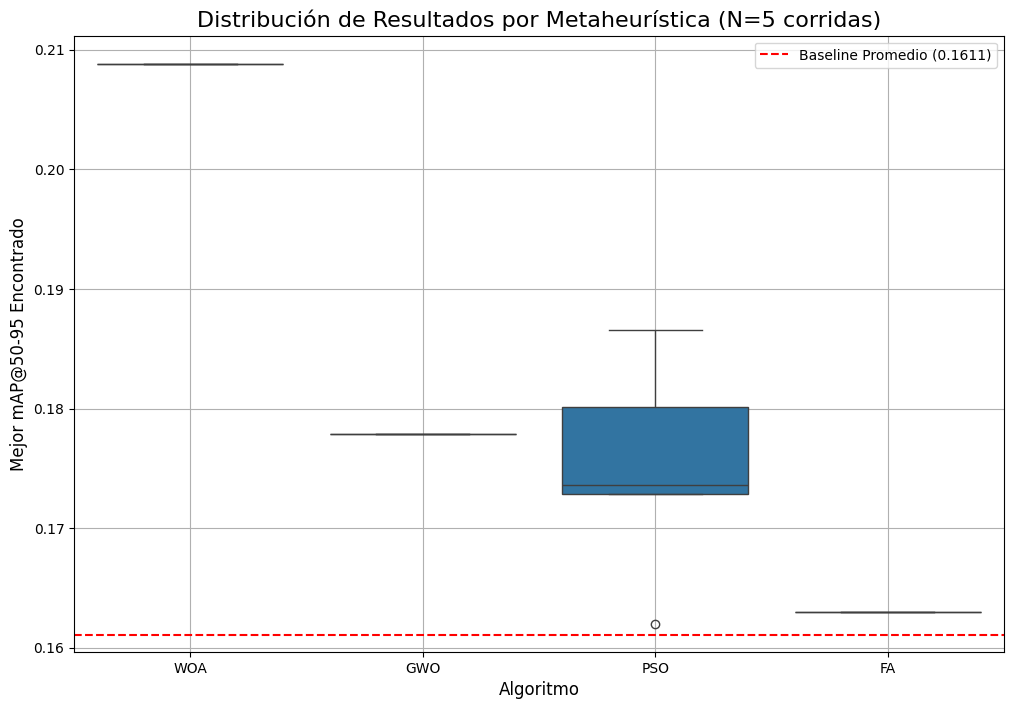


--- Test de Hipótesis: ¿Es WOA significativamente mejor que GWO? ---
H0: Las medianas de los resultados son iguales.
H1: La mediana de WOA es mayor que la de GWO.
Estadístico U: 25.00, p-valor: 0.0020
Conclusión: Se rechaza H0. Hay evidencia estadística para afirmar que WOA es significativamente superior (p < 0.05).


In [14]:
#===================================================================
# Análisis Final: Robustez y Comparación Estadística
#===================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

%matplotlib inline

# --- Cargar los datos del estudio ---
try:
    results_df = pd.read_csv('robustness_study_results.csv')
    print("--- ANÁLISIS ESTADÍSTICO DE RESULTADOS ---")
    
    # --- 1. Calcular estadísticas descriptivas ---
    summary_stats = results_df.groupby('algorithm')['best_score'].agg(['mean', 'std', 'median', 'min', 'max']).sort_values(by='mean', ascending=False)
    baseline_mean = results_df['baseline_reference'].mean()

    print("\nEstadísticas Descriptivas (mAP@50-95):")
    print(summary_stats)
    print(f"\nBaseline Promedio: {baseline_mean:.4f}")

    # --- 2. Visualización con Boxplots ---
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=results_df, x='algorithm', y='best_score', order=summary_stats.index)
    plt.axhline(baseline_mean, color='r', linestyle='--', label=f'Baseline Promedio ({baseline_mean:.4f})')
    plt.title(f'Distribución de Resultados por Metaheurística (N={results_df["run_id"].nunique()} corridas)', fontsize=16)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Mejor mAP@50-95 Encontrado', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 3. Pruebas Estadísticas (Comparar los dos mejores algoritmos) ---
    if len(summary_stats) >= 2:
        best_algo_name = summary_stats.index[0]
        second_best_algo_name = summary_stats.index[1]

        best_algo_scores = results_df[results_df['algorithm'] == best_algo_name]['best_score']
        second_best_scores = results_df[results_df['algorithm'] == second_best_algo_name]['best_score']

        # Test de Mann-Whitney U
        stat, p_value = mannwhitneyu(best_algo_scores, second_best_scores, alternative='greater')

        print(f"\n--- Test de Hipótesis: ¿Es {best_algo_name} significativamente mejor que {second_best_algo_name}? ---")
        print(f"H0: Las medianas de los resultados son iguales.")
        print(f"H1: La mediana de {best_algo_name} es mayor que la de {second_best_algo_name}.")
        print(f"Estadístico U: {stat:.2f}, p-valor: {p_value:.4f}")

        alpha = 0.05
        if p_value < alpha:
            print(f"Conclusión: Se rechaza H0. Hay evidencia estadística para afirmar que {best_algo_name} es significativamente superior (p < {alpha}).")
        else:
            print("Conclusión: No se puede rechazar H0. La diferencia observada no es estadísticamente significativa.")
    
except FileNotFoundError:
    print("El archivo 'robustness_study_results.csv' no fue encontrado.")